# Airline delays 

# Problem Understanding + Question Formulation

The following notebook details the process of using a combination of raw weather observations and airline flight data to predict probabilities of flights departing 15 min or more late compared to their original scheduled departure time. This task will be aimed towards understanding key contributing factors to delays from an operational perspective. With an overall average of about 20% of all domestic flights in 2015 - 2019 being delayed, a model that is able to identify such flights with higher sensitivity and specificity could allow operators to mobilize resources to get flights back on schedule. Correctly identifying flights likely to be delayed that can potentially be addressed will increase customer satisfaction and reduce costs associated with significant snowballing delays that caused missed connections or cancellations.  
*Can we identify instances of delays longer than 15 mins at least two hours ahead of time in order to redistribute resources and mitigate the issue?*  

The below discussions presented by the Bureau of Transportations Statistics guided our feature development and algorithm choices regarding the reported causes of delays
[https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations]. The metrics reported by the BoTS are reporting in % of total delay minutes which is slightly different the objective we present which is a binary classification. While the report details various causes associated with amount of delay in minutes, this may not fully correlate with identifying the rate of 15+ min delays (e.g. extreme weather may cause fewer but longer delays). We begin by replicating some of the features presented such as aircraft arriving late alongside features related to recent weather patterns. We then explore further into operational airport and airline features including moving averages to that estimate likelihood of delays to propogate as well as relative busyness (greater than normal number of departures scheduled) and the airports' pagerank score, indegree, and outdegree. 
  
Despite being an iterative process between eda/feature engineering and model building, the notebook is presented with the following structure
 - EDA + Feature Engineering (*these are mixed as EDA used to confirm potential usefulness of engineered features prior to modeling)
 - Algorithm Theory
 - Model Building ( 2 rounds )
 - End-to-End pipeline
 - Conclusion
 - Discussion (Course Concepts)

## Imports

In [0]:
# py
import math
import numpy as np
import pandas as pd
from multiprocessing.pool import ThreadPool
import pprint
from itertools import combinations

# plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# pyspark / sparksql
from pyspark.sql import functions as f
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
from datetime import date, timedelta

# models
from sklearn.cluster import KMeans, DBSCAN
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder, FeatureHasher, Normalizer, Interaction, Imputer, VectorAssembler, PCA
from pyspark.ml.classification import LogisticRegression, GBTClassifier, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.regression import LinearRegression, GBTRegressor, DecisionTreeRegressor
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, TrainValidationSplit, ParamGridBuilder, _parallelFitTasks, TrainValidationSplitModel

sqlContext = SQLContext(sc)
username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')

team_folder = "dbfs:/mnt/mids-w261/team17"
local_save = '/dbfs/user/' + username +"/final_team17"

dbutils.fs.ls(team_folder)

write_mode = "ignore" # "overwrite"

# Airline Features

In [0]:
interesting_columns_airlines = ['FL_DATE', 'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'DEST',
                              'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE_GROUP',
                              'DEP_DELAY', 'DEP_DEL15', 
                              'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

airlines = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/*.parquet")

display(airlines.sample(False, 0.0001))

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME DIV_AIRPORT_LANDINGS DIV_REACHED_DEST DIV_ACTUAL_ELAPSED_TIME DIV_ARR_DELAY DIV_DISTANCE DIV1_AIRPORT DIV1_AIRPORT_ID DIV1_AIRPORT_SEQ_ID DIV1_WHEELS_ON DIV1_TOTAL_GTIME DIV1_LONGEST_GTIME DIV1_WHEELS_OFF DIV1_TAIL_NUM DIV2_AIRPORT DIV2_AIRPORT_ID DIV2_AIRPORT_SEQ_ID DIV2_WHEELS_ON DIV2_TOTAL_GTIME DIV2_LONGEST_GTIME DIV2_WHEELS_OFF DIV2_TAIL_NUM DIV3_AIRPORT DIV3_AIRPORT_ID DIV3_AIRPORT_SEQ_ID DIV3_WHEELS_ON DIV3_TOTAL_GTIME DIV3_LONGEST_GTIME DIV3_WHEELS_OFF DIV3_TAIL_NUM DIV4_AIRPORT DIV4_AIRPORT_ID DIV4_AIRPORT_SEQ_ID DIV4_WHEELS_ON DIV4_TOTAL_GTIME DIV4_LONGEST_GTIME DIV4_WHEELS_OFF DIV4_TAIL_NUM DIV5_AIRPORT DIV5_AIRPORT_ID DIV5_AIRPORT_SEQ_ID DIV5_WHEELS_ON DIV5_TOTAL_GTIME DIV5_LONGEST_GTIME DIV5_WHEELS_OFF DIV5_TAIL_NUM 2019 3 7 31 3 2019-07-31 B6 20409 B6 N238JB 445 15070 1507003 31703 SWF Newburgh/Poughkeepsie, NY NY 36 New York 22 13204 1320402 31454 MCO Orlando, FL FL 12 Florida 33 1710 1706 -4.0 0.0 0.0 -1 1700-1759 12.0 1718 1955 13.0 2005 2008 3.0 3.0 0.0 0 2000-2059 0.0 null 0.0 175.0 182.0 157.0 1.0 989.0 4 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2019 3 7 7 7 2019-07-07 YX 20452 YX N439YX 4380 12953 1295304 31703 LGA New York, NY NY 36 New York 22 14122 1412202 30198 PIT Pittsburgh, PA PA 42 Pennsylvania 23 2029 2020 -9.0 0.0 0.0 -1 2000-2059 51.0 2111 2208 4.0 2201 2212 11.0 11.0 0.0 0 2200-2259 0.0 null 0.0 92.0 112.0 57.0 1.0 335.0 2 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2019 3 7 9 2 2019-07-09 UA 19977 UA N492UA 1893 12264 1226402 30852 IAD Washington, DC VA 51 Virginia 38 14771 1477104 32457 SFO San Francisco, CA CA 6 California 91 1900 1909 9.0 9.0 0.0 0 1900-1959 11.0 1920 2131 12.0 2157 2143 -14.0 0.0 0.0 -1 2100-2159 0.0 null 0.0 357.0 334.0 311.0 1.0 2419.0 10 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2019 3 7 5 5 2019-07-05 MQ 20398 MQ N536EA 3959 11996 1199603 31871 GSP Greer, SC SC 45 South Carolina 37 13930 1393007 30977 ORD Chicago, IL IL 17 Illinois 41 1031 1034 3.0 3.0 0.0 0 1000-1059 22.0 1056 1121 43.0 1136 1204 28.0 28.0 1.0 1 1100-1159 0.0 null 0.0 125.0 150.0 85.0 1.0 577.0 3 3.0 0.0 25.0 0.0 0.0 null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2019 3 7 21 7 2019-07-21 WN 19393 WN N7851A 3356 10693 1069302 30693 BNA Nashville, TN TN 47 Tennessee 54 13198 1319801 33198 MCI Kansas City, MO MO 29 Missouri 64 830 827 

## Preliminary EDA

Canceled flights have the DEP_DEL15 field as null. Although we would also want to know in advance whether the flight is likely to be canceled, the nature of canceled flights may be significantly different such as

In [0]:
display(airlines.filter("cancelled=1").select("cancelled", "dep_del15"))

cancelled dep_del15 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 0.0 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 0.0 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 1.0 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 1.0 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 1.0 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 1.0 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 1.0 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 1.0 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 0.0 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 1.0 1.0 1.0 1.0 null 1.0 null 1.0 null 1.0 null 1.0 0.0 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 1.0 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 1.0 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 1.0 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 null 1.0 1.0 1.0 0.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 0.0 

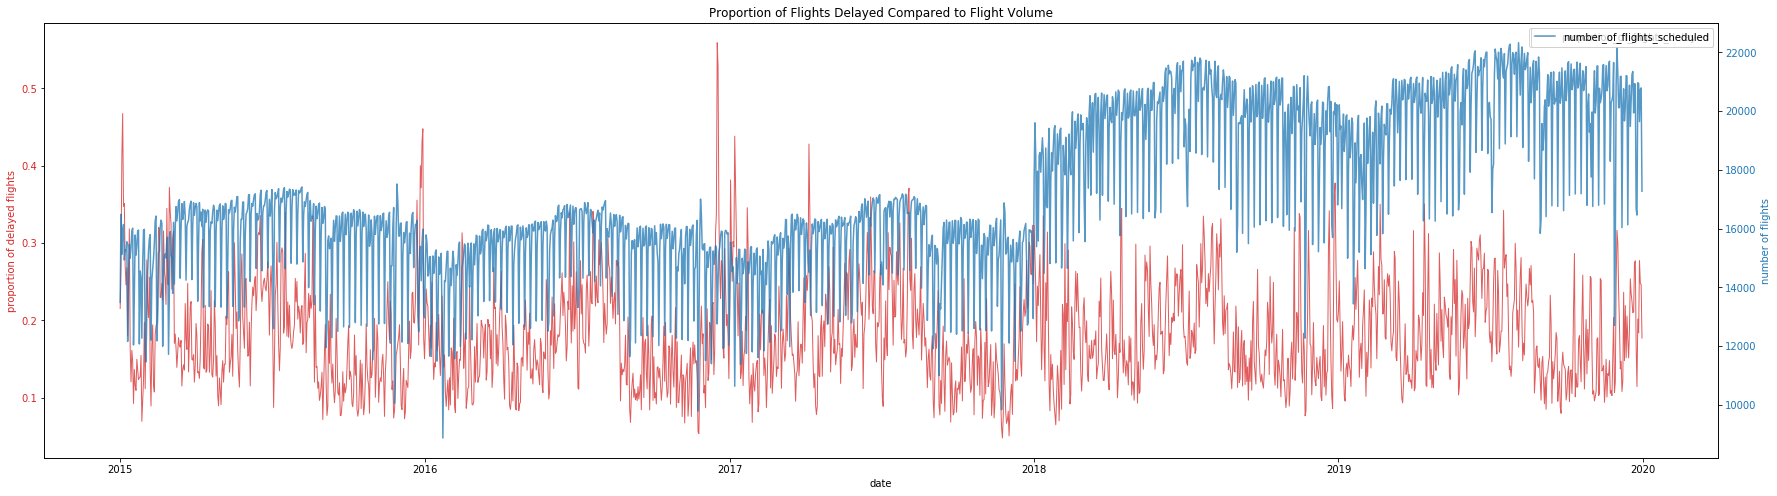

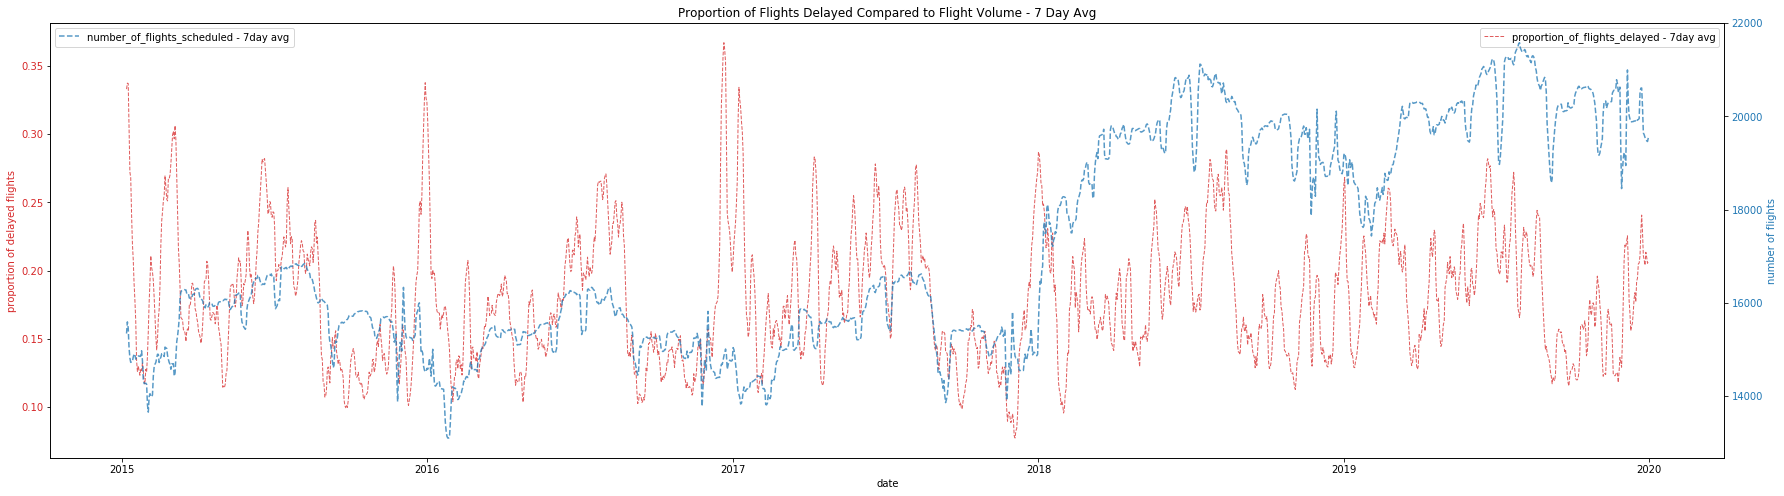

In [0]:
#Plot count of delays total by time
airlines_eda = airlines.filter("DEP_DEL15 is not null").distinct() \
    .withColumn("time_stamp_date" , f.to_timestamp(f.col("FL_DATE") , "yyyy-MM-dd")) #2015-01-01
tmp = airlines_eda.select(['time_stamp_date' , 'DEP_DEL15']) \
    .groupBy("time_stamp_date") \
    .agg(f.count("DEP_DEL15"), f.avg("DEP_DEL15")) \
    .orderBy(f.col("time_stamp_date").asc())
tmp = tmp.toPandas()

fig, ax1 = plt.subplots(figsize=(30,8))
color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('proportion of delayed flights', color=color)
ax1.plot(tmp['time_stamp_date'] , tmp['avg(DEP_DEL15)'], linewidth=1, color=color, alpha=0.75, label="proportion_of_flights_delayed")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc=1)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('number of flights', color=color)  # we already handled the x-label with ax1
ax2.plot(tmp['time_stamp_date'] , tmp['count(DEP_DEL15)'], color=color, alpha=0.75, label="number_of_flights_scheduled")
ax2.tick_params(axis='y', labelcolor=color)

ax2.legend(loc=0)
plt.title("Proportion of Flights Delayed Compared to Flight Volume")
plt.show()

# 7 day avg
fig, ax1 = plt.subplots(figsize=(30,8))
color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('proportion of delayed flights', color=color)
ax1.plot(tmp['time_stamp_date'] , tmp['avg(DEP_DEL15)'].rolling(7).mean(), linewidth=1, color=color, alpha=0.75, linestyle='dashed', label="proportion_of_flights_delayed - 7day avg")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc=1)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('number of flights', color=color)  # we already handled the x-label with ax1
ax2.plot(tmp['time_stamp_date'] , tmp['count(DEP_DEL15)'].rolling(7).mean(), color=color, alpha=0.75, linestyle='dashed', label="number_of_flights_scheduled - 7day avg")
ax2.tick_params(axis='y', labelcolor=color)

ax2.legend(loc=0)
plt.title("Proportion of Flights Delayed Compared to Flight Volume - 7 Day Avg")
plt.show()


Despite large uptick in flight volume 2018 and on, there is no notable increase in proportion of delayed flights, looking at the 7 day moving avgs for flight delays it is clear that there are often seasonal spikes in summer months and during the late Dec / early Jan holiday times

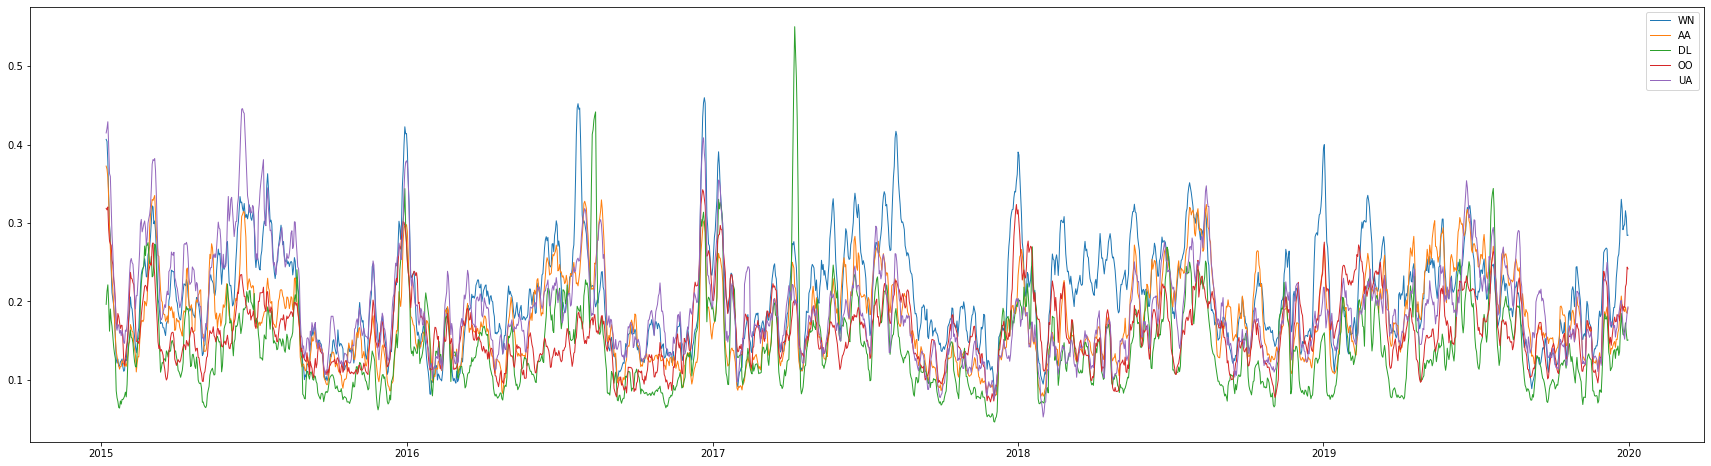

In [0]:
#plot carrier delays over time for top5 carriers by volume
tmp = airlines_eda.select(['time_stamp_date' , 'DEP_DEL15' , 'OP_UNIQUE_CARRIER']).groupBy("time_stamp_date" , "OP_UNIQUE_CARRIER").agg(f.avg('DEP_DEL15'), f.sum('DEP_DEL15')).orderBy(f.col("time_stamp_date").asc()).toPandas()

plt.figure(figsize=(30,8))
top_carriers = list(tmp.groupby("OP_UNIQUE_CARRIER").sum().sort_values('sum(DEP_DEL15)' , ascending=False).iloc[:5,0].index)

for carrier in top_carriers:
    tmp1 = tmp[tmp.OP_UNIQUE_CARRIER==carrier]
    plt.plot(tmp1['time_stamp_date'] , tmp1['avg(DEP_DEL15)'].rolling(7).mean(), linewidth=1)
    plt.legend(labels=top_carriers)

plt.show()

Out[53]:

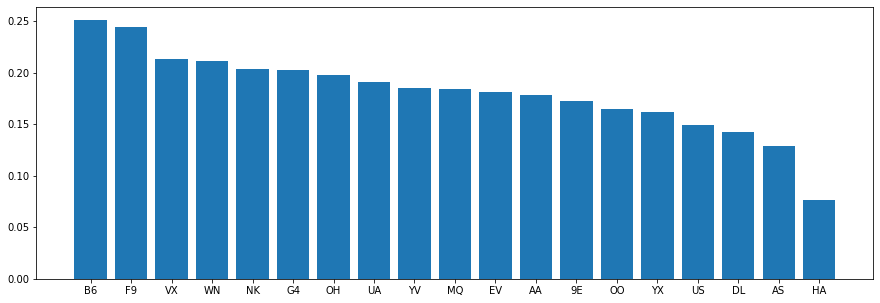

<BarContainer object of 19 artists>

In [0]:
#plot delay rate by carrier
test_2 = airlines_eda.select(['DEP_DEL15' , 'OP_UNIQUE_CARRIER']).groupBy( "OP_UNIQUE_CARRIER").mean('DEP_DEL15').orderBy(f.col("avg(DEP_DEL15)").desc()).toPandas()
test_2 = test_2.rename(columns={"avg(DEP_DEL15)":'Delay_Rate'})
plt.figure(figsize=(15,5))
plt.bar(x = test_2['OP_UNIQUE_CARRIER'], height = test_2['Delay_Rate'])

There is no notable difference amongst seasonality patterns observed for the delay rate of the top 5 carriers by flight volume. However, there is some notable differences in overall delay rate across the set of all carriers in the dataset with top delay rates being held by B6-Jetblue and F9-Frontier Airlines

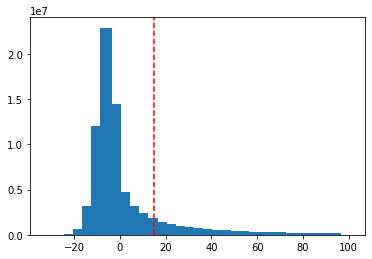

In [0]:
# make plot functions for the distribution of departure delays recorded in minutes
def plot_hist(labels,values):
    df = pd.DataFrame({'lab':labels, 'val':values})
    plt.bar(x=df['lab'], height=df['val'],width=5)
    

def makeHistogram(_min,_max,numBuckets,colName,df):
    _range = list(range(math.floor(_min), math.ceil(_max), round((abs(_min)+abs(_max))/numBuckets)))
    _counts = np.zeros(len(_range))
    for idx, val in enumerate(_range):
        if idx < len(_range)-1:
            _counts[idx] = df.filter(f.col(colName) >= _range[idx]) \
                               .filter(f.col(colName) <= _range[idx+1]) \
                               .count()
    plot_hist(_range,_counts)
    
    
#plot departure delay amounts - historgram
fig, ax = plt.subplots()
ax = makeHistogram(-30.0,100.0,30,'DEP_DELAY',airlines)
plt.axvline(x = 15, color = "r" , linestyle = '--')
plt.show()


## Format Datetimes and Get UTC Times

In [0]:
def select_columns_and_format_time(airlines, select_columns, filters=[]):
    """
    pair down the airlines dataset to only the columns that will be used directly/for other feature engineering
    if filters specified, apply these filters to the dataset
    lastly parse the full datetime of the scheduled flight departure
    """
    for condition in filters:
        airlines = airlines.filter(condition)

    airlines.filter("DEP_DEL15 is not null")
    # select specified columns
    airlines = airlines.select(select_columns).distinct()

    airlines = airlines.withColumn("CRS_DEP_TIME", f.format_string('%04d', f.col("CRS_DEP_TIME")).cast("String"))
    airlines = airlines \
        .withColumn("scheduled_flight_datetime", f.concat(f.col("fl_date") ,f.col("CRS_DEP_TIME"))) \
        .withColumn("scheduled_flight_datetime", f.to_timestamp(f.col("scheduled_flight_datetime"), "yyyy-MM-ddHHmm")) \
        .withColumn("local_hour", f.hour(f.col("scheduled_flight_datetime")))

    # make id numbers strings since they are categorical values
    cat_columns = ['op_carrier_fl_num']
    for c in [c for c in cat_columns if c in select_columns]:
        airlines = airlines.withColumn(c, f.col(c).cast(StringType()))

    return airlines

In [0]:
# ensure the scheduled departure time is formatted correctly
airlines_time_formatted = select_columns_and_format_time(airlines, interesting_columns_airlines, filters=["""fl_date between '2015-01-01' and '2015-03-31'"""])
display(airlines_time_formatted.sample(0.001))

FL_DATE YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK ORIGIN DEST OP_UNIQUE_CARRIER TAIL_NUM OP_CARRIER_FL_NUM CRS_DEP_TIME CRS_ELAPSED_TIME DISTANCE_GROUP DEP_DELAY DEP_DEL15 CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY scheduled_flight_datetime local_hour 2015-02-11 2015 1 2 11 3 GJT DFW MQ N918MQ 2954 1229 121.0 4 -5.0 0.0 null null null null null 2015-02-11T12:29:00.000+0000 12 2015-02-16 2015 1 2 16 1 TUS LAX OO N466SW 2596 0716 99.0 2 -12.0 0.0 null null null null null 2015-02-16T07:16:00.000+0000 7 2015-02-28 2015 1 2 28 6 CLT RSW US N557UW 1841 1430 110.0 3 -1.0 0.0 null null null null null 2015-02-28T14:30:00.000+0000 14 2015-02-27 2015 1 2 27 5 ATL VLD EV N883AS 5295 1517 65.0 1 -3.0 0.0 null null null null null 2015-02-27T15:17:00.000+0000 15 2015-02-22 2015 1 2 22 7 ATL VLD EV N867AS 5034 0907 61.0 1 -9.0 0.0 null null null null null 2015-02-22T09:07:00.000+0000 9 2015-01-02 2015 1 1 2 5 SJU MIA AA N3BVAA 1613 1705 175.0 5 0.0 0.0 null null null null null 2015-01-02T17:05:00.000+0000 17 2015-01-15 2015 1 1 15 4 ROC ORD MQ N546MQ 3457 1835 125.0 3 null null null null null null null 2015-01-15T18:35:00.000+0000 18 2015-01-31 2015 1 1 31 6 PDX LAS NK N530NK 293 1903 122.0 4 -4.0 0.0 null null null null null 2015-01-31T19:03:00.000+0000 19 2015-02-21 2015 1 2 21 6 DTW LAN OO N685BR 4632 1530 49.0 1 -4.0 0.0 null null null null null 2015-02-21T15:30:00.000+0000 15 2015-02-25 2015 1 2 25 3 LAS DEN UA N823UA 996 0820 119.0 3 -8.0 0.0 null null null null null 2015-02-25T08:20:00.000+0000 8 2015-02-04 2015 1 2 4 3 LAS ATL DL N682DA 1602 0600 228.0 7 -1.0 0.0 null null null null null 2015-02-04T06:00:00.000+0000 6 2015-02-20 2015 1 2 20 5 PHL BOS US N956UW 558 2245 72.0 2 97.0 1.0 63.0 0.0 0.0 0.0 24.0 2015-02-20T22:45:00.000+0000 22 2015-03-17 2015 1 3 17 2 IAH GPT EV N19966 4306 0722 76.0 2 -11.0 0.0 null null null null null 2015-03-17T07:22:00.000+0000 7 2015-03-03 2015 1 3 3 2 ASE LAX MQ N544MQ 3142 1806 129.0 3 null null null null null null null 2015-03-03T18:06:00.000+0000 18 2015-03-20 2015 1 3 20 5 SJU BWI WN N206WN 2967 1315 265.0 7 68.0 1.0 0.0 0.0 30.0 0.0 68.0 2015-03-20T13:15:00.000+0000 13 2015-03-27 2015 1 3 27 5 PSE JFK B6 N661JB 746 0500 247.0 7 24.0 1.0 null null null null null 2015-03-27T05:00:00.000+0000 5 2015-02-16 2015 1 2 16 1 MDW FLL WN N235WN 2951 1420 180.0 5 -3.0 0.0 null null null null null 2015-02-16T14:20:00.000+0000 14 2015-03-14 2015 1 3 14 6 HNL DEN UA N214UA 383 2020 395.0 11 -1.0 0.0 null null null null null 2015-03-14T20:20:00.000+0000 20 2015-03-11 2015 1 3 11 3 ORD TPA UA N528UA 494 1418 160.0 5 -1.0 0.0 null null null null null 2015-03-11T14:18:00.000+0000 14 2015-03-05 2015 1 3 5 4 LNK ORD EV N16149 4162 0755 95.0 2 -5.0 0.0 null null null null null 2015-03-05T07:55:00.000+0000 7 2015-03-07 2015 1 3 7 6 LAN MSP OO N438SW 4576 1602 103.0 2 -7.0 0.0 null null null null null 2015-03-07T16:02:00.000+0000 16 2015-03-18 2015 1 3 18 3 LAX ORD UA N810UA 537 0654 239.0 7 -10.0 0.0 null null null null null 2015-03-18T06:54:00.000+0000 6 2015-03-25 2015 1 3 25 3 SAN HOU WN N7752B 2073 1025 175.0 6 2.0 0.0 null null null null null 2015-03-25T10:25:00.000+0000 10 2015-03-27 2015 1 3 27 5 BOS MCO B6 N591JB 951 1523 190.0 5 -3.0 0.0 0.0 0.0 41.0 0.0 0.0 2015-03-27T15:23:00.000+0000 15 2015-03-22 2015 1 3 22 7 FNT TPA WN N417WN 4374 0700 170.0 5 -3.0 0.0 null null null null null 2015-03-22T07:00:00.000+0000 7 2015-03-03 2015 1 3 3 2 ATL EWR DL N370NB 1798 1000 136.0 3 6.0 0.0 null null null null null 2015-03-03T10:00:00.000+0000 10 2015-03-16 2015 1 3 16 1 LFT IAH EV N13992 4568 0530 67.0 1 -7.0 0.0 null null null null null 2015-03-16T05:30:00.000+0000 5 2015-01-14 2015 1 1 14 3 MSY MSP DL N399DA 1603 1530 165.0 5 0.0 0.0 null null null null null 2015-01-14T15:30:00.000+0000 15 2015-01-04 2015 1 1 4 7 PHX SFO F9 N928FR 1055 1735 125.0 3 184.0 1.0 7.0 0.0 53.0 0.0 121.0 2015-01-04T17:35:00.000+0000 17 2015-01-31 2015 1 1 31 6 SAN PDX AS N309AS 571 1525 147.0 4 -10.0 0.0 null 

In [0]:
def adjust_flight_times_to_utc(airlines_time_formatted, tz_data="dbfs:/FileStore/tables/timezones-1.csv"):
    """
    adjust all the departure times to UTC for the join with weather; however, keep the local time
    broadcast map of airport code to timezone, then shift to UTC time
    """
    tz = spark.read.option("header", "true").csv(tz_data)
    airlines_with_tz = airlines_time_formatted.join(f.broadcast(tz), airlines_time_formatted.ORIGIN == tz.iata_code)
    airlines_with_tz = airlines_with_tz.drop("iata_code", "windows_tz")
    airlines_with_tz = airlines_with_tz \
    .withColumn("scheduled_flight_datetime_UTC", 
                f.to_utc_timestamp(f.col("scheduled_flight_datetime"), f.col("iana_tz"))).filter("DEP_DELAY is not null") \
    .withColumn("scheduled_flight_hour_UTC", 
                f.date_trunc('hour', f.col("scheduled_flight_datetime_UTC")))
    return airlines_with_tz

def add_holidays(airlines_with_tz, holiday_data="dbfs:/FileStore/tables/group17_holidays.csv"):
    """
    As seen in the above EDA, there is seasonality observed with spikes in high delay rates coming around the winter holidays.
    Broadcast and add indicators for is_holiday and is_near_holiday (holidays +- 2 days)
    """
    # dont need a spark read here but pandas does not read from dbfs
    holidays = spark.read.option("header", "true").csv(holiday_data)
    holidayDates = [date.fromisoformat(x.DATE) for x in holidays.select('DATE').collect()]
    nearHolidayDates = set()
    date_deltas = [1, 2, 3]
    for currentDate in holidayDates:
        nearHolidayDates.add(currentDate)
        for i in date_deltas:
            delta = timedelta(days=i)
            nearHolidayDates.add(currentDate + delta)
            nearHolidayDates.add(currentDate - delta)
    holidayDates = sc.broadcast(holidayDates)
    nearHolidayDates = sc.broadcast(nearHolidayDates)
    airlines_w_holidays = airlines_with_tz \
        .withColumn("is_holiday", f.col("FL_DATE").isin(holidayDates.value).cast(IntegerType())) \
        .withColumn("is_near_holiday", f.col("FL_DATE").isin(nearHolidayDates.value).cast(IntegerType()))
    return airlines_w_holidays

In [0]:
tz = spark.read.option("header", "true").csv(f"dbfs:/FileStore/tables/timezones-1.csv")
display(tz)

iata_code iana_tz windows_tz AAA Pacific/Tahiti Hawaiian Standard Time AAB Australia/Brisbane E. Australia Standard Time AAC Africa/Cairo Egypt Standard Time AAD Africa/Mogadishu E. Africa Standard Time AAE Africa/Algiers W. Central Africa Standard Time AAF America/New_York Eastern Standard Time AAG America/Sao_Paulo E. South America Standard Time AAH Europe/Berlin W. Europe Standard Time AAI America/Araguaina Tocantins Standard Time AAJ America/Paramaribo SA Eastern Standard Time AAK Pacific/Tarawa UTC+12 AAL Europe/Copenhagen Romance Standard Time AAM Africa/Johannesburg South Africa Standard Time AAN Asia/Dubai Arabian Standard Time AAO America/Caracas Venezuela Standard Time AAQ Europe/Moscow Russian Standard Time AAR Europe/Copenhagen Romance Standard Time AAS Asia/Jayapura Tokyo Standard Time AAT Asia/Shanghai China Standard Time AAU Pacific/Apia Samoa Standard Time AAV Asia/Manila Singapore Standard Time AAX America/Sao_Paulo E. South America Standard Time AAY Asia/Aden Arab Standard Time AAZ America/Guatemala Central America Standard Time ABA Asia/Krasnoyarsk North Asia Standard Time ABB Africa/Lagos W. Central Africa Standard Time ABC Europe/Madrid Romance Standard Time ABD Asia/Tehran Iran Standard Time ABE America/New_York Eastern Standard Time ABF Pacific/Tarawa UTC+12 ABG Australia/Brisbane E. Australia Standard Time ABH Australia/Brisbane E. Australia Standard Time ABI America/Chicago Central Standard Time ABJ Africa/Abidjan Greenwich Standard Time ABK Africa/Addis_Ababa E. Africa Standard Time ABL America/Anchorage Alaskan Standard Time ABM Australia/Brisbane E. Australia Standard Time ABN America/Cayenne SA Eastern Standard Time ABO Africa/Abidjan Greenwich Standard Time ABP Pacific/Port_Moresby West Pacific Standard Time ABQ America/Denver Mountain Standard Time ABR America/Chicago Central Standard Time ABS Africa/Cairo Egypt Standard Time ABT Asia/Riyadh Arab Standard Time ABU Asia/Makassar Singapore Standard Time ABV Africa/Lagos W. Central Africa Standard Time ABX Australia/Melbourne AUS Eastern Standard Time ABY America/New_York Eastern Standard Time ABZ Europe/London GMT Standard Time ACA America/Mexico_City Central Standard Time (Mexico) ACB America/Detroit Eastern Standard Time ACC Africa/Accra Greenwich Standard Time ACD America/Bogota SA Pacific Standard Time ACE Atlantic/Canary GMT Standard Time ACF Australia/Brisbane E. Australia Standard Time ACH Europe/Vienna W. Europe Standard Time ACI Europe/Guernsey GMT Standard Time ACJ Asia/Colombo Sri Lanka Standard Time ACK America/New_York Eastern Standard Time ACL America/Bogota SA Pacific Standard Time ACM America/Bogota SA Pacific Standard Time ACN America/Matamoros Central Standard Time ACP Asia/Tehran Iran Standard Time ACR America/Bogota SA Pacific Standard Time ACS Asia/Krasnoyarsk North Asia Standard Time ACT America/Chicago Central Standard Time ACU America/Panama SA Pacific Standard Time ACV America/Los_Angeles Pacific Standard Time ACX Asia/Shanghai China Standard Time ACY America/New_York Eastern Standard Time ACZ Asia/Tehran Iran Standard Time ADA Europe/Istanbul Turkey Standard Time ADB Europe/Istanbul Turkey Standard Time ADC Pacific/Port_Moresby West Pacific Standard Time ADD Africa/Addis_Ababa E. Africa Standard Time ADE Asia/Aden Arab Standard Time ADF Europe/Istanbul Turkey Standard Time ADG America/Detroit Eastern Standard Time ADH Asia/Yakutsk Yakutsk Standard Time ADI Africa/Windhoek Namibia Standard Time ADJ Asia/Amman Jordan Standard Time ADK America/Adak Aleutian Standard Time ADL Australia/Adelaide Cen. Australia Standard Time ADM America/Chicago Central Standard Time ADN America/Bogota SA Pacific Standard Time ADO Australia/Adelaide Cen. Australia Standard Time ADP Asia/Colombo Sri Lanka Standard Time ADQ America/Anchorage Alaskan Standard Time ADR America/New_York Eastern Standard Time ADS America/Chicago Central Standard Time ADT America/Chicago Central Standard Time ADU Asia/Tehran Iran Standard Time ADV Africa/Khartoum Sudan 

In [0]:
airlines_with_tz = adjust_flight_times_to_utc(airlines_time_formatted, tz_data="dbfs:/FileStore/tables/timezones-1.csv")
display(airlines_with_tz.sample(0.01))

FL_DATE YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK ORIGIN DEST OP_UNIQUE_CARRIER TAIL_NUM OP_CARRIER_FL_NUM CRS_DEP_TIME CRS_ELAPSED_TIME DISTANCE_GROUP DEP_DELAY DEP_DEL15 CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY scheduled_flight_datetime local_hour iana_tz scheduled_flight_datetime_UTC scheduled_flight_hour_UTC 2015-03-15 2015 1 3 15 7 MCO JFK DL N907DL 2174 1200 163.0 4 -3.0 0.0 null null null null null 2015-03-15T12:00:00.000+0000 12 America/New_York 2015-03-15T16:00:00.000+0000 2015-03-15T16:00:00.000+0000 2015-03-05 2015 1 3 5 4 FLL ATL DL N618DL 1827 1345 126.0 3 -2.0 0.0 null null null null null 2015-03-05T13:45:00.000+0000 13 America/New_York 2015-03-05T18:45:00.000+0000 2015-03-05T18:00:00.000+0000 2015-03-14 2015 1 3 14 6 HOU ATL WN N776WN 1314 1710 115.0 3 2.0 0.0 null null null null null 2015-03-14T17:10:00.000+0000 17 America/Chicago 2015-03-14T22:10:00.000+0000 2015-03-14T22:00:00.000+0000 2015-03-20 2015 1 3 20 5 SAT DFW AA N4YAAA 2286 0955 70.0 1 -8.0 0.0 null null null null null 2015-03-20T09:55:00.000+0000 9 America/Chicago 2015-03-20T14:55:00.000+0000 2015-03-20T14:00:00.000+0000 2015-03-13 2015 1 3 13 5 HNL SEA DL N585NW 2246 2040 337.0 11 0.0 0.0 null null null null null 2015-03-13T20:40:00.000+0000 20 Pacific/Honolulu 2015-03-14T06:40:00.000+0000 2015-03-14T06:00:00.000+0000 2015-03-28 2015 1 3 28 6 ATL SAN DL N817DN 1567 1930 291.0 8 0.0 0.0 null null null null null 2015-03-28T19:30:00.000+0000 19 America/New_York 2015-03-28T23:30:00.000+0000 2015-03-28T23:00:00.000+0000 2015-03-19 2015 1 3 19 4 CLT BWI US N747UW 1924 1130 84.0 2 -7.0 0.0 null null null null null 2015-03-19T11:30:00.000+0000 11 America/New_York 2015-03-19T15:30:00.000+0000 2015-03-19T15:00:00.000+0000 2015-03-20 2015 1 3 20 5 DEN TUS WN N406WN 3660 2200 115.0 3 43.0 1.0 0.0 0.0 0.0 0.0 28.0 2015-03-20T22:00:00.000+0000 22 America/Denver 2015-03-21T04:00:00.000+0000 2015-03-21T04:00:00.000+0000 2015-03-30 2015 1 3 30 1 MKE MCO WN N563WN 3855 1220 160.0 5 -5.0 0.0 null null null null null 2015-03-30T12:20:00.000+0000 12 America/Chicago 2015-03-30T17:20:00.000+0000 2015-03-30T17:00:00.000+0000 2015-03-14 2015 1 3 14 6 HNL SEA DL N589NW 2246 2040 335.0 11 -1.0 0.0 null null null null null 2015-03-14T20:40:00.000+0000 20 Pacific/Honolulu 2015-03-15T06:40:00.000+0000 2015-03-15T06:00:00.000+0000 2015-03-10 2015 1 3 10 2 SUN SFO OO N719SK 5228 1408 118.0 3 -7.0 0.0 null null null null null 2015-03-10T14:08:00.000+0000 14 America/Boise 2015-03-10T20:08:00.000+0000 2015-03-10T20:00:00.000+0000 2015-03-16 2015 1 3 16 1 KOA PHX US N905AW 661 2145 343.0 11 -8.0 0.0 null null null null null 2015-03-16T21:45:00.000+0000 21 Pacific/Honolulu 2015-03-17T07:45:00.000+0000 2015-03-17T07:00:00.000+0000 2015-03-11 2015 1 3 11 3 LGA BOS US N948UW 2128 2000 73.0 1 -2.0 0.0 null null null null null 2015-03-11T20:00:00.000+0000 20 America/New_York 2015-03-12T00:00:00.000+0000 2015-03-12T00:00:00.000+0000 2015-03-02 2015 1 3 2 1 HOU TPA WN N208WN 116 1830 115.0 4 30.0 1.0 0.0 0.0 0.0 0.0 21.0 2015-03-02T18:30:00.000+0000 18 America/Chicago 2015-03-03T00:30:00.000+0000 2015-03-03T00:00:00.000+0000 2015-03-15 2015 1 3 15 7 PIT MDW WN N421LV 4479 0650 95.0 2 -5.0 0.0 null null null null null 2015-03-15T06:50:00.000+0000 6 America/New_York 2015-03-15T10:50:00.000+0000 2015-03-15T10:00:00.000+0000 2015-03-09 2015 1 3 9 1 ISN IAH EV N11140 4469 1411 217.0 6 -13.0 0.0 null null null null null 2015-03-09T14:11:00.000+0000 14 America/Chicago 2015-03-09T19:11:00.000+0000 2015-03-09T19:00:00.000+0000 2015-03-10 2015 1 3 10 2 CHS DFW MQ N632MQ 3542 1145 195.0 4 -13.0 0.0 null null null null null 2015-03-10T11:45:00.000+0000 11 America/New_York 2015-03-10T15:45:00.000+0000 2015-03-10T15:00:00.000+0000 2015-03-11 2015 1 3 11 3 ORD TYS MQ N692MQ 3226 2040 90.0 2 4.0 0.0 null null null null null 2015-03-11T20:40:00.000+0000 20 America/Chicago 2015-03-12T01:40:00.000+0000 2015-03-12T01:00:00.000+0000 2015-03-29 2015 1 3 29 7 SFO SLC OO N120SY 521

In [0]:
airlines_with_tz_holidays = add_holidays(airlines_with_tz, holiday_data="dbfs:/FileStore/tables/group17_holidays.csv")
display(airlines_with_tz_holidays.filter("is_holiday=True"))

FL_DATE YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK ORIGIN DEST OP_UNIQUE_CARRIER TAIL_NUM OP_CARRIER_FL_NUM CRS_DEP_TIME CRS_ELAPSED_TIME DISTANCE_GROUP DEP_DELAY DEP_DEL15 CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY scheduled_flight_datetime local_hour iana_tz scheduled_flight_datetime_UTC scheduled_flight_hour_UTC is_holiday is_near_holiday 2015-02-16 2015 1 2 16 1 PBI BOS B6 N768JB 222 1153 176.0 5 117.0 1.0 16.0 0.0 9.0 0.0 101.0 2015-02-16T11:53:00.000+0000 11 America/New_York 2015-02-16T16:53:00.000+0000 2015-02-16T16:00:00.000+0000 1 1 2015-02-16 2015 1 2 16 1 ORD FAR EV N14158 4755 1522 117.0 3 36.0 1.0 30.0 0.0 0.0 0.0 0.0 2015-02-16T15:22:00.000+0000 15 America/Chicago 2015-02-16T21:22:00.000+0000 2015-02-16T21:00:00.000+0000 1 1 2015-02-16 2015 1 2 16 1 HRL IAH EV N11107 4671 0521 74.0 2 -6.0 0.0 null null null null null 2015-02-16T05:21:00.000+0000 5 America/Chicago 2015-02-16T11:21:00.000+0000 2015-02-16T11:00:00.000+0000 1 1 2015-02-16 2015 1 2 16 1 CVG ORD MQ N539MQ 3530 1136 84.0 2 49.0 1.0 46.0 0.0 4.0 0.0 3.0 2015-02-16T11:36:00.000+0000 11 America/New_York 2015-02-16T16:36:00.000+0000 2015-02-16T16:00:00.000+0000 1 1 2015-02-16 2015 1 2 16 1 IAH MAF OO N794SK 5253 1911 88.0 2 156.0 1.0 0.0 0.0 4.0 0.0 156.0 2015-02-16T19:11:00.000+0000 19 America/Chicago 2015-02-17T01:11:00.000+0000 2015-02-17T01:00:00.000+0000 1 1 2015-02-16 2015 1 2 16 1 LAS EWR UA N78501 1271 1031 298.0 9 27.0 1.0 null null null null null 2015-02-16T10:31:00.000+0000 10 America/Los_Angeles 2015-02-16T18:31:00.000+0000 2015-02-16T18:00:00.000+0000 1 1 2015-02-16 2015 1 2 16 1 ORD IAH UA N13718 1494 0813 173.0 4 -1.0 0.0 null null null null null 2015-02-16T08:13:00.000+0000 8 America/Chicago 2015-02-16T14:13:00.000+0000 2015-02-16T14:00:00.000+0000 1 1 2015-02-16 2015 1 2 16 1 PIT IAH UA N837UA 234 0723 201.0 5 33.0 1.0 19.0 0.0 0.0 0.0 0.0 2015-02-16T07:23:00.000+0000 7 America/New_York 2015-02-16T12:23:00.000+0000 2015-02-16T12:00:00.000+0000 1 1 2015-02-16 2015 1 2 16 1 SBN ORD OO N743SK 4997 0530 59.0 1 35.0 1.0 0.0 29.0 0.0 0.0 0.0 2015-02-16T05:30:00.000+0000 5 America/Indiana/Indianapolis 2015-02-16T10:30:00.000+0000 2015-02-16T10:00:00.000+0000 1 1 2015-02-16 2015 1 2 16 1 BWI MHT WN N728SW 321 0720 80.0 2 4.0 0.0 null null null null null 2015-02-16T07:20:00.000+0000 7 America/New_York 2015-02-16T12:20:00.000+0000 2015-02-16T12:00:00.000+0000 1 1 2015-02-16 2015 1 2 16 1 BWI PBI WN N233LV 1222 1015 155.0 4 -1.0 0.0 null null null null null 2015-02-16T10:15:00.000+0000 10 America/New_York 2015-02-16T15:15:00.000+0000 2015-02-16T15:00:00.000+0000 1 1 2015-02-16 2015 1 2 16 1 DEN STL WN N430WN 134 1335 110.0 4 6.0 0.0 6.0 0.0 25.0 0.0 0.0 2015-02-16T13:35:00.000+0000 13 America/Denver 2015-02-16T20:35:00.000+0000 2015-02-16T20:00:00.000+0000 1 1 2015-02-16 2015 1 2 16 1 LAS DEN WN N249WN 1011 1205 110.0 3 -2.0 0.0 null null null null null 2015-02-16T12:05:00.000+0000 12 America/Los_Angeles 2015-02-16T20:05:00.000+0000 2015-02-16T20:00:00.000+0000 1 1 2015-02-16 2015 1 2 16 1 LAS ELP WN N7815L 4655 1620 95.0 3 66.0 1.0 9.0 0.0 0.0 0.0 47.0 2015-02-16T16:20:00.000+0000 16 America/Los_Angeles 2015-02-17T00:20:00.000+0000 2015-02-17T00:00:00.000+0000 1 1 2015-02-16 2015 1 2 16 1 LAS ONT WN N7740A 1878 0825 50.0 1 0.0 0.0 null null null null null 2015-02-16T08:25:00.000+0000 8 America/Los_Angeles 2015-02-16T16:25:00.000+0000 2015-02-16T16:00:00.000+0000 1 1 2015-02-16 2015 1 2 16 1 LAX DAL WN N494WN 562 0735 175.0 5 -3.0 0.0 null null null null null 2015-02-16T07:35:00.000+0000 7 America/Los_Angeles 2015-02-16T15:35:00.000+0000 2015-02-16T15:00:00.000+0000 1 1 2015-02-16 2015 1 2 16 1 DEN PHX US N650AW 410 0545 122.0 3 -2.0 0.0 null null null null null 2015-02-16T05:45:00.000+0000 5 America/Denver 2015-02-16T12:45:00.000+0000 2015-02-16T12:00:00.000+0000 1 1 2015-02-16 2015 1 2 16 1 SMF PHX US N764US 439 0955 104.0 3 -10.0 0.0 null null null null null 2015-02-16T09:55:00.000+0000 9 America/Los_Angeles 2015-02-1

## Propogate Recent Aircraft Delays
One contributing factor to delays is if the previous flight of the same aircraft arrived too close too or after the scheduled departure time of the current flight

In [0]:
def get_last_tail_num_flight_delay(airlines_with_tz):
    """
    This function utilizes data from both the current flight and that of the previous flight for this same tail number.
    Considerations include:
    - time must be standardized on UTC to determine whether the information about when the previous flight departed would have been known at time t-2 with respect to the current scheduled departure in questions
    - the previous flight must be arriving at the same airport code as the origin of the current flight
    - the approximate arrival time = (actual departure time, if known at t-2hrs else, scheduled departure time) + scheduled flight duration
    - return delta = departure time - approximate arrival time, clip at > 2hrs before departure since greater than that amount of time is not likely to be a contributing factor to delays.
    """
    # window spec to get the last flight for the tail number
    tailnum_window_spec = \
        Window \
          .partitionBy([f.col("tail_num")]) \
          .orderBy(f.col("scheduled_flight_datetime_UTC")) \
          .rowsBetween(-1, -1)

    # create columns for:
    # 1. tail_num_delay_lag_tem = the delay value for the last flight that had the same tail number
    # 2. tail_num_dep_time_lag = when was the last flight departure that had the same tail number, in UTC
    # 3. tail_num_from = where did the last flight from this tail number come from
    # 4. tail_num_to = what was destination of the last flight from this tail_num
    # 5. tail_num_expected_elapsed = what is the scheduled elapsed time for the previous flight
    airlines_with_tz = airlines_with_tz \
        .withColumn("tail_num_delay_lag_temp", f.lag("dep_delay", 1).over(tailnum_window_spec)) \
        .withColumn("tail_num_dep_time_lag", f.lag("scheduled_flight_datetime_UTC", 1).over(tailnum_window_spec)) \
        .withColumn("tail_num_from", f.lag("origin", 1).over(tailnum_window_spec)) \
        .withColumn("tail_num_to", f.lag("dest", 1).over(tailnum_window_spec)) \
        .withColumn("tail_num_expected_elapsed", f.lag("crs_elapsed_time", 1).over(tailnum_window_spec))

    # if the last departure was between 2 and 8 hrs ago, record the previous delay, else 0
    airlines_with_tz = airlines_with_tz.withColumn("tail_num_delay_lag",
        f.when((f.col("scheduled_flight_datetime_UTC").cast(LongType()) - 
                f.col("tail_num_dep_time_lag").cast(LongType())).between(2*3600, 8*3600), 
               f.col("tail_num_delay_lag_temp")) \
        .otherwise(0))

    # if the new expected arrival time with the observed delay is within two hours of the current flight departure time, indicate number of min else 0
    # last destination must also match current origin
    airlines_with_tz = airlines_with_tz.withColumn("tail_num_arrival_to_next_departure_delta",
          (f.col("scheduled_flight_datetime_UTC").cast(LongType()) - 
          (f.col("tail_num_dep_time_lag").cast(LongType()) + f.col("tail_num_expected_elapsed")*60 + f.col("tail_num_delay_lag")*60)) / 60)

    airlines_with_tz = airlines_with_tz.withColumn("tail_num_arrival_to_next_departure_delta",
        f.when((f.col("tail_num_arrival_to_next_departure_delta") > 120) | 
               (f.col("tail_num_to") != f.col("origin")), 120) \
        .when(f.col("tail_num_arrival_to_next_departure_delta").isNull(), 120) \
        .otherwise(f.col("tail_num_arrival_to_next_departure_delta")))

    # tail num arriving less than two hours before next departure indicator
    airlines_with_tz = airlines_with_tz.withColumn("tail_num_arrive_less_than_two_hours_indicator",
            f.when(f.col("tail_num_arrival_to_next_departure_delta") < 120, 1).otherwise(0))

    airlines_with_tz = airlines_with_tz.drop("tail_num_delay_lag_temp", "tail_num_dep_time_lag", "tail_num_to", 
                                           "tail_num_expected_elapsed", "tail_num_delay_lag")
    return airlines_with_tz.fillna({'tail_num_from':'NA'})

In [0]:
airlines_with_propogating_delay = get_last_tail_num_flight_delay(airlines_with_tz_holidays)
display(airlines_with_propogating_delay.sample(0.001))

FL_DATE YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK ORIGIN DEST OP_UNIQUE_CARRIER TAIL_NUM OP_CARRIER_FL_NUM CRS_DEP_TIME CRS_ELAPSED_TIME DISTANCE_GROUP DEP_DELAY DEP_DEL15 CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY scheduled_flight_datetime local_hour iana_tz scheduled_flight_datetime_UTC scheduled_flight_hour_UTC is_holiday is_near_holiday tail_num_from tail_num_arrival_to_next_departure_delta tail_num_arrive_less_than_two_hours_indicator 2015-03-04 2015 1 3 4 3 IAH DAL EV N10575 5914 0730 69.0 1 -4.0 0.0 null null null null null 2015-03-04T07:30:00.000+0000 7 America/Chicago 2015-03-04T13:30:00.000+0000 2015-03-04T13:00:00.000+0000 0 0 HRL 61.0 1 2015-01-29 2015 1 1 29 4 PBI DFW AA N3ATAA 2221 1340 198.0 5 -3.0 0.0 null null null null null 2015-01-29T13:40:00.000+0000 13 America/New_York 2015-01-29T18:40:00.000+0000 2015-01-29T18:00:00.000+0000 0 0 DFW 34.0 1 2015-02-12 2015 1 2 12 4 MIA DCA AA N3CWAA 238 1425 149.0 4 -6.0 0.0 null null null null null 2015-02-12T14:25:00.000+0000 14 America/New_York 2015-02-12T19:25:00.000+0000 2015-02-12T19:00:00.000+0000 0 0 ORD 58.0 1 2015-03-23 2015 1 3 23 1 ATL BOS DL N6700 903 2035 154.0 4 0.0 0.0 null null null null null 2015-03-23T20:35:00.000+0000 20 America/New_York 2015-03-24T00:35:00.000+0000 2015-03-24T00:00:00.000+0000 0 0 TPA 72.0 1 2015-03-27 2015 1 3 27 5 LAX ABQ OO N866AS 2875 0912 114.0 3 -4.0 0.0 null null null null null 2015-03-27T09:12:00.000+0000 9 America/Los_Angeles 2015-03-27T16:12:00.000+0000 2015-03-27T16:00:00.000+0000 0 0 SJC 55.0 1 2015-02-12 2015 1 2 12 4 LAS BUR WN N914WN 3580 1840 60.0 1 14.0 0.0 null null null null null 2015-02-12T18:40:00.000+0000 18 America/Los_Angeles 2015-02-13T02:40:00.000+0000 2015-02-13T02:00:00.000+0000 0 0 GEG 11.0 1 2015-01-26 2015 1 1 26 1 LAS LBB WN N954WN 169 1050 115.0 4 -8.0 0.0 null null null null null 2015-01-26T10:50:00.000+0000 10 America/Los_Angeles 2015-01-26T18:50:00.000+0000 2015-01-26T18:00:00.000+0000 0 0 ONT 30.0 1 2015-01-10 2015 1 1 10 6 LAS DEN F9 N220FR 782 0645 109.0 3 -3.0 0.0 null null null null null 2015-01-10T06:45:00.000+0000 6 America/Los_Angeles 2015-01-10T14:45:00.000+0000 2015-01-10T14:00:00.000+0000 0 0 IAD 120.0 0 2015-02-01 2015 1 2 1 7 LGA ATL DL N301NB 2547 1730 167.0 4 3.0 0.0 null null null null null 2015-02-01T17:30:00.000+0000 17 America/New_York 2015-02-01T22:30:00.000+0000 2015-02-01T22:00:00.000+0000 0 0 MSP 120.0 0 2015-03-25 2015 1 3 25 3 ATL CHS DL N306DQ 1670 0815 67.0 2 -1.0 0.0 null null null null null 2015-03-25T08:15:00.000+0000 8 America/New_York 2015-03-25T12:15:00.000+0000 2015-03-25T12:00:00.000+0000 0 0 CHS 96.0 1 2015-01-05 2015 1 1 5 1 SLC BOS DL N3741S 1843 1720 266.0 9 29.0 1.0 null null null null null 2015-01-05T17:20:00.000+0000 17 America/Denver 2015-01-06T00:20:00.000+0000 2015-01-06T00:00:00.000+0000 0 0 MSP 9.0 1 2015-01-25 2015 1 1 25 7 DFW LAX AA N5ESAA 2449 1400 202.0 5 13.0 0.0 null null null null null 2015-01-25T14:00:00.000+0000 14 America/Chicago 2015-01-25T20:00:00.000+0000 2015-01-25T20:00:00.000+0000 0 0 LAX 75.0 1 2015-02-08 2015 1 2 8 7 LAX KOA AA N5ESAA 247 1710 356.0 11 -1.0 0.0 null null null null null 2015-02-08T17:10:00.000+0000 17 America/Los_Angeles 2015-02-09T01:10:00.000+0000 2015-02-09T01:00:00.000+0000 0 0 DFW 106.0 1 2015-02-18 2015 1 2 18 3 EGE DFW AA N5ESAA 1495 1359 126.0 3 7.0 0.0 null null null null null 2015-02-18T13:59:00.000+0000 13 America/Denver 2015-02-18T20:59:00.000+0000 2015-02-18T20:00:00.000+0000 0 1 DFW 55.0 1 2015-02-08 2015 1 2 8 7 LAS SFO VX N633VA 897 0715 90.0 2 4.0 0.0 null null null null null 2015-02-08T07:15:00.000+0000 7 America/Los_Angeles 2015-02-08T15:15:00.000+0000 2015-02-08T15:00:00.000+0000 0 0 LAX 120.0 0 2015-01-01 2015 1 1 1 4 PHX DEN US N642AW 642 1555 104.0 3 0.0 0.0 null null null null null 2015-01-01T15:55:00.000+0000 15 America/Phoenix 2015-01-01T22:55:00.000+0000 2015-01-01T22:00:00.000+0000 1 1 BOS 120.0 0 2015-03-07 2015 1 3 7 6 MSP PHX WN N651SW 2844 2100 205.0 6 -6.0

## PageRank
PageRank, in the context of flights and airports, represents the relative probability that someone taking flights randomly from airport to airport will end up at each location. In some sense, this can be seen as the airports average popularity or busy

Documentation notes on graphframes:
 - PageRank does not take any weight (on edges and nodes) into the consideration.
 - PageRank uses the directions. Hence directed graphs for origin and dest are a good fit.
 - Duplicated edges play role. In our example, if  x has called y twice,  in the graph there will be two edges initiated from x to y. And if x contacted z only once (which results in having single edge between x and z), in this case PageRank score for y will be higher than z, and it means y is more important than z.  So to apply the pagerank implementation of graphframes on the airport dataset, we create an edge for every flight with equal weight.
   
Confirmed implementation of teleportation to alleviate both unreachable and dangling nodes here:
[w261 - team 17 - test graphframes pagerank](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4061768275120744/command/4061768275120745)

In [0]:
airlines = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/*.parquet").distinct().cache()
# collect sets of airports in origins and destinations, the difference in these sets denote dangling nodes / unconnected parts of the graph
origin = set(airlines.select(f.col("origin").alias("airport")).distinct().collect())
dest = set(airlines.select(f.col("dest").alias("airport")).distinct().collect())

full_airport_set = origin.union(dest)
print("airports not in set of origins: {}".format(full_airport_set.difference(origin)))
print("airports not in set of destinations: {}".format(full_airport_set.difference(dest)))
airport_ids = {a.airport: i for i, a in enumerate(sorted(list(full_airport_set)))}

airports not in set of origins: {Row(airport='FNL')}
airports not in set of destinations: {Row(airport='TKI'), Row(airport='EFD'), Row(airport='ENV')}

There are three dangling nodes that need to be addressed and one node that is not reachable from other nodes

In [0]:
from graphframes import GraphFrame
import networkx as nx

# create graph, for pagerank each flight must represent an edge since the implementation does not consider edge weights
edges = airlines \
  .select(f.col("origin").alias("src"), 
          f.col("dest").alias("dst"),
          f.lit(1).alias("weight"))

vertices = spark.createDataFrame(data=[(arpt.airport, arpt.airport, 1.0/len(full_airport_set)) for arpt in full_airport_set],
                                 schema=["id", "airport", "weight"])

print("vertices")
vertices.printSchema()
vertices.show()

print("edges")
edges.printSchema()
edges.show()

g = GraphFrame(vertices, edges)

vertices
root
-- id: string (nullable = true)
-- airport: string (nullable = true)
-- weight: double (nullable = true)

+---+-------+--------------------+
 id|airport| weight|
+---+-------+--------------------+
OMA| OMA|0.002688172043010753|
SFO| SFO|0.002688172043010753|
SIT| SIT|0.002688172043010753|
ACY| ACY|0.002688172043010753|
BQN| BQN|0.002688172043010753|
HNL| HNL|0.002688172043010753|
XWA| XWA|0.002688172043010753|
TVC| TVC|0.002688172043010753|
RHI| RHI|0.002688172043010753|
GRB| GRB|0.002688172043010753|
SNA| SNA|0.002688172043010753|
MLB| MLB|0.002688172043010753|
ADQ| ADQ|0.002688172043010753|
COD| COD|0.002688172043010753|
PSP| PSP|0.002688172043010753|
ILM| ILM|0.002688172043010753|
MBS| MBS|0.002688172043010753|
SHV| SHV|0.002688172043010753|
SLC| SLC|0.002688172043010753|
GPT| GPT|0.002688172043010753|
+---+-------+--------------------+
only showing top 20 rows

edges
root
-- src: string (nullable = true)
-- dst: string (nullable = true)
-- weight: integer (nullable = false)

+---+---+------+
src|dst|weight|
+---+---+------+
MCO|AUS| 1|
ATL|CLE| 1|
RDU|ORD| 1|
CVG|PHL| 1|
ORD|PIT| 1|
GSO|DEN| 1|
IAH|DEN| 1|
AUS|DEN| 1|
PHX|TUS| 1|
SEA|SBA| 1|
SJC|PDX| 1|
BZN|PDX| 1|
ORD|SLC| 1|
DEN|XNA| 1|
SLC|MSO| 1|
SFO|PSC| 1|
BFL|DEN| 1|
DEN|BIL| 1|
DEN|CVG| 1|
SGU|SLC| 1|
+---+---+------+
only showing top 20 rows

In [0]:
PageRankResults = g.pageRank(resetProbability=0.15, maxIter=20).cache()

In [0]:
PageRankResults.vertices.sort(['pagerank'],ascending=[0]).show(10)
PageRankResults.vertices.sort(['pagerank'],ascending=[1]).show(10)

+---+-------+--------------------+------------------+
 id|airport| weight| pagerank|
+---+-------+--------------------+------------------+
ATL| ATL|0.002688172043010753|19.963254423492906|
ORD| ORD|0.002688172043010753| 16.91921543573921|
DFW| DFW|0.002688172043010753|14.679391566062026|
DEN| DEN|0.002688172043010753|13.463748944835135|
LAX| LAX|0.002688172043010753| 10.11929300863177|
MSP| MSP|0.002688172043010753| 8.57481053414788|
SFO| SFO|0.002688172043010753| 8.571836984788918|
CLT| CLT|0.002688172043010753| 8.358513273365633|
IAH| IAH|0.002688172043010753| 8.18341862307033|
PHX| PHX|0.002688172043010753| 7.984731014585763|
+---+-------+--------------------+------------------+
only showing top 10 rows

+---+-------+--------------------+-------------------+
 id|airport| weight| pagerank|
+---+-------+--------------------+-------------------+
ENV| ENV|0.002688172043010753| 0.1503435465767866|
EFD| EFD|0.002688172043010753| 0.1503435465767866|
TKI| TKI|0.002688172043010753| 0.1503435465767866|
FNL| FNL|0.002688172043010753| 0.1503526028556044|
YNG| YNG|0.002688172043010753| 0.1504200962466336|
ILG| ILG|0.002688172043010753|0.15112137150484672|
FLO| FLO|0.002688172043010753| 0.1518486315720874|
BFM| BFM|0.002688172043010753| 0.1518950475897044|
CEC| CEC|0.002688172043010753| 0.1519609091781864|
XWA| XWA|0.002688172043010753| 0.152480694982722|
+---+-------+--------------------+-------------------+
only showing top 10 rows

In [0]:
outDegrees = g.edges \
    .groupBy(f.col("src").alias("id")) \
    .agg(f.countDistinct(f.col("dst")).alias("outDegree"))
inDegrees = g.edges \
    .groupBy(f.col("dst").alias("id")) \
    .agg(f.countDistinct(f.col("src")).alias("inDegree"))
degrees = inDegrees.alias("in") \
    .join(outDegrees.alias("out"), inDegrees.id == outDegrees.id) \
    .select("in.id","in.inDegree", "out.outDegree").cache()

degrees.sort(['inDegree'],ascending=[0]).show() # Sort and show 
degrees.sort(['inDegree'],ascending=[1]).show()

+---+--------+---------+
 id|inDegree|outDegree|
+---+--------+---------+
ORD| 197| 197|
DEN| 186| 185|
DFW| 186| 186|
ATL| 175| 174|
CLT| 140| 140|
MSP| 138| 137|
IAH| 127| 127|
DTW| 126| 126|
LAS| 125| 124|
LAX| 119| 118|
PHX| 106| 106|
SLC| 103| 103|
EWR| 102| 102|
MCO| 102| 99|
SFO| 98| 97|
PHL| 97| 97|
DCA| 94| 94|
IAD| 92| 93|
SEA| 87| 87|
FLL| 84| 84|
+---+--------+---------+
only showing top 20 rows

+---+--------+---------+
 id|inDegree|outDegree|
+---+--------+---------+
BET| 1| 1|
GST| 1| 1|
ABY| 1| 1|
FLO| 1| 1|
BGM| 1| 1|
DLG| 1| 1|
LYH| 1| 1|
HYA| 1| 1|
ADK| 1| 1|
GTR| 1| 1|
GCK| 1| 2|
PPG| 1| 1|
DHN| 1| 1|
SPN| 1| 1|
DRT| 1| 1|
IFP| 1| 1|
CDC| 1| 1|
CEC| 1| 1|
BJI| 1| 1|
LBF| 1| 1|
+---+--------+---------+
only showing top 20 rows

In [0]:
PageRankResultsWDegree = PageRankResults.vertices.alias("pr") \
    .join(degrees, PageRankResults.vertices.id == degrees.id) \
    .select("pr.id", "pr.pagerank", "inDegree", "outDegree")

In [0]:
PageRankResultsWDegree.show(10)

+---+-------------------+--------+---------+
 id| pagerank|inDegree|outDegree|
+---+-------------------+--------+---------+
BGM| 0.1883346948630929| 1| 1|
DLG|0.16056079797292683| 1| 1|
INL|0.21340334339749628| 3| 3|
PSE|0.18277080251748218| 2| 2|
MSY| 2.2574717964719557| 55| 54|
PPG|0.15616563410720252| 1| 1|
DRT|0.15890365281382438| 1| 1|
GEG| 0.6707204067965791| 19| 21|
BUR| 1.2016946906206334| 19| 18|
SNA| 1.9650827252126857| 27| 26|
+---+-------------------+--------+---------+
only showing top 10 rows

### Checkpoint the pagerank results

In [0]:
PageRankResultsWDegree.write \
    .mode(write_mode) \
    .parquet(team_folder + "/airportPageRankWDegree.parquet")

In [0]:
def join_pagerank(df, pagerank_data):
    """function to join precalculated pagerank scores to airlines data"""
    pageranks = spark.read.option("header", "true").parquet(pagerank_data).select("id", "pagerank", "indegree", "outdegree")
    # the pagerank values easily fit in memory as there are less than 400 airports so we will broadcast join
    def join_airport(df, pr, join_col):
        joined = df.join(f.broadcast(pr), f.col(join_col) == f.col("id"))
        for c in ["pagerank", "indegree", "outdegree"]:
            joined = joined.withColumnRenamed(c, f'{join_col}_{c}')
        return joined.drop('id')
    
    df_with_origin_pageranks = join_airport(df, pageranks, "origin")
    df_with_both_pageranks = join_airport(df_with_origin_pageranks, pageranks, "dest")
    return df_with_both_pageranks

### EDA pagerank scores

In [0]:
pageranks = spark.read.option("header", "true").parquet(team_folder + "/airportPageRankWDegree.parquet").select("id", "pagerank", "indegree", "outdegree")
display(pageranks.orderBy(f.col("pagerank").desc()))

id pagerank indegree outdegree ATL 19.963254423492945 175 174 ORD 16.919215435739257 197 197 DFW 14.679391566062032 186 186 DEN 13.463748944835118 186 185 LAX 10.1192930086318 119 118 MSP 8.574810534147863 138 137 SFO 8.57183698478892 98 97 CLT 8.35851327336559 140 140 IAH 8.183418623070336 127 127 PHX 7.984731014585766 106 106 DTW 7.790083823145386 126 126 SEA 7.266689522195242 87 87 LAS 7.112765546149396 125 124 SLC 6.97856600552012 103 103 MCO 6.209071363293494 102 99 LGA 5.869651077065331 83 82 BOS 5.81564050750527 73 72 EWR 5.665828456328278 102 102 JFK 5.209690604838352 74 73 DCA 4.578498581564265 94 94 BWI 4.501754986814705 75 75 PHL 4.421789142526931 97 97 FLL 4.340751172616015 84 84 MDW 3.8335101707684047 77 77 SAN 3.815314996268944 67 67 MIA 3.6266342595555057 71 72 TPA 3.2900232785125505 72 71 DAL 3.119304918327976 67 67 BNA 2.864899003935549 73 73 PDX 2.8400721239314564 56 58 HNL 2.7941135048241375 31 31 STL 2.7138608954947805 61 64 ANC 2.606924786253811 33 32 HOU 2.599262469182644 62 63 IAD 2.577315737714472 92 93 AUS 2.538709098972892 67 66 OAK 2.302191963976993 52 54 SJC 2.28595831434713 49 52 MSY 2.2574717964719553 55 54 MCI 2.2560984711391403 53 56 RDU 2.1281567875061485 62 63 SMF 2.093063842761953 39 41 SNA 1.9650827252126886 27 26 CLE 1.9207558353458232 55 59 IND 1.7621763448019896 50 50 PIT 1.7137298008870658 49 51 SAT 1.6890767009923726 49 50 CVG 1.5770169710196258 61 63 CMH 1.572813216813805 43 43 MKE 1.558145966815223 44 47 RSW 1.5218088420153544 53 50 OGG 1.291059460273214 20 20 SJU 1.2733910192789089 29 29 PBI 1.2265470056891987 38 35 BUR 1.2016946906206254 19 18 JAX 1.1973490582323716 40 43 BDL 1.1839996255624288 29 30 OMA 1.1250979925354478 37 37 ABQ 1.0735108159995403 27 28 JNU 1.0614292867757216 7 8 ONT 1.0398458343676569 20 23 BUF 1.022944197422326 29 28 OKC 1.01957954592198 38 36 RIC 1.0016330775927151 25 25 SFB 0.9953208868372144 78 78 MEM 0.9938252073741373 34 34 TUS 0.9291875093516854 26 25 CHS 0.9218973231376372 32 34 BOI 0.902738813388234 22 24 TUL 0.8664132018208384 27 31 RNO 0.8577588558971078 22 23 SDF 0.8524860556449951 37 38 ORF 0.8491383233137126 31 32 GRR 0.8402534371013908 33 35 BHM 0.80232102461698 26 25 PVD 0.7815278865931394 28 28 KOA 0.7772515418656224 16 16 ELP 0.7504683210223901 16 17 LGB 0.7497104074105733 20 21 LIH 0.7350077456788059 13 13 DSM 0.7203707990956186 28 30 TYS 0.7101299320188841 26 29 AZA 0.6897918829068559 50 50 GEG 0.670720406796581 19 21 SAV 0.6628204344322479 31 33 MSN 0.6612461761404692 28 30 MYR 0.6519123188729427 49 49 LIT 0.650976435673539 20 19 PSP 0.6267670747786895 19 17 PIE 0.6254374267092506 61 61 DAY 0.6120439501996323 22 21 GSP 0.6101155252397401 28 29 ALB 0.6068869387668079 23 25 ROC 0.6052751390291549 19 20 XNA 0.6050184995554116 23 23 ICT 0.5889548431687492 17 19 COS 0.5806524260844793 20 18 FAT 0.5755451084565414 11 13 SYR 0.5744745584714651 24 26 GSO 0.5676838324872154 18 20 CID 0.5352540156744365 19 18 HPN 0.5291520995018839 12 11 KTN 0.528726185101835 4 4 PNS 0.5225586929724324 17 19 LEX 0.5204859983394204 20 19 FAI 0.5144283231408974 9 7 BTR 0.4900661574688724 7 7 PGD 0.48907514113409634 53 52 PWM 0.48818864013784874 17 17 VPS 0.48102187804535834 39 39 MAF 0.47947312736469355 7 7 FWA 0.46520716995785716 15 14 SGF 0.4641677649093923 13 14 SBN 0.4628630320632652 18 21 JAN 0.45783938660978524 10 10 FSD 0.457457603861286 12 15 MHT 0.4537143455759775 17 17 ITO 0.45091296348206367 3 3 AVL 0.4476869576043817 21 19 SHV 0.4454947815832086 9 10 CHA 0.4407831566259218 13 13 HSV 0.4325676152340788 10 11 SBA 0.4304066888365662 8 8 CAK 0.4276307486226111 18 18 FAR 0.4273205875032937 11 13 BZN 0.4139291002332487 21 17 BTV 0.40521137204110896 14 12 ASE 0.40443402346479157 12 10 CAE 0.4006623722375687 12 11 MOB 0.3896664774542573 6 5 LBB 0.38842619593420413 8 10 PSG 0.38548012498982154 2 2 SIT 0.38545467100148667 3 4 PIA 0.38545236824749796 17 14 MDT 0.3849280858268176 17 17 WRG 0.3809035510531059 2 2 GRB 0.37745372559002177 7 11 SRQ 0.37451674420626235 35 3

In [0]:
airport_delays = airlines \
    .groupBy("origin", "dest") \
    .agg(f.sum("DEP_DEL15").alias("num_delays"), f.count("DEP_DEL15").alias("num_flights")) \
    .withColumn("delay_proportion", f.col("num_delays") / f.col("num_flights")) 
airport_delays_w_pagerank = join_pagerank(airport_delays,
                                          team_folder+"/airportPageRankWDegree.parquet").toPandas()


Correlations betweeen pagerank and delays. The delay proportions have extremely high variance across airports for those with low pageranks; meanwhile, airports with larger pagerank values tend to converge between 15 and 25%.
This relationship is non linear and best captured by models that do not assume such a relationship.

In [0]:
airport_delays_w_pagerank_origin = airport_delays_w_pagerank \
    .groupby(["origin", "origin_pagerank"]) \
    .agg({"num_delays": np.sum, "num_flights": np.sum}) \
    .reset_index()
airport_delays_w_pagerank_origin["delay_proportion"] = airport_delays_w_pagerank_origin['num_delays'] / airport_delays_w_pagerank_origin['num_flights']

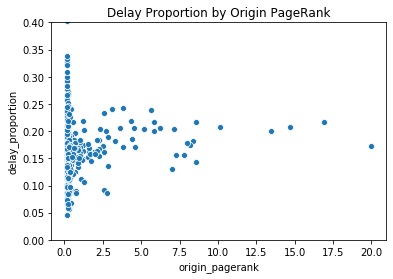

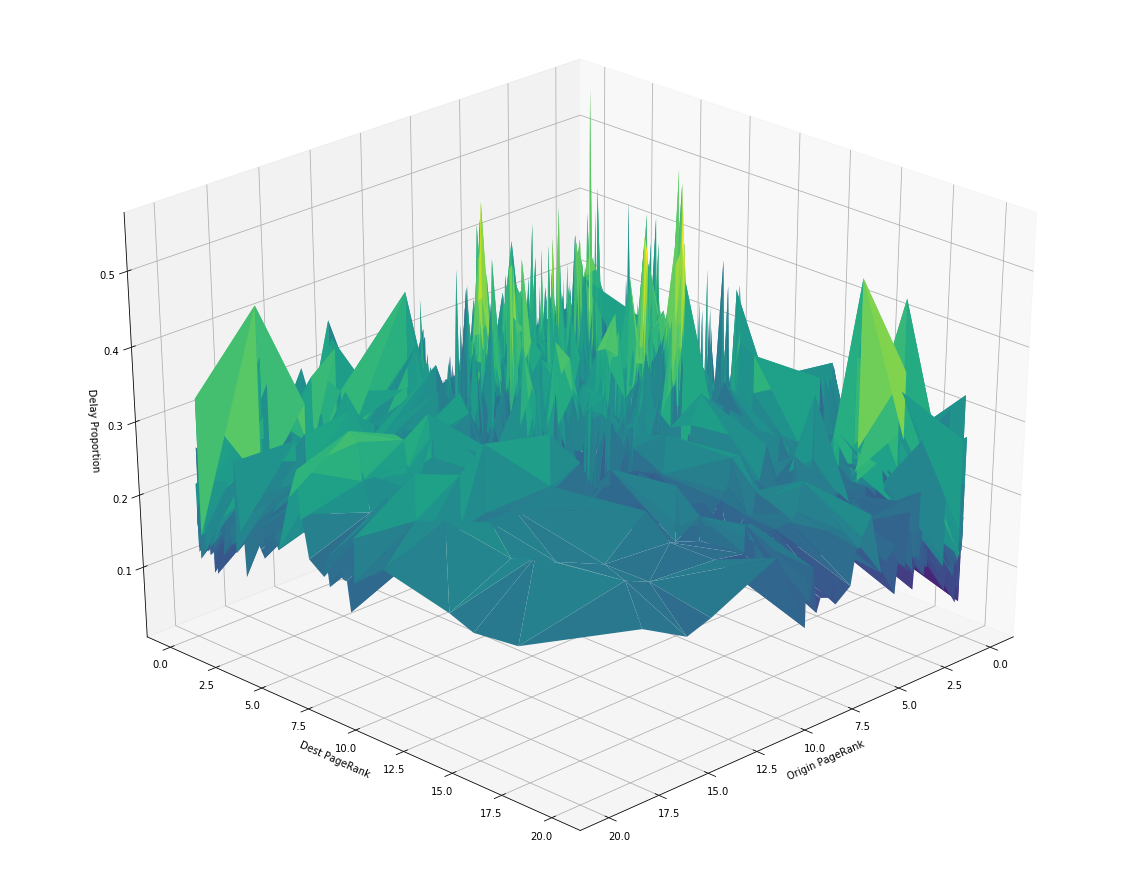

In [0]:
from mpl_toolkits.mplot3d import Axes3D
sns.scatterplot(data=airport_delays_w_pagerank_origin, x="origin_pagerank", y="delay_proportion")
plt.ylim(0, 0.4)
plt.title("Delay Proportion by Origin PageRank")
plt.show()

# 3d origin, dest, delay proportion
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection = '3d')
df = airport_delays_w_pagerank[airport_delays_w_pagerank.num_flights > 100]
x = df['origin_pagerank']
y = df['dest_pagerank']
z = df['delay_proportion']

ax.set_xlabel("Origin PageRank")
ax.set_ylabel("Dest PageRank")
ax.set_zlabel("Delay Proportion")

ax.plot_trisurf(x, y, z, cmap=plt.cm.viridis, linewidth=0.5)
ax.view_init(30, 45)

plt.show()

## Write Intermediate Stage - Airlines
Small 2015 dataset with ORD and ATL

In [0]:
airlines_with_propogating_delay.filter("origin in ('ORD', 'ATL')") \
.write \
.mode(write_mode) \
.parquet(team_folder + "/airlineFeaturesSmall.parquet")

Full Dataset 2015-2019

In [0]:
interesting_columns_airlines = ['FL_DATE', 'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'DEST',
                              'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE_GROUP',
                              'DEP_DELAY', 'DEP_DEL15', 
                              'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

airlines = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/*.parquet")

airlines_time_formatted = select_columns_and_format_time(airlines, 
                                                         interesting_columns_airlines, 
                                                         filters=[])

airlines_with_tz = adjust_flight_times_to_utc(airlines_time_formatted, 
                                              tz_data="dbfs:/FileStore/tables/timezones-1.csv")

airlines_with_tz_holidays = add_holidays(airlines_with_tz, holiday_data="dbfs:/FileStore/tables/group17_holidays.csv")

airlines_with_tz_holidays = get_last_tail_num_flight_delay(airlines_with_tz_holidays)

airlines_with_pagerank = join_pagerank(airlines_with_tz_holidays, 
                                       pagerank_data=team_folder + "/airportPageRankWDegree.parquet")

airlines_with_pagerank \
    .write \
    .mode(write_mode) \
    .parquet(team_folder + "/airlineFeaturesFull.parquet")

## Aggregate and Window Features
**Windows vs GroupBy/Join**

Efficiency depends on the data. It depends on the cardinality of the grouping column in question. When cardinality is small, the data will be small after the aggregation and the aggregated result can be broadcasted in the join. In that case, the join will be faster than the window. On the other hand, if the cardinality is large, thus the data is large after the aggregation, the join will be planed with SortMergeJoin and using window may be more efficient.

In [0]:
airlineFeaturesSmall = spark.read.option("header", "true").parquet(team_folder + "/airlineFeaturesSmall.parquet")

In [0]:

def norm_origin_busyness_by_hour(airlines, verbose=False):
    """
    calculate the relative scheduled busyness of an airport for the given hour in which the flight is scheduled to depart
    normalize for each airport
    """
    hourly_busyness = airlines.groupby("origin", "scheduled_flight_hour_UTC", "local_hour", f.year(f.col("fl_date")).alias("year")) \
        .agg(f.count("tail_num").alias("num_flights_hourly")).cache()

    origin_window_spec = Window \
          .partitionBy([f.col("origin"), f.col("year"), f.col("local_hour")])
    
    hourly_busyness_normed = hourly_busyness \
        .withColumn("avg_flights_per_hour", f.avg("num_flights_hourly").over(origin_window_spec)) \
        .withColumn("stddev_flights_per_hour", f.stddev("num_flights_hourly").over(origin_window_spec)) \
        .withColumn("scheduled_busyness_normed", f.coalesce((f.col("num_flights_hourly") - f.col("avg_flights_per_hour")) / f.col("stddev_flights_per_hour"), f.lit(0.0)))
    
    if verbose:
        display(hourly_busyness_normed)
    
    return airlines.alias("a") \
        .join(hourly_busyness_normed.alias("hb"), 
              (f.col("a.origin") == f.col("hb.origin")) & 
              (f.col("a.scheduled_flight_hour_UTC") == f.col("hb.scheduled_flight_hour_UTC"))) \
        .select("a.*", "hb.num_flights_hourly", "hb.scheduled_busyness_normed")

def rolling_delays(airlines):
    """
    for each day, rolling avg of the flight delay proportion by origin and by carrier
    this will be windowed with a range between to maintain 2 hours shift in knowledge
    i.e. for 12:00pm on a given day in local time, what is the proportion of flights delayed from 7:00 to 09:59
    between is inclusive so the range will be [-5, -3]
    
    for the last 24 hours by origin and by carrier
    """
    airlines_w_rolling_delay = airlines
    
    for name, column in [("origin", "origin"), ("carrier", "op_unique_carrier")]:
        intra_day_window_spec = Window \
          .partitionBy([f.col(column), f.col("fl_date")]) \
          .orderBy(f.col("local_hour")) \
          .rangeBetween(-5, -3)
        
        full_day_window_spec = Window \
          .partitionBy([f.col(column)]) \
          .orderBy(f.col("scheduled_flight_datetime_UTC").cast("long")) \
          .rangeBetween(-3600*26, -3600*22)
        
        airlines_w_rolling_delay = airlines_w_rolling_delay \
            .withColumn(f"rolling_sum_delay_intraday_{name}", f.coalesce(f.sum("dep_del15").over(intra_day_window_spec), f.lit(0.0))) \
            .withColumn(f"rolling_avg_delay_intraday_{name}", f.coalesce(f.avg("dep_del15").over(intra_day_window_spec), f.lit(0.0)))
        
        airlines_w_rolling_delay = airlines_w_rolling_delay \
            .withColumn(f"rolling_sum_delay_24hr_{name}", f.coalesce(f.sum("dep_del15").over(full_day_window_spec), f.lit(0.0))) \
            .withColumn(f"rolling_avg_delay_24hr_{name}", f.coalesce(f.avg("dep_del15").over(full_day_window_spec), f.lit(0.0)))
    return airlines_w_rolling_delay

In [0]:
display(norm_origin_busyness_by_hour(airlineFeaturesSmall, verbose=True))

origin scheduled_flight_hour_UTC local_hour year num_flights_hourly avg_flights_per_hour stddev_flights_per_hour scheduled_busyness_normed ATL 2015-01-20T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-01-16T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-02-23T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-02-24T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-02-05T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-01-12T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-01-01T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-03-09T09:00:00.000+0000 5 2015 2 1.3209876543209877 0.46976484792466006 1.4454303013066463 ATL 2015-03-03T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-01-08T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-01-06T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-01-26T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-01-15T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-01-13T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-01-21T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-03-20T09:00:00.000+0000 5 2015 2 1.3209876543209877 0.46976484792466006 1.4454303013066463 ATL 2015-02-19T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-01-07T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-03-30T09:00:00.000+0000 5 2015 2 1.3209876543209877 0.46976484792466006 1.4454303013066463 ATL 2015-03-11T09:00:00.000+0000 5 2015 2 1.3209876543209877 0.46976484792466006 1.4454303013066463 ATL 2015-01-30T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-02-27T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-03-28T09:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-01-19T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-02-14T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-03-10T09:00:00.000+0000 5 2015 2 1.3209876543209877 0.46976484792466006 1.4454303013066463 ATL 2015-02-02T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-03-12T09:00:00.000+0000 5 2015 2 1.3209876543209877 0.46976484792466006 1.4454303013066463 ATL 2015-03-16T09:00:00.000+0000 5 2015 2 1.3209876543209877 0.46976484792466006 1.4454303013066463 ATL 2015-03-07T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-02-09T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-03-15T09:00:00.000+0000 5 2015 2 1.3209876543209877 0.46976484792466006 1.4454303013066463 ATL 2015-03-26T09:00:00.000+0000 5 2015 2 1.3209876543209877 0.46976484792466006 1.4454303013066463 ATL 2015-03-23T09:00:00.000+0000 5 2015 2 1.3209876543209877 0.46976484792466006 1.4454303013066463 ATL 2015-01-29T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-01-24T10:00:00.000+0000 5 2015 1 1.3209876543209877 0.46976484792466006 -0.6832943242540512 ATL 2015-03-31T09:00:00.000+0000 5 2015 2 1.3209876543209877 0.46976484792466006 1.4454303013066463 ATL 2015-02-16T10:00:00.000+0000 5 2015 2 1.3209876543209877 0.46976484792466006 1.4454303013066463 ATL 2015-01-02T10:00:00.000+0000 5 

FL_DATE YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK ORIGIN DEST OP_UNIQUE_CARRIER TAIL_NUM OP_CARRIER_FL_NUM CRS_DEP_TIME CRS_ELAPSED_TIME DISTANCE_GROUP DEP_DELAY DEP_DEL15 CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY scheduled_flight_datetime local_hour iana_tz scheduled_flight_datetime_UTC scheduled_flight_hour_UTC is_holiday is_near_holiday tail_num_from tail_num_arrival_to_next_departure_delta tail_num_arrive_less_than_two_hours_indicator num_flights_hourly scheduled_busyness_normed 2015-01-01 2015 1 1 1 4 ATL ABE EV N131EV 5267 1335 110.0 3 -2.0 0.0 null null null null null 2015-01-01T13:35:00.000+0000 13 America/New_York 2015-01-01T18:35:00.000+0000 2015-01-01T18:00:00.000+0000 true true NA 120.0 0 54 -1.9240776684858505 2015-01-02 2015 1 1 2 5 ATL TUL EV N131EV 5084 0818 130.0 3 -5.0 0.0 null null null null null 2015-01-02T08:18:00.000+0000 8 America/New_York 2015-01-02T13:18:00.000+0000 2015-01-02T13:00:00.000+0000 false true ABE 120.0 0 84 0.8705279114800034 2015-01-02 2015 1 1 2 5 ATL ABE EV N131EV 5267 1335 110.0 3 -2.0 0.0 null null null null null 2015-01-02T13:35:00.000+0000 13 America/New_York 2015-01-02T18:35:00.000+0000 2015-01-02T18:00:00.000+0000 false true TUL 49.0 1 71 0.6857085307901706 2015-01-03 2015 1 1 3 6 ATL BMI EV N131EV 5082 1025 106.0 3 4.0 0.0 null null null null null 2015-01-03T10:25:00.000+0000 10 America/New_York 2015-01-03T15:25:00.000+0000 2015-01-03T15:00:00.000+0000 false true ABE 120.0 0 79 0.2022829414715103 2015-01-03 2015 1 1 3 6 ATL ATW EV N131EV 5028 1506 135.0 4 15.0 1.0 null null null null null 2015-01-03T15:06:00.000+0000 15 America/New_York 2015-01-03T20:06:00.000+0000 2015-01-03T20:00:00.000+0000 false true BMI 43.0 1 59 -1.4247788846107048 2015-01-03 2015 1 1 3 6 ATL ABE EV N131EV 5072 2101 109.0 3 1.0 0.0 1.0 0.0 23.0 0.0 0.0 2015-01-03T21:01:00.000+0000 21 America/New_York 2015-01-04T02:01:00.000+0000 2015-01-04T02:00:00.000+0000 false true ATW 54.0 1 71 1.0859413437603673 2015-01-04 2015 1 1 4 7 ATL HPN EV N131EV 4965 0942 133.0 4 -1.0 0.0 null null null null null 2015-01-04T09:42:00.000+0000 9 America/New_York 2015-01-04T14:42:00.000+0000 2015-01-04T14:00:00.000+0000 false true ABE 51.0 1 81 0.36605420375131664 2015-01-04 2015 1 1 4 7 ATL MYR EV N131EV 5469 1537 70.0 2 60.0 1.0 1.0 0.0 0.0 0.0 51.0 2015-01-04T15:37:00.000+0000 15 America/New_York 2015-01-04T20:37:00.000+0000 2015-01-04T20:00:00.000+0000 false true HPN 12.0 1 67 -0.6258374539878796 2015-01-05 2015 1 1 5 1 ATL MOB EV N131EV 5104 1056 76.0 2 122.0 1.0 122.0 0.0 1.0 0.0 0.0 2015-01-05T10:56:00.000+0000 10 America/New_York 2015-01-05T15:56:00.000+0000 2015-01-05T15:00:00.000+0000 false false MYR 120.0 0 75 -0.4912585721450936 2015-01-05 2015 1 1 5 1 ATL AVP EV N131EV 5126 2034 111.0 3 62.0 1.0 0.0 0.0 0.0 0.0 61.0 2015-01-05T20:34:00.000+0000 20 America/New_York 2015-01-06T01:34:00.000+0000 2015-01-06T01:00:00.000+0000 false false MOB 120.0 0 67 -0.5989238980000824 2015-01-06 2015 1 1 6 2 ATL MLI EV N131EV 5494 0955 118.0 3 -1.0 0.0 null null null null null 2015-01-06T09:55:00.000+0000 9 America/New_York 2015-01-06T14:55:00.000+0000 2015-01-06T14:00:00.000+0000 false false AVP 60.0 1 77 -0.08065601099605367 2015-01-06 2015 1 1 6 2 ATL MLI EV N131EV 5192 1517 118.0 3 0.0 0.0 null null null null null 2015-01-06T15:17:00.000+0000 15 America/New_York 2015-01-06T20:17:00.000+0000 2015-01-06T20:00:00.000+0000 false false MLI 53.0 1 72 -0.12649905984861387 2015-02-04 2015 1 2 4 3 ATL BTR EV N131EV 5137 1900 95.0 2 42.0 1.0 37.0 0.0 0.0 0.0 0.0 2015-02-04T19:00:00.000+0000 19 America/New_York 2015-02-05T00:00:00.000+0000 2015-02-05T00:00:00.000+0000 false false MLI 120.0 0 83 0.17008261583800185 2015-02-05 2015 1 2 5 4 ATL OMA EV N131EV 5252 0848 147.0 4 -6.0 0.0 null null null null null 2015-02-05T08:48:00.000+0000 8 America/New_York 2015-02-05T13:48:00.000+0000 2015-02-05T13:00:00.000+0000 false false BTR 56.0 1 80 0.5507421480791858 2015-02-05 2015 1 2 5 4 ATL HPN EV N131EV 5141 1435 128.

In [0]:
display(rolling_delays(airlineFeaturesSmall) \
            .select("origin", "fl_date", "op_unique_carrier", "dep_del15", "rolling_avg_delay_intraday_origin", "rolling_avg_delay_24hr_carrier"))

origin fl_date op_unique_carrier dep_del15 rolling_avg_delay_intraday_origin rolling_avg_delay_24hr_carrier ATL 2015-01-01 AA 0.0 0.0 0.0 ATL 2015-01-01 AA 0.0 1.0 0.0 ATL 2015-01-01 AA 0.0 1.0 0.0 ORD 2015-01-01 AA 1.0 0.14285714285714285 0.0 ORD 2015-01-01 AA 0.0 0.15384615384615385 0.0 ORD 2015-01-01 AA 1.0 0.15384615384615385 0.0 ORD 2015-01-01 AA 0.0 0.15384615384615385 0.0 ORD 2015-01-01 AA 0.0 0.15384615384615385 0.0 ORD 2015-01-01 AA 0.0 0.15384615384615385 0.0 ATL 2015-01-01 AA 0.0 0.1875 0.0 ORD 2015-01-01 AA 0.0 0.15384615384615385 0.0 ORD 2015-01-01 AA 0.0 0.15384615384615385 0.0 ORD 2015-01-01 AA 0.0 0.15384615384615385 0.0 ORD 2015-01-01 AA 0.0 0.14285714285714285 0.0 ORD 2015-01-01 AA 0.0 0.14285714285714285 0.0 ORD 2015-01-01 AA 0.0 0.14285714285714285 0.0 ORD 2015-01-01 AA 0.0 0.14285714285714285 0.0 ORD 2015-01-01 AA 0.0 0.14285714285714285 0.0 ORD 2015-01-01 AA 0.0 0.14285714285714285 0.0 ORD 2015-01-01 AA 0.0 0.14285714285714285 0.0 ORD 2015-01-01 AA 1.0 0.14285714285714285 0.0 ORD 2015-01-01 AA 0.0 0.14285714285714285 0.0 ORD 2015-01-01 AA 0.0 0.14285714285714285 0.0 ORD 2015-01-01 AA 0.0 0.14285714285714285 0.0 ATL 2015-01-01 AA 1.0 0.14814814814814814 0.0 ORD 2015-01-01 AA 0.0 0.21052631578947367 0.0 ORD 2015-01-01 AA 0.0 0.21052631578947367 0.0 ORD 2015-01-01 AA 0.0 0.21052631578947367 0.0 ORD 2015-01-01 AA 0.0 0.21052631578947367 0.0 ORD 2015-01-01 AA 0.0 0.21052631578947367 0.0 ORD 2015-01-01 AA 1.0 0.17777777777777778 0.0 ORD 2015-01-01 AA 0.0 0.17777777777777778 0.0 ORD 2015-01-01 AA 0.0 0.17777777777777778 0.0 ORD 2015-01-01 AA 0.0 0.17777777777777778 0.0 ORD 2015-01-01 AA 0.0 0.17777777777777778 0.0 ATL 2015-01-01 AA 1.0 0.09933774834437085 0.0 ORD 2015-01-01 AA 0.0 0.17777777777777778 0.0 ORD 2015-01-01 AA 0.0 0.17777777777777778 0.0 ORD 2015-01-01 AA 0.0 0.17777777777777778 0.0 ORD 2015-01-01 AA 0.0 0.18461538461538463 0.0 ORD 2015-01-01 AA 0.0 0.18461538461538463 0.0 ORD 2015-01-01 AA 0.0 0.18461538461538463 0.0 ORD 2015-01-01 AA 0.0 0.18461538461538463 0.0 ORD 2015-01-01 AA 0.0 0.18461538461538463 0.0 ORD 2015-01-01 AA 1.0 0.18461538461538463 0.0 ORD 2015-01-01 AA 0.0 0.18461538461538463 0.0 ORD 2015-01-01 AA 0.0 0.18461538461538463 0.0 ORD 2015-01-01 AA 0.0 0.18461538461538463 0.0 ORD 2015-01-01 AA 0.0 0.16417910447761194 0.0 ORD 2015-01-01 AA 0.0 0.16417910447761194 0.0 ORD 2015-01-01 AA 0.0 0.16417910447761194 0.0 ORD 2015-01-01 AA 1.0 0.16417910447761194 0.0 ATL 2015-01-01 AA 0.0 0.07692307692307693 0.0 ORD 2015-01-01 AA 0.0 0.16417910447761194 0.0 ORD 2015-01-01 AA 1.0 0.16417910447761194 0.0 ORD 2015-01-01 AA 1.0 0.16417910447761194 0.0 ORD 2015-01-01 AA 0.0 0.16417910447761194 0.0 ORD 2015-01-01 AA 0.0 0.16417910447761194 0.0 ORD 2015-01-01 AA 0.0 0.16417910447761194 0.0 ORD 2015-01-01 AA 0.0 0.19696969696969696 0.0 ORD 2015-01-01 AA 0.0 0.19696969696969696 0.0 ORD 2015-01-01 AA 0.0 0.19696969696969696 0.0 ORD 2015-01-01 AA 0.0 0.19696969696969696 0.0 ORD 2015-01-01 AA 0.0 0.19696969696969696 0.0 ORD 2015-01-01 AA 1.0 0.19696969696969696 0.0 ATL 2015-01-01 AA 0.0 0.10948905109489052 0.0 ORD 2015-01-01 AA 0.0 0.19696969696969696 0.0 ORD 2015-01-01 AA 0.0 0.19696969696969696 0.0 ORD 2015-01-01 AA 0.0 0.19696969696969696 0.0 ORD 2015-01-01 AA 0.0 0.19696969696969696 0.0 ORD 2015-01-01 AA 1.0 0.21621621621621623 0.0 ORD 2015-01-01 AA 0.0 0.21621621621621623 0.0 ORD 2015-01-01 AA 1.0 0.21621621621621623 0.0 ORD 2015-01-01 AA 1.0 0.21621621621621623 0.0 ORD 2015-01-01 AA 0.0 0.21621621621621623 0.0 ORD 2015-01-01 AA 0.0 0.21621621621621623 0.0 ATL 2015-01-01 AA 0.0 0.11333333333333333 0.0 ORD 2015-01-01 AA 0.0 0.2206896551724138 0.0 ORD 2015-01-01 AA 0.0 0.2206896551724138 0.0 ORD 2015-01-01 AA 0.0 0.2206896551724138 0.0 ORD 2015-01-01 AA 1.0 0.2206896551724138 0.0 ORD 2015-01-01 AA 0.0 0.2206896551724138 0.0 ORD 2015-01-01 AA 1.0 0.2206896551724138 0.0 ORD 2015-01-01 AA 0.0 0.2206896551724138 0.0 ORD 2015-01-01 AA 1.0 0.2206896551724138 0.0 ORD 2015-01-01 AA 0.0 0.2206896551724138 0.0 ATL 20

In [0]:
airlineFeaturesFull = spark.read.option("header", "true").parquet(team_folder + "/airlineFeaturesFull.parquet")
airlineFeaturesFullwAggregates = rolling_delays(airlineFeaturesFull)
airlineFeaturesFullwAggregates = norm_origin_busyness_by_hour(airlineFeaturesFullwAggregates)

airlineFeaturesFullwAggregates \
    .write \
    .mode(write_mode) \
    .parquet(team_folder + "/airlineFeaturesFullwAggregates.parquet")

In [0]:
pd_df = airlineFeaturesFullwAggregates.sample(0.01, seed=2020).toPandas()

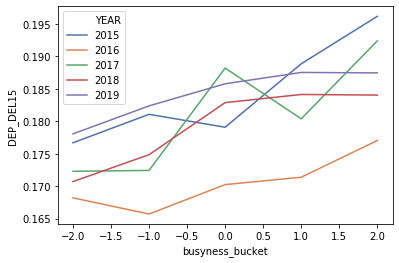

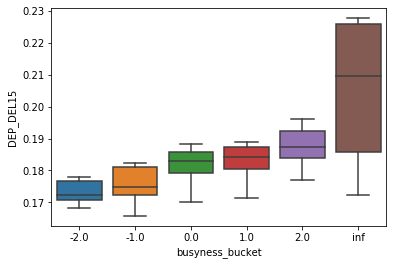

In [0]:
pd_df['busyness_bucket'] = pd.cut(pd_df.scheduled_busyness_normed, [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5, float("inf")]).apply(lambda x: (x.left + x.right) / 2)

busy = pd_df.groupby(['busyness_bucket', 'YEAR']).agg({'DEP_DEL15': np.mean}).reset_index()
sns.lineplot(data=busy, x='busyness_bucket', y="DEP_DEL15", hue="YEAR", palette="deep")
plt.show()
sns.boxplot(data=busy, x='busyness_bucket', y="DEP_DEL15")
plt.show()

Generally the busier an airport is at a given hour compared to the average flight volume, the rate of flights delayed increases. This pattern exists year over year.

# Weather Features

In [0]:
display(dbutils.fs.ls("dbfs:/mnt/mids-w261/datasets_final_project/weather_data"))

path name size dbfs:/mnt/mids-w261/datasets_final_project/weather_data/teamjvml1/ teamjvml1/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather-miss.parquet/ weather-miss.parquet/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2015a.parquet/ weather2015a.parquet/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2016a.parquet/ weather2016a.parquet/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2017a.parquet/ weather2017a.parquet/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2018a.parquet/ weather2018a.parquet/ 0 dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2019a.parquet/ weather2019a.parquet/ 0

In [0]:
weather = spark.read.option("header", "true")\
                    .parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather2015a.parquet")

In [0]:
weather.createOrReplaceTempView("weather")

## Weather Feature Symbols
[https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf]  
WND - WIND  
CIG - SKY CEILING  
VIS - VISIBILITY  
TMP - TEMPERATURE  
DEW - DEW TEMP  
SLP - PRESSURE  
AA1 - AA4 - PRECIP  
AJ1 - SNOW  
GE1 - sky obs - clouds  
GF1 - sky obs   

Inspecting raw feature formats

In [0]:
%sql
SELECT DATE, CALL_SIGN, WND, CIG, VIS, TMP, DEW, SLP, AA1, AA2, AA3, AA4, AJ1, GE1, GF1
FROM weather
WHERE trim(call_sign) = 'KORD' and report_type='FM-15' and length(AA2) > 1
ORDER BY DATE
LIMIT 10;

DATE CALL_SIGN WND CIG VIS TMP DEW SLP AA1 AA2 AA3 AA4 AJ1 GE1 GF1 2015-01-03T08:51:00.000+0000 KORD 130,5,N,0031,5 00762,5,M,N 002414,5,N,5 -0011,5 -0033,5 10200,5 01,0005,9,5 03,0005,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00762,1,99,9,99,9 2015-01-03T11:51:00.000+0000 KORD 130,5,N,0036,5 00152,5,M,N 004023,5,N,5 -0006,5 -0017,5 10162,5 01,0005,9,5 06,0023,9,1 24,0023,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00152,1,99,9,99,9 2015-01-03T14:51:00.000+0000 KORD 130,5,N,0036,5 00183,5,M,N 003219,5,N,5 +0006,5 -0006,5 10135,5 01,0003,9,5 03,0020,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00183,1,99,9,99,9 2015-01-03T17:51:00.000+0000 KORD 020,5,N,0021,5 00122,5,M,N 003219,5,N,5 +0006,5 +0000,5 10109,5 01,0013,9,5 06,0069,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00122,1,99,9,99,9 2015-01-03T20:51:00.000+0000 KORD 350,5,N,0015,5 00122,5,M,N 004828,5,N,5 +0011,5 +0000,5 10097,5 01,0005,9,5 03,0038,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00122,1,99,9,99,9 2015-01-03T23:51:00.000+0000 KORD 330,5,N,0026,5 00122,5,M,N 011265,5,N,5 +0006,5 +0000,5 10094,5 01,0000,2,5 06,0046,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00122,1,99,9,99,9 2015-01-04T02:51:00.000+0000 KORD 010,5,N,0036,5 00122,5,M,N 006437,5,N,5 +0006,5 +0000,5 10089,5 01,0000,2,5 03,0003,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00122,1,99,9,99,9 2015-01-04T05:51:00.000+0000 KORD 340,5,N,0026,5 00122,5,M,N 002414,5,N,5 +0006,5 +0000,5 10086,5 01,0005,9,5 06,0008,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00122,1,99,9,99,9 2015-01-04T08:51:00.000+0000 KORD 330,5,N,0051,5 00122,5,M,N 002414,5,N,5 +0006,5 -0006,5 10073,5 01,0005,9,5 03,0005,9,1 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00122,1,99,9,99,9 2015-01-04T11:51:00.000+0000 KORD 310,5,N,0046,5 00213,5,M,N 001207,5,N,5 +0000,5 -0011,5 10081,5 01,0008,9,5 06,0023,9,1 24,0145,9,1 0003,9,5,000250,9,9 9,AGL ,+99999,+99999 99,99,9,99,9,99,9,00213,1,99,9,99,9

Parsing each field into human understandable struct field

In [0]:
# parse wind fields
wind_schema = StructType([
    StructField("direction", FloatType(), False),
    StructField("dir_obs_quality", StringType(), False),
    StructField("type", StringType(), False),
    StructField("speed", FloatType(), False),
    StructField("quality", StringType(), False)
])

def wind(s):
    wind = s.split(',') if s else [float('nan'), None, None, float('nan'), None]
    wind[0], wind[3] = float(wind[0]), float(wind[3])
    return wind
  
# parse sky ceiling
# cavok = ceiling and visibility okay
ceiling_schema = StructType([
    StructField("height", FloatType(), False),
    StructField("quality", StringType(), False),
    StructField("determination", StringType(), False),
    StructField("cavok", StringType(), False)
]) 

def sky_ceiling(s):
    sky = s.split(',') if s else [float('nan'), None, None, None]
    sky[0] = float(sky[0])
    return sky
  
# parse visibility
visibility_schema = StructType([
    StructField("visibility", FloatType(), False),
    StructField("vis_obs_quality", StringType(), False),
    StructField("variability", StringType(), False),
    StructField("quality", StringType(), False)
]) 

def visibility(s):
    vis = s.split(',') if s else [float('nan'), None, None, None]
    vis[0] = float(vis[0])
    return vis

# just return the first measurement value as a float for [temperature, dew temp, pressure]
def first_value(s, sep=',', t=float):
    return t(s.split(sep)[0])

# precipitation
precipitation_schema = StructType([
    StructField("period", FloatType(), False),
    StructField("depth", FloatType(), False),
    StructField("condition", StringType(), False),
    StructField("quality", StringType(), False)
]) 
def precipitation(s):
    precip = s.split(',') if s else [-1, -1, '-1', '-1']
    precip[0], precip[1] = float(precip[0]), float(precip[1])
    return precip
  
# snow
snow_schema = StructType([
    StructField("depth", FloatType(), False),
    StructField("condition", StringType(), False),
    StructField("quality", StringType(), False),
    StructField("water_depth", StringType(), False)
]) 
def snow(s):
    snow = s.split(',')[:4] if s else [-1, '-1', '-1', -1]
    snow[0], snow[3] = float(snow[0]), float(snow[3])
    return snow

wind_udf = udf(wind, wind_schema)
sky_udf = udf(sky_ceiling, ceiling_schema)
vis_udf = udf(visibility, visibility_schema)
precip_udf = udf(precipitation, precipitation_schema)
snow_udf = udf(snow, snow_schema)
first_value_udf = udf(first_value, FloatType())

In [0]:
# if observation has missing quality code, get the last prior value
def lag_if_missing_quality_obs(df, parsed_column):
    window = Window.partitionBy(f.col("CALL_SIGN")).orderBy(f.col("DATE")).rowsBetween(Window.unboundedPreceding, 0)
    df = df.withColumn(parsed_column, 
                       f.when(f.col(parsed_column).quality == 9, None) \
                           .otherwise(f.col(parsed_column)))
    df = df.withColumn(parsed_column, f.last(f.col(parsed_column), ignorenulls=True).over(window))
    return df

def lag_if_missing_obs(df, parsed_column):
    window = Window.partitionBy(f.col("CALL_SIGN")).orderBy(f.col("DATE")).rowsBetween(Window.unboundedPreceding, Window.currentRow)

    df = df.withColumn(parsed_column, 
                       f.when(f.col(parsed_column).cast(IntegerType()) == 99999, None) \
                           .otherwise(f.col(parsed_column)))
    df = df.withColumn(parsed_column, f.last(f.col(parsed_column), ignorenulls=True).over(window))
    return df

In [0]:
# parse raw weather columns and fill in missing/poor quality observations with last good value
def parse_weather_columns(weather, base_columns):
    weather = weather.filter("report_type='FM-15' and substr(trim(call_sign), 1, 1)='K'")\
        .select(base_columns)\
        .withColumn("wind_parsed", wind_udf("WND"))\
        .withColumn("sky_ceiling_parsed", sky_udf("CIG"))\
        .withColumn("visibility_parsed", vis_udf("VIS"))\
        .withColumn("snow_parsed", snow_udf("aj1"))
    for c in ["wind_parsed", "sky_ceiling_parsed", "visibility_parsed", "snow_parsed"]:
        weather = lag_if_missing_quality_obs(weather, c)

    for c, name in [('TMP', 'temperature'), ('DEW', 'dew_temperature'), ('SLP', 'pressure')]:
        weather = weather.withColumn(name, first_value_udf(c))
        weather = lag_if_missing_obs(weather, name)

    for c in ['AA1', 'AA2', 'AA3', 'AA4']:
        weather = weather.withColumn(c+'_parsed', precip_udf(c))
    return weather

weather = parse_weather_columns(weather, base_columns)

In [0]:
base_columns = ['station', 'date', 'latitude', 'longitude', 'elevation', 'call_sign', 
                'wnd', 'cig', 'vis', 'tmp', 'dew', 'slp', 'aa1', 'aa2', 'aa3', 'aa4', 'aj1', 'ge1', 'gf1']
weather = parse_weather_columns(weather, base_columns)

In [0]:
# show that an invalid measurement properly gets previous hour's value
display(weather \
        .filter("date<='2015-02-11T19:51:00.000+0000' and trim(call_sign)='KORD'") \
        .orderBy(f.col('Date').desc()) \
        .select('station', 'date', 'slp', 'pressure') \
        .limit(5))

station date slp pressure 72530094846 2015-02-11T19:51:00.000+0000 99999,9 10162.0 72530094846 2015-02-11T18:51:00.000+0000 10162,5 10162.0 72530094846 2015-02-11T17:51:00.000+0000 10161,5 10161.0 72530094846 2015-02-11T16:51:00.000+0000 10160,5 10160.0 72530094846 2015-02-11T15:51:00.000+0000 10157,5 10157.0

In [0]:
# create a temp table to examine via sql syntax in addition to dataframe api
weather.createOrReplaceTempView("weather")

In [0]:
%sql
-- examine some of the values for various fields, for ceiling, most common is 22000, aka no ceiling
SELECT sky_ceiling_parsed.height, count(1)
FROM weather
GROUP BY sky_ceiling_parsed.height
ORDER BY count(1) desc

height count(1) 22000.0 19963517 null 401861 61.0 373643 1829.0 369652 91.0 336928 1524.0 331560 3353.0 328316 152.0 327983 183.0 318578 2134.0 303214 3048.0 300836 122.0 300152 213.0 290485 244.0 289219 2743.0 255944 305.0 244330 274.0 236750 2438.0 233188 366.0 215229 1981.0 211251 427.0 209791 30.0 206622 396.0 202940 457.0 194732 1676.0 194559 3658.0 193679 335.0 193355 488.0 182041 518.0 181633 2286.0 178161 549.0 164156 610.0 159182 579.0 157853 640.0 145703 671.0 141961 701.0 137955 762.0 136221 732.0 133782 2591.0 130334 792.0 127838 853.0 125178 914.0 124605 823.0 122175 884.0 121227 2896.0 115350 7620.0 114094 1067.0 112664 1036.0 108335 975.0 107658 1006.0 106003 1097.0 102824 1463.0 101262 945.0 98431 1158.0 97528 1128.0 96031 1219.0 95502 1372.0 95465 1402.0 91359 1189.0 89080 1280.0 87077 1341.0 84616 1250.0 83811 1311.0 79691 1433.0 79193 1494.0 77604 6096.0 43317 4572.0 31225 5486.0 16532 4267.0 15303 3962.0 13840 6706.0 13110 4877.0 10799 5182.0 8190 9144.0 8171 7010.0 6136 5791.0 5852 6401.0 5307 7315.0 5075 0.0 4973 8534.0 3530 7925.0 3260 8230.0 1410 8839.0 242 10668.0 154 9449.0 85 9754.0 83 10058.0 52 1707.0 27 1554.0 21 1585.0 18 10363.0 14 1615.0 12 1768.0 10 3505.0 7 3810.0 7 1646.0 6 4115.0 6 2.0 5 4.0 5 2225.0 5 1951.0 5 2256.0 4 2316.0 4 2073.0 4 2469.0 4 2621.0 3 9.0 3 3.0 3 1920.0 3 1859.0 3 4846.0 3 2195.0 3 5029.0 3 11278.0 2 2347.0 2 1890.0 2 6553.0 2 4724.0 2 11582.0 2 6980.0 2 5425.0 2 2012.0 2 4542.0 2 3292.0 2 3200.0 2 1737.0 2 5822.0 2 6949.0 1 6858.0 1 3261.0 1 2713.0 1 3536.0 1 4755.0 1 2377.0 1 5.0 1 13.0 1 11887.0 1 8809.0 1 7.0 1 2530.0 1 12832.0 1 3018.0 1 2682.0 1 3627.0 1 7681.0 1 12.0 1 3932.0 1 5944.0 1 3566.0 1 4206.0 1 15240.0 1 3749.0 1 11.0 1 2560.0 1 2804.0 1 6.0 1 7894.0 1 5121.0 1 3475.0 1 2408.0 1 4694.0 1

In [0]:
%sql
-- example of lag window function to get current obs and delta to t-1 and t-2
SELECT *
FROM (
SELECT 
  --date_trunc('HOUR', DATE) + INTERVAL 2 hours as join_datetime,
  date,
  trim(call_sign) as call_sign,
    
  -- wind
  wind_parsed,
  wind_parsed.speed as wind_speed,
  wind_parsed.speed - lag(wind_parsed.speed, 1) over (partition by call_sign order by date) as wind_speed_minus_1,
  wind_parsed.speed - lag(wind_parsed.speed, 2) over (partition by call_sign order by date) as wind_speed_minus_2,
  wind_parsed.speed - max(wind_parsed.speed) over (partition by call_sign order by date rows 2 preceding) as diff_to_max_wind
FROM weather
WHERE trim(call_sign) in ('KATL', 'KORD')
ORDER BY call_sign, date
LIMIT 10) WHERE wind_speed_minus_2 is not null and wind_speed != 0;

date call_sign wind_parsed wind_speed wind_speed_minus_1 wind_speed_minus_2 diff_to_max_wind 2015-01-01T03:52:00.000+0000 KATL List(320.0, 5, N, 26.0, 5) 26.0 26.0 5.0 0.0 2015-01-01T04:52:00.000+0000 KATL List(320.0, 5, N, 31.0, 5) 31.0 5.0 31.0 0.0 2015-01-01T05:52:00.000+0000 KATL List(330.0, 5, N, 21.0, 5) 21.0 -10.0 -5.0 -10.0 2015-01-01T06:52:00.000+0000 KATL List(320.0, 5, N, 31.0, 5) 31.0 10.0 0.0 0.0 2015-01-01T07:52:00.000+0000 KATL List(330.0, 5, N, 26.0, 5) 26.0 -5.0 5.0 -5.0 2015-01-01T09:52:00.000+0000 KATL List(330.0, 5, N, 36.0, 5) 36.0 36.0 10.0 0.0

In [0]:
def create_weather_features(weather_parsed, where_clause=""):
    """
    Creating weather features from parsed weather dataframe including lag features for most of weather observations
    Create join_datetime field which will be used to join with airlines data. This field is current hour + 2 hrs. 
    Thus for flight at hour t, the weather row for hour t-2 will be joined.
    """
    weather_parsed.createOrReplaceTempView("weather_parsed")
    weatherFeatures = spark.sql("""
        SELECT 
          date_trunc('HOUR', DATE) + INTERVAL 2 hours as join_datetime,
          date,
          trim(call_sign) as call_sign,

          -- wind
          wind_parsed.speed as wind_speed, 
          wind_parsed.direction as wind_direction,
          coalesce(wind_parsed.speed - lag(wind_parsed.speed, 1) over (partition by call_sign order by date), 0) as wind_speed_minus_1,
          coalesce(wind_parsed.speed - lag(wind_parsed.speed, 2) over (partition by call_sign order by date), 0) as wind_speed_minus_2,
          coalesce(wind_parsed.speed - max(wind_parsed.speed) over (partition by call_sign order by date rows 2 preceding), 0) as diff_to_max_wind,

          -- visibility
          visibility_parsed.visibility as visibility, 
          coalesce(visibility_parsed.visibility - lag(visibility_parsed.visibility, 1) over (partition by call_sign order by date), 0) as visibility_minus_1,
          coalesce(visibility_parsed.visibility - lag(visibility_parsed.visibility, 2) over (partition by call_sign order by date), 0) as visibility_minus_2,
          visibility_parsed.variability as visibility_variability,

          -- sky_ceiling
          sky_ceiling_parsed.height as ceiling, 
          coalesce(sky_ceiling_parsed.height - lag(sky_ceiling_parsed.height, 1) over (partition by call_sign order by date), 0) as ceiling_minus_1,
          coalesce(sky_ceiling_parsed.height - lag(sky_ceiling_parsed.height, 2) over (partition by call_sign order by date), 0) as ceiling_minus_2,
          sky_ceiling_parsed.cavok,

          -- snow
          snow_parsed.condition as snow_condition,
          snow_parsed.depth as snow_depth, 
          coalesce(snow_parsed.depth - lag(snow_parsed.depth, 1) over (partition by call_sign order by date), 0) as snow_depth_minus_1,
          coalesce(snow_parsed.depth - lag(snow_parsed.depth, 2) over (partition by call_sign order by date), 0) as snow_depth_minus_2,

          -- precipitation
          aa1_parsed.period as precip_period,
          aa1_parsed.depth as precip_depth,
          case when aa4_parsed.depth > 0 then aa4_parsed.depth
               when aa3_parsed.depth > 0 then aa3_parsed.depth
               when aa2_parsed.depth > 0 then aa2_parsed.depth
               else aa1_parsed.depth end as max_precip_depth,
          case when aa4_parsed.depth > 0 then aa4_parsed.period
               when aa3_parsed.depth > 0 then aa3_parsed.period
               when aa2_parsed.depth > 0 then aa2_parsed.period
               else aa1_parsed.period end as max_precip_period,

          -- pressure
          pressure,
          coalesce(pressure - lag(pressure, 1) over (partition by call_sign order by date), 0) as pressure_minus_1,
          coalesce(pressure - lag(pressure, 2) over (partition by call_sign order by date), 0) as pressure_minus_2,

          temperature,
          dew_temperature,
          latitude, 
          longitude, 
          elevation

        FROM weather_parsed
        {where_clause}
        ORDER BY call_sign, date;
        """.format(where_clause=where_clause))
    return weatherFeatures

In [0]:
weather_features = create_weather_features(weather, "WHERE trim(call_sign) in ('KATL', 'KORD')")
display(weather_features.take(20))

join_datetime date call_sign wind_speed wind_direction wind_speed_minus_1 wind_speed_minus_2 diff_to_max_wind visibility visibility_minus_1 visibility_minus_2 visibility_variability ceiling ceiling_minus_1 ceiling_minus_2 cavok snow_condition snow_depth snow_depth_minus_1 snow_depth_minus_2 precip_period precip_depth max_precip_depth max_precip_period pressure pressure_minus_1 pressure_minus_2 temperature dew_temperature latitude longitude elevation 2015-01-01T02:00:00.000+0000 2015-01-01T00:52:00.000+0000 KATL 26.0 330.0 0.0 0.0 0.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10289.0 0.0 0.0 50.0 6.0 33.6301 -84.4418 307.8 2015-01-01T03:00:00.000+0000 2015-01-01T01:52:00.000+0000 KATL 21.0 310.0 -5.0 0.0 -5.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10290.0 1.0 0.0 44.0 0.0 33.6301 -84.4418 307.8 2015-01-01T04:00:00.000+0000 2015-01-01T02:52:00.000+0000 KATL 0.0 999.0 -21.0 -26.0 -26.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10285.0 -5.0 -4.0 44.0 0.0 33.6301 -84.4418 307.8 2015-01-01T05:00:00.000+0000 2015-01-01T03:52:00.000+0000 KATL 26.0 320.0 26.0 5.0 0.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10289.0 4.0 -1.0 33.0 -6.0 33.6301 -84.4418 307.8 2015-01-01T06:00:00.000+0000 2015-01-01T04:52:00.000+0000 KATL 31.0 320.0 5.0 31.0 0.0 16093.0 0.0 0.0 N 6096.0 -15904.0 -15904.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10283.0 -6.0 -2.0 28.0 -11.0 33.6301 -84.4418 307.8 2015-01-01T07:00:00.000+0000 2015-01-01T05:52:00.000+0000 KATL 21.0 330.0 -10.0 -5.0 -10.0 16093.0 0.0 0.0 N 6096.0 0.0 -15904.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10280.0 -3.0 -9.0 28.0 -17.0 33.6301 -84.4418 307.8 2015-01-01T08:00:00.000+0000 2015-01-01T06:52:00.000+0000 KATL 31.0 320.0 10.0 0.0 0.0 16093.0 0.0 0.0 N 22000.0 15904.0 15904.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10281.0 1.0 -2.0 22.0 -17.0 33.6301 -84.4418 307.8 2015-01-01T09:00:00.000+0000 2015-01-01T07:52:00.000+0000 KATL 26.0 330.0 -5.0 5.0 -5.0 16093.0 0.0 0.0 N 22000.0 0.0 15904.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10280.0 -1.0 0.0 17.0 -22.0 33.6301 -84.4418 307.8 2015-01-01T10:00:00.000+0000 2015-01-01T08:52:00.000+0000 KATL 0.0 999.0 -26.0 -31.0 -31.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10274.0 -6.0 -7.0 17.0 -33.0 33.6301 -84.4418 307.8 2015-01-01T11:00:00.000+0000 2015-01-01T09:52:00.000+0000 KATL 36.0 330.0 36.0 10.0 0.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10270.0 -4.0 -10.0 11.0 -28.0 33.6301 -84.4418 307.8 2015-01-01T12:00:00.000+0000 2015-01-01T10:52:00.000+0000 KATL 15.0 310.0 -21.0 15.0 -21.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10268.0 -2.0 -6.0 6.0 -33.0 33.6301 -84.4418 307.8 2015-01-01T13:00:00.000+0000 2015-01-01T11:52:00.000+0000 KATL 31.0 310.0 16.0 -5.0 -5.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10276.0 8.0 6.0 0.0 -33.0 33.6301 -84.4418 307.8 2015-01-01T14:00:00.000+0000 2015-01-01T12:52:00.000+0000 KATL 0.0 999.0 -31.0 -15.0 -31.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10280.0 4.0 12.0 0.0 -33.0 33.6301 -84.4418 307.8 2015-01-01T15:00:00.000+0000 2015-01-01T13:52:00.000+0000 KATL 0.0 999.0 0.0 -31.0 -31.0 16093.0 0.0 0.0 N 22000.0 0.0 0.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10276.0 -4.0 0.0 28.0 -22.0 33.6301 -84.4418 307.8 2015-01-01T16:00:00.000+0000 2015-01-01T14:52:00.000+0000 KATL 0.0 999.0 0.0 0.0 0.0 16093.0 0.0 0.0 N 7620.0 -14380.0 -14380.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10280.0 4.0 0.0 61.0 -28.0 33.6301 -84.4418 307.8 2015-01-01T17:00:00.000+0000 2015-01-01T15:52:00.000+0000 KATL 21.0 310.0 21.0 21.0 0.0 16093.0 0.0 0.0 N 7010.0 -610.0 -14990.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10285.0 5.0 9.0 83.0 -28.0 33.6301 -84.4418 307.8 2015-01-01T18:00:00.000+0000 2015-01-01T16:52:00.000+0000 KATL 15.0 999.0 -6.0 15.0 -6.0 16093.0 0.0 0.0 N 7010.0 0.0 -610.0 N -1 -1.0 0.0 0.0 1.0 0.0 0.0 1.0 10270.0 -15.0 -10.0 100.0 -61.0 3

## Write Intermediate Stage - Weather
Small dataset on 2015 data

In [0]:
weather_features \
.write \
.mode(write_mode) \
.parquet(team_folder + "/weatherFeaturesSmall.parquet")

Full dataset 2015-2019

In [0]:
full_weather = spark.read.option("header", "true")\
                    .parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather201*a.parquet")
full_weather_parsed = parse_weather_columns(full_weather, base_columns)
full_weather_features = create_weather_features(full_weather_parsed, where_clause="")

In [0]:
full_weather_features \
.write \
.mode(write_mode) \
.parquet(team_folder + "/weatherFeaturesFullFinal.parquet")

# Join Datasets

## Small dataset
First working with the small dataset to enseure that joins produce the expected counts and schema

In [0]:
weatherFeatures = spark.read.option("header", "true").parquet(team_folder + "/weatherFeaturesSmall.parquet")
airlineFeatures = spark.read.option("header", "true").parquet(team_folder + "/airlineFeaturesSmall.parquet")

In [0]:
print(weatherFeatures.count())
print(airlineFeatures.count())

17512
156231

In [0]:
weatherFeatures.createOrReplaceTempView("weatherFeatures")
airlineFeatures.createOrReplaceTempView("airlineFeatures")

In [0]:
joined = spark.sql("""
  SELECT *
  FROM airlineFeatures a
  JOIN weatherFeatures w
    ON ('K'||a.origin) = w.call_sign
    AND a.scheduled_flight_hour_UTC = w.join_datetime;
""")

In [0]:
joined.count()

Out[44]: 156231

We do not observe any loss of flights in the small dataset containing just ATL and ORD

In [0]:
joined \
.write \
.mode(write_mode) \
.parquet(team_folder + "/joinedFeaturesSmall.parquet")

## Full Dataset
Join and intermediate write on the full joined dataset

In [0]:
weather_features_full = spark.read.option("header", "true").parquet(team_folder + "/weatherFeaturesFullFinal.parquet")
airline_features_full = spark.read.option("header", "true").parquet(team_folder + "/airlineFeaturesFullwAggregates.parquet")

In [0]:
airline_features_full.createOrReplaceTempView("airlineFeaturesFullTeam17")
weather_features_full.createOrReplaceTempView("weatherFeaturesFullTeam17")
weather_feature_names = [f"o.{c} as origin_{c}" for c in weather_features_full.columns]
weather_feature_names.extend([f"d.{c} as dest_{c}" for c in weather_features_full.columns])

joined_full = spark.sql("""
  SELECT a.*, {weather_columns}
  FROM airlineFeaturesFullTeam17 a
  JOIN weatherFeaturesFullTeam17 o
    ON ('K'||a.origin) = o.call_sign
    AND a.scheduled_flight_hour_UTC = o.join_datetime
  JOIN weatherFeaturesFullTeam17 d
    ON ('K'||a.dest) = d.call_sign
    AND a.scheduled_flight_hour_UTC = d.join_datetime;
""".format(weather_columns=", ".join(weather_feature_names))).cache()

In [0]:
print("airlines dataset has %d flights" % airline_features_full.count())
print("airlines dataset has %d distinct origins" % airline_features_full.select("origin").distinct().count())
print("joined dataset has %d flights" % joined_full.count())
print("joined dataset has %d distinct origins" % joined_full.select("origin").distinct().count())


airlines dataset has 31269336 flights
airlines dataset has 367 distinct origins
joined dataset has 29876708 flights
joined dataset has 324 distinct origins

All of the orgins that are not contained in the joined dataset are airports outside of the continental US including Alaska, Hawaii, U.S. Virgin Islands, American Samoa, etc or smaller regional airports  
The 43 missing airports only represent less than 4.5 percent of flights.
These are missing due to the fact that the IATA-->ICAO join does not match the conventional "K" + IATA = ICAO format for major airports in the continental U.S.

In [0]:
origins_in_join = set(joined_full.select("origin").distinct().collect())
[o for o in airline_features_full.select("origin").distinct().collect() if o not in origins_in_join]

Out[49]: [Row(origin='DLG'),
 Row(origin='PSE'),
 Row(origin='PPG'),
 Row(origin='PSG'),
 Row(origin='MQT'),
 Row(origin='SCC'),
 Row(origin='WRG'),
 Row(origin='SCE'),
 Row(origin='KTN'),
 Row(origin='OGS'),
 Row(origin='CDV'),
 Row(origin='SPN'),
 Row(origin='ADK'),
 Row(origin='LIH'),
 Row(origin='HNL'),
 Row(origin='GST'),
 Row(origin='SJU'),
 Row(origin='FAI'),
 Row(origin='ITO'),
 Row(origin='HHH'),
 Row(origin='OME'),
 Row(origin='USA'),
 Row(origin='BKG'),
 Row(origin='BRW'),
 Row(origin='FCA'),
 Row(origin='BET'),
 Row(origin='STX'),
 Row(origin='AZA'),
 Row(origin='AKN'),
 Row(origin='GUM'),
 Row(origin='BQN'),
 Row(origin='JNU'),
 Row(origin='KOA'),
 Row(origin='ADQ'),
 Row(origin='YUM'),
 Row(origin='SIT'),
 Row(origin='OTZ'),
 Row(origin='YAK'),
 Row(origin='ANC'),
 Row(origin='OGG'),
 Row(origin='STT'),
 Row(origin='CLD'),
 Row(origin='UST')]

In [0]:
joined_full \
.write \
.mode(write_mode) \
.parquet(team_folder + "/joinedFeaturesFullFinal.parquet")

# Cluster Airlines By Lat, Long

In [0]:
joined_features_full = spark.read.option("header", "true").parquet(team_folder + "/joinedFeaturesFullFinal.parquet")

In [0]:
origin_lat_long = joined_features_full.select(f.col("origin").alias("airport_code"), f.col("origin_latitude").alias("latitude"), f.col("origin_longitude").alias("longitude")).distinct()
dest_lat_long = joined_features_full.select(f.col("dest").alias("airport_code"), f.col("dest_latitude").alias("latitude"), f.col("dest_longitude").alias("longitude")).distinct()

airport_lat_long = origin_lat_long.unionByName(dest_lat_long).toPandas()

## K Means
While not necessarily appropriate for geographical distances, kmeans algorithm produces a natural clustering that corresponds to human understanding of US regions and weather patterns

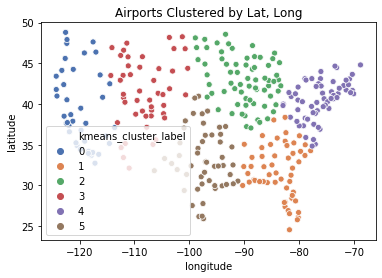

In [0]:
airport_lat_long['kmeans_cluster_label'] = KMeans(n_clusters=6, random_state=0).fit_predict(airport_lat_long[['latitude', 'longitude']])

sns.scatterplot(data=airport_lat_long, x='longitude', y='latitude', hue='kmeans_cluster_label', palette="deep")
plt.title("Airports Clustered by Lat, Long")
plt.show()

## DBSCAN
Using dbscan uses unsupervised density based clustering that does not require a pre-specified number of clusters. This algorithm can utilize proper geographic distances however it does not produce natural clusters and the central and eastern regions of the country stay grouped together

In [0]:
# https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
kms_per_radian = 6371.0088
epsilon = 225 / kms_per_radian
coords = airport_lat_long[['latitude', 'longitude']]
db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
airport_lat_long['dbscan_cluster_label'] = cluster_labels
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 5

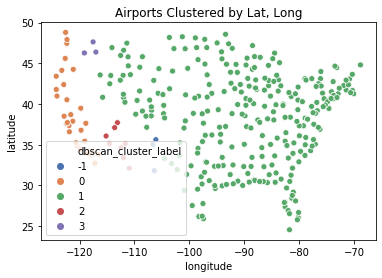

In [0]:
sns.scatterplot(data=airport_lat_long, x='longitude', y='latitude', hue='dbscan_cluster_label', palette="deep")
plt.title("Airports Clustered by Lat, Long")
plt.show()

## Cluster Airports with K Means (6)

In [0]:
def cluster_airports(data):
    origin_lat_long = data.select(f.col("origin").alias("airport_code"), f.col("origin_latitude").alias("latitude"), f.col("origin_longitude").alias("longitude")).distinct()
    dest_lat_long = data.select(f.col("dest").alias("airport_code"), f.col("dest_latitude").alias("latitude"), f.col("dest_longitude").alias("longitude")).distinct()
    airport_lat_long = origin_lat_long.unionByName(dest_lat_long).distinct().toPandas()

    # fit kmeans(6) to airport (lat,long)s and add labels to dataframe
    airport_lat_long['kmeans_cluster_label'] = KMeans(n_clusters=min(6, airport_lat_long.shape[0]), random_state=0).fit_predict(airport_lat_long[['latitude', 'longitude']])
    airport_regions = spark.createDataFrame(airport_lat_long[['airport_code', 'kmeans_cluster_label']].drop_duplicates())

    data = data.join(f.broadcast(airport_regions), f.col('ORIGIN') == f.col('airport_code')) \
        .withColumnRenamed('kmeans_cluster_label', 'origin_region') \
        .drop('airport_code')

    data = data.join(f.broadcast(airport_regions), f.col('DEST') == f.col('airport_code')) \
        .withColumnRenamed('kmeans_cluster_label', 'dest_region') \
        .drop('airport_code')
    
    data = data.withColumn("intra_region", (f.col("origin_region") == f.col("dest_region")).cast(IntegerType()))
    return data

Out[66]:

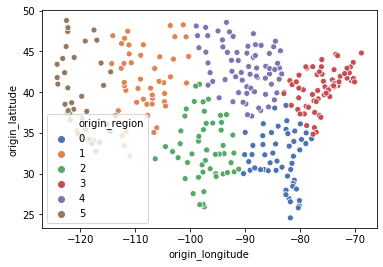

<matplotlib.axes._subplots.AxesSubplot at 0x7fdeb00174d0>

In [0]:
joined_features_w_airport_clusters = cluster_airports(joined_features_full)

region_lat_lon = joined_features_w_airport_clusters.select("origin_region", "origin_latitude", "origin_longitude").distinct().toPandas()
sns.scatterplot(data=region_lat_lon, x='origin_longitude', y='origin_latitude', hue="origin_region", palette="deep")

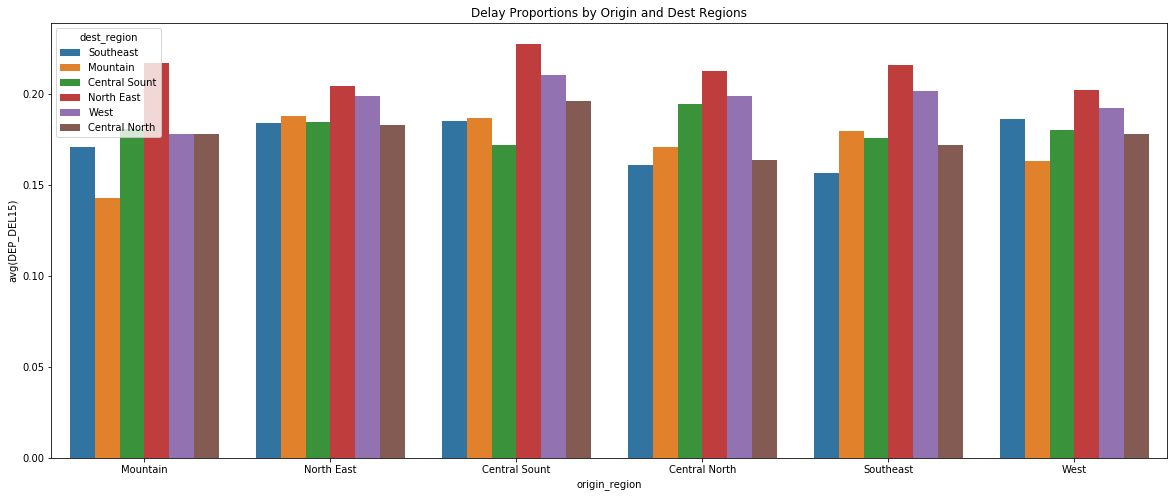

In [0]:
delays_by_region = joined_features_w_airport_clusters.groupBy("origin_region", "dest_region").mean("DEP_DEL15", "origin_latitude", "origin_longitude").toPandas()

# these region codes are non deterministic based on the random cluster labels given by kmeans, based on execution on 12/10
region_dict = {0: 'Southeast', 1: 'Mountain', 2: "Central Sount", 3: "North East", 4: "Central North", 5: "West"}
delays_by_region['origin_region'] = delays_by_region['origin_region'].apply(lambda x: region_dict.get(x))
delays_by_region['dest_region'] = delays_by_region['dest_region'].apply(lambda x: region_dict.get(x))

plt.figure(figsize=(20, 8))
sns.barplot(data=delays_by_region, x="origin_region", y="avg(DEP_DEL15)", hue="dest_region")
plt.title("Delay Proportions by Origin and Dest Regions")
plt.show()

Seen in the above figure, generally flights to the Northeast and West have the highest proportion of flight delays compared to flying to the other regions. Additionally, flights that are intra region in the South East and Central North are notably lower.

In [0]:
joined_features_w_airport_clusters \
  .write \
  .mode(write_mode) \
  .parquet(team_folder + "/joinedFeaturesFullClusteredFinal.parquet")

# Algorithm Theory
Toy learning problem comparing GBT and Logistic Regression[https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/2834511320032702/command/2834511320032703]. This notebook provides a small coded example of linear decision boundary limitations compared to GBT learning potential.

We will experiment with different model algorithms, primarily Gradient Boosted Trees, Random Forests, and Logistic Regression.
Logistic regression, like its regression counterpart have some strong assumptions of linear transformations, feature independence, and approximate normal distributions that make this algorithm not the most appropriate for the problem at hand. As discussed by the [Bureau of Transportation Statistics](https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations), reasons for cancellation are often not exclusive and independent of one another, for instance bad weather contributes to previously late aircrafts and traffic control delays as other flights get off schedule.

With these factors considered, tree based models that do not require such assumptions of feature independence and instead continue splitting on such conditional distributions seem more appropriate to capture the approximate information gain found in each feature. 

Gradient Boosted Trees generally follow these steps:
 - Step 1: Initialize log(odds)
   - Odds = positive examples / negative examples
 - Step 2a: Compute the residuals for each row in your dataset
   - Probability = e^log(odds) / (1 + e^(log(odds))
   - Residual = true label - probability
 - Step 2b: Fit your current tree to the residual values
 - Step 2c: Compute leaf nodes based on your tree splits
   - Summed over each of the i data points in the leaf node
 - Step 2d: Compute next residual for the next tree
   - New log(odds) = Current Residual + (Learning Rate * leaf node value for current data point)
   - Convert new log(odds) to probability
   - Next Residual = true label - new probability
 - Continue Steps 2a - 2d to generate all trees
 - Step 3: produce final prediction for data point x
 
 *additionally see presentation for small example with calculations*

# Model Implementation

## Utility methods and metrics calculations for models

### Data splits
The following methods minimize data leakage between groups by ensuring each group of date and airport cluster are exclusive to one of train, val, and test splits.  
**Motivation**: prevent leakage across groups learning intraday events such as holiday rushes and/or extreme weather events affecting a region. Splitting on date alone, may cause unnecessarily high variance since annual holidays, such as Thanksgiving and Christmas, may not distribute across splits since there are only 4 years of data. By adding the region dimension, we increase the probability of holidays appropriately spreading across data splits while minimizing leakage of same-day weather events (e.g. blizzard in Chicago affects ORD and MDW).

In [0]:
def split_by_date_and_region(data, datecolumn='FL_DATE', region="origin_region", splits=[0.8,0.1,0.1], drop_date=True):
    def hashAndAssign(x, splits):
        hash_val = hash(x)
        perc = (hash_val % 1000) / 1000.0
        for i, split in enumerate(splits):
            if perc < split:
                return i
            perc -= split
        return i
    hash_and_assign_udf = f.udf(lambda x: hashAndAssign(x, splits), IntegerType())
  
    data = data.withColumn('data_group', hash_and_assign_udf(f.concat_ws('_',f.col(datecolumn),f.col(region))))
    if drop_date:
        data = data.drop(datecolumn)
    return data


def split_data_by_column(data, col_name="data_group", verbose=False):
    train = data.filter(f.col(col_name) == 0)
    valid = data.filter(f.col(col_name) == 1)
    test = data.filter(f.col(col_name) == 2)
    if verbose:
        group_counts = data.groupBy(f.col(col_name)).count().collect()
        group_counts = {g.data_group: g['count'] for g in group_counts}
        print(f"train size: {group_counts[0]}")
        print(f"validation size: {group_counts[1]}")
        print(f"test size: {group_counts[2]}")
    return train, valid, test

### TrainingValidation Pipeline Subclass
`pyspark.ml.tuning.TrainValidationSplit` only accepts a train ratio and then randomly splits the data into train and validation data. As mentioned above, we wish to provide a custom sampling method and thus need to be able to pass in the predefined splits directly to the object instantiation

In [0]:
class CustomTrainValidationSplit(TrainValidationSplit):
    """
    custom train validation tuning for model params
    accounts for custom split logic and will only train a feature pipe (number of categories, impute values, etc) once to be used with all model params
    """
    def __init__(self, estimator=None, featureTransformation=None, estimatorParamMaps=None, 
               evaluator=None, parallelism=1, 
               collectSubModels=False, seed=None, save_path=None):
        super(CustomTrainValidationSplit, self).__init__(estimator=estimator, estimatorParamMaps=estimatorParamMaps, 
                                                         evaluator=evaluator, trainRatio=1, parallelism=parallelism, 
                                                         collectSubModels=collectSubModels, seed=seed)
        self.featureTransformation = featureTransformation
        self.save_path = save_path

    def _fit(self, dataset):
        est = self.getOrDefault(self.estimator)
        epm = self.getOrDefault(self.estimatorParamMaps)
        numModels = len(epm)
        eva = self.getOrDefault(self.evaluator)
        train, validation, _ = split_data_by_column(dataset, "data_group")
        
        # only fit and train the feature transformation once, no need to do it for each set of model params
        self.featureTransformation = self.featureTransformation.fit(train)
        train = self.featureTransformation.transform(train).cache()
        validation = self.featureTransformation.transform(validation).cache()

        subModels = None
        collectSubModelsParam = self.getCollectSubModels()
        if collectSubModelsParam:
            subModels = [None for i in range(numModels)]

        tasks = _parallelFitTasks(est, train, eva, validation, epm, collectSubModelsParam)
        pool = ThreadPool(processes=min(self.getParallelism(), numModels))
        metrics = [None] * numModels
        for j, metric, subModel in pool.imap_unordered(lambda f: f(), tasks):
            metrics[j] = metric
            print("****"*5)
            print({p.name: v for p, v in epm[j].items()})
            print(metrics[j])
            if collectSubModelsParam:
                subModels[j] = subModel
                if self.save_path:
                    print(f"saving checkpoint to {self.save_path + '_' + str(j)}")
                    subModel.write().overwrite().save(self.save_path + '_' + str(j))

        if eva.isLargerBetter():
            bestIndex = np.argmax(metrics)
        else:
            bestIndex = np.argmin(metrics)

        if collectSubModelsParam:
            bestModel = subModels[bestIndex]
        else:
            bestModel = est.fit(train, epm[bestIndex])
        # return best model with best set of model params based on the evaluation metric
        bestModel = Pipeline(stages=[self.featureTransformation, bestModel])

        train.unpersist()
        validation.unpersist()

        print('Best Model: ', epm[bestIndex], 'Detailed Score {}'.format(metrics[bestIndex]))
        return self._copyValues(TrainValidationSplitModel(bestModel, metrics, subModels))


### Feature Transformation Pipelines

In [0]:
def impute_missing_values(numerical_cols):
    """
    # impute median for missing numerical features
    """
    imputed_cols_name = [f"impute_{c}" for c in numerical_cols]
    median_imputer = Imputer(strategy="median", inputCols=numerical_cols, outputCols=imputed_cols_name)
    return (median_imputer, imputed_cols_name) 

            
def categorical_feature_transformations_linear(onehot_cols, hash_cols):
    """
    perform feature transformations necessary for categorical features in a linear model
    hashing and/or one-hot encoding
    """
    # hash encode categorical features with high cardinality
    hasher = FeatureHasher(numFeatures=400, inputCols=hash_cols, outputCol="hashFeatures")

    # one hot encode features with low cardinality
    onehotIndexers = []
    onehotInputs = []
    onehotFeatures = []
    for c in onehot_cols:
        indexer = StringIndexer(inputCol=c, outputCol=f"{c}_indexed")
        onehotIndexers.append(indexer)
        onehotInputs.append(indexer.getOutputCol())
        onehotFeatures.append(f"{c}_onehot")
    one_hot = OneHotEncoder(inputCols=onehotInputs, outputCols=onehotFeatures)
  
    # return output columns and transformation objects
    return ["hashFeatures"] + onehotFeatures, onehotIndexers + [one_hot, hasher]

def categorical_feature_transformations_trees(cols):
    # simply index all categories
    indexers = []
    features = []
    for c in cols:
        indexer = StringIndexer(inputCol=c, outputCol=f"{c}_indexed")
        indexers.append(indexer)
        features.append(f"{c}_indexed")

    # return output columns and transformation objects
    return features, indexers

# function to convert df into consumable format for MLlib for tree based models
def tree_feature_transformation_pipeline(numerical_cols, onehot_cols, hash_cols, output):
    pipeline_stages = []
    # normalize numerical columns
    median_imputer, imputed_cols = impute_missing_values(numerical_cols)
    num_assembler = VectorAssembler(inputCols=imputed_cols, outputCol="numericalFeatures")
    pipeline_stages.extend([median_imputer, num_assembler])

    # if tree based model, don't need to transform categorical features, just index
    catFeatureCols, catStages = categorical_feature_transformations_trees(onehot_cols + [c for c, n in hash_cols])

    pipeline_stages.extend(catStages)

    # combine all feature transformations into a single feature vector
    assembler = VectorAssembler(inputCols=["numericalFeatures"] + catFeatureCols, outputCol="features")
    pipeline_stages.append(assembler)
    pipeline = Pipeline(stages=pipeline_stages)
    return pipeline

# function to convert df into consumable format for MLlib for linear models
def linear_feature_transformation_pipeline(numerical_cols, onehot_cols, hash_cols, output, interact=False):
    # normalize and normalize numerical columns
    median_imputer, imputed_cols = impute_missing_values(numerical_cols)

    # transform_categorical should be true if model requires vectorization of categorical feature, e.g. Linear Regression
    catFeatureCols, catStages = categorical_feature_transformations_linear(onehot_cols, hash_cols)
    pipe1 = Pipeline(stages=[median_imputer] + catStages)
    
    pipe2_stages = []
    interactions = []
    interaction_cols = []
    if interact:
        for a, b in combinations(imputed_cols + [c for c in catFeatureCols if c.endswith('_indexed')], 2):
            interactions.append(Interaction(inputCols=[a, b], outputCol="{}_{}".format(a,b)))
            interaction_cols.append("{}_{}".format(a,b))
        pipe2_stages.extend(interactions)
        
    num_assembler = VectorAssembler(inputCols=imputed_cols+interaction_cols, outputCol="numericalFeatures")
    normalizer = Normalizer(inputCol="numericalFeatures", outputCol="normFeatures")
    pipe2_stages.extend([num_assembler, normalizer])

    # combine all feature transformations into a single feature vector
    assembler = VectorAssembler(inputCols=["normFeatures"] + catFeatureCols, outputCol="features")
    pipe2_stages.append(assembler)
    
    pipe2 = Pipeline(stages=pipe2_stages)
    pipeline = Pipeline(stages=[pipe1, pipe2])
    return pipeline

# select desired feature columns and split into Train, Val, Test sets based on date and region
def select_and_split_data(df, numerical_cols, onehot_cols, hash_cols, output, splits=[0.8,0.1,0.1], seed=0, verbose=False):
    tmp = df[numerical_cols + onehot_cols + hash_cols + [output, "FL_DATE"]]
    if verbose:
        print(f"total data: {tmp.count()}")
    tmp = tmp.dropna(subset=output)
    data = split_by_date_and_region(tmp, 
                                    datecolumn="FL_DATE", 
                                    region="origin_region" if "origin_region" in tmp.columns else "origin",
                                    splits=splits)
    return split_data_by_column(data, "data_group", verbose=verbose)


def balance_classes(dataset, output_col, ratio=None, seed=2020):
    ones = dataset.where(f.col(output_col)==1)
    zeroes = dataset.where(f.col(output_col)==0)
    if not ratio:
        ratio = zeroes.count() / ones.count()
    ones.union(ones.sample(True, ratio-1, seed=seed))
    train_final = zeroes.union(ones)
    return train_final

### Classification Utilities and Evaluations

In [0]:
#regression to classification with sigmoid activation
def sigmoid(logit):
    return 1 / (1 + math.exp(-logit))
sigmoid_udf = f.udf(sigmoid, FloatType())

def logloss(yp, yt):
    return (yt*np.log(yp) + (1 - yt)*np.log(1 - yp))
      
def ith_(v, i):
    try:
        return float(v[i])
    except ValueError:
        return None
extract_prob_udf = udf(lambda v: ith_(v, 1), DoubleType())

def format_predictions(predictions_df, output_col='DEP_DEL15'):
    #if regression based model, transform prediction with sigmoid and create label
    if not hasattr(predictions_df, 'probability'): 
        print("regression")
        predictions_df = predictions_df \
            .withColumn("label", (f.col(output_col) >= 15).cast(FloatType())) \
            .withColumn("delay_prob", sigmoid_udf(f.col("prediction") - 14.5))
    else:
        print("classification")
        predictions_df = predictions_df \
            .withColumn("label", (f.col(output_col)).cast(FloatType())) \
            .withColumn("delay_prob", extract_prob_udf("probability"))
    return predictions_df

from collections import namedtuple
ConfusionMatrix = namedtuple('ConfusionMatrix', ['TP', 'FP', 'TN', 'FN'])

def accuracy(confusion):
    return (confusion.TP + confusion.TN) / sum(confusion)

def accuracy_of_common_class_prediction(confusion):
    pos_class_prediction_accuracy = (confusion.TP + confusion.FN) / sum(confusion)
    return max(pos_class_prediction_accuracy, 1-pos_class_prediction_accuracy)

def precision(confusion):
    try:
        return (confusion.TP) / (confusion.TP + confusion.FP)
    except ZeroDivisionError:
        return float('nan')

def recall(confusion):
    return (confusion.TP) / (confusion.TP + confusion.FN)

def f1_score(confusion):
    try:
        prec = precision(confusion)
        rec = recall(confusion)
        return 2 * (prec * rec) / (prec + rec)
    except ZeroDivisionError:
        return float('nan')

def fp_rate(confusion):
    return (confusion.FP) / (confusion.FP + confusion.TN)

def categorize_prediction(pred, true):
    # [TP, FP, TN, FN]
    confusion = [0, 0, 0, 0]
    if pred == 1 and true == 1:
        confusion[0] = 1
    elif pred == 1 and true == 0:
        confusion[1] = 1
    elif pred == 0 and true == 0:
        confusion[2] = 1
    else:
        confusion[3] = 1
    return confusion

confusion_udf = f.udf(categorize_prediction, IntegerType())

def calc_metrics_at_thresh(df, prediction='probability', outcome='label', thresh=0.5, verbose=True):
    print("calculating metrics @ {} threshold".format(thresh))
    df = df.withColumn('prediction_at_thresh', (f.col(prediction) >= thresh).cast(IntegerType()))

    confusion = df.select(["prediction_at_thresh", outcome]).rdd \
        .map(lambda pred_truth: categorize_prediction(pred_truth[0], pred_truth[1])) \
        .reduce(lambda x, y: [sum(z) for z in zip(x, y)])
    confusion_matrix = ConfusionMatrix(*confusion)
    print(confusion_matrix)

    acc = accuracy(confusion_matrix)
    prec = precision(confusion_matrix)
    rec = recall(confusion_matrix)
    f1 = f1_score(confusion_matrix)

    if verbose:
        print("predicting frequent class would yield {:.4f} accuaracy".format(accuracy_of_common_class_prediction(confusion_matrix)))
        print(confusion_matrix)
        print("accuracy: {:.4f}".format(acc))
        print("precision: {:.4f}".format(prec))
        print("recall: {:.4f}".format(rec))
        print("f1: {:.4f}".format(f1))
    metrics = {'confusion_matrix': confusion_matrix, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}
    return metrics

def confusion_by_thresh(df, prediction='probability', outcome='label'):
    """
    calculate confusion matrices at multiple thresholds all in spark using rdd flatmap to create (thresh, (prediction, label)) pairs
    categorize predictions at thresh then reduceByKey before collecting
    
    this reduces collection from millions of rows to couple hundred
    """
    confusion_matrices = df.select(prediction, outcome).rdd \
        .flatMap(lambda x: [(thresh, categorize_prediction(x[0]>=thresh, x[1])) for thresh in np.arange(0, 1, 0.005)]) \
        .reduceByKey(lambda x, y: [sum(z) for z in zip(x, y)]) \
        .mapValues(lambda x: ConfusionMatrix(*x)) \
        .collect()

    confusion_df = pd.DataFrame(confusion_matrices, columns=["threshold", "confusion"])
    confusion_df['accuracy'] = confusion_df["confusion"].apply(lambda x: accuracy(x))
    confusion_df['precision'] = confusion_df["confusion"].apply(lambda x: precision(x))
    confusion_df['recall'] = confusion_df["confusion"].apply(lambda x: recall(x))
    confusion_df['f1'] = confusion_df["confusion"].apply(lambda x: f1_score(x))
    return confusion_df


def evaluate_and_get_metrics(predictions, output_col="label", verbose=True):
    #calculate classification metrics
    binary_metrics = BinaryClassificationMetrics(predictions.select(["delay_prob", "label"]).rdd)

    metrics = calc_metrics_at_thresh(predictions, prediction='delay_prob', outcome=output_col, thresh=0.5, verbose=False)
    metrics['ROC_AUC'] = binary_metrics.areaUnderROC
    metrics['PR_AUC'] = binary_metrics.areaUnderPR
    if verbose:
        print(metrics)
    return metrics

### following plotting functions never collect large amount of prediction/labels to create curve. Generate curves based on series of confusion matrices at various thresholds
def plot_pr_curve(confusion_by_thresh_list, labels=None):
    plt.figure(num=None, figsize=(6, 6))
    for i, confusion_by_thresh in enumerate(confusion_by_thresh_list):
        greater_than_min = confusion_by_thresh['confusion'].apply(lambda x: (x.TP + x.FP) > 0)
        less_than_max = confusion_by_thresh['confusion'].apply(lambda x: (x.TN + x.FN) > 0)
        confusion_in_range = confusion_by_thresh[greater_than_min & less_than_max]
        prec_rec = confusion_in_range[['precision', 'recall']].dropna().sort_values('recall')
        sns.lineplot(data=prec_rec, x='recall', y='precision', label=labels[i] if labels else None)
    plt.title('Precision-Recall')
    plt.legend()
    plt.show()
    
def plot_roc_curve(confusion_by_thresh_list, labels=None):
    plt.figure(num=None, figsize=(6, 6))
    for i, confusion_by_thresh in enumerate(confusion_by_thresh_list):
        confusion_by_thresh['tpr'] = confusion_by_thresh['recall']
        confusion_by_thresh['fpr'] = confusion_by_thresh['confusion'].apply(fp_rate)
        fpr_tpr = confusion_by_thresh[['fpr', 'tpr']].dropna().sort_values('fpr')
        sns.lineplot(data=fpr_tpr, x='fpr', y='tpr', label=labels[i] if labels else None)
    plt.plot([0, 1], [0, 1], linestyle='--')    
    plt.title('ROC')
    plt.legend()
    plt.show()

def plot_predictions_by_label(predictions, prediction='probability', outcome='label', fractions={0: 0.005, 1: 0.001}):
    sampled = predictions.sampleBy(outcome, fractions=fractions, seed=0).select(prediction, outcome).toPandas()
    sns.distplot(sampled[prediction][sampled[outcome]==0], label="Label=0")
    sns.distplot(sampled[prediction][sampled[outcome]==1], label="Label=1")
    plt.xlabel("predictions")
    plt.xlim(0, 1)
    plt.legend()
    plt.show()
    


### Explainability & Interpretability

In [0]:
# extract feature importance and map back to original names using column metadata
def ExtractFeatureImp(featureImp, dataset, featuresCol, numericalFeatures):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    
    def get_norm_var_name(x):
        if x.startswith("normFeatures_"):
            i = int(x.split('_')[-1])
            return numericalFeatures[i]
        elif x.startswith("numericalFeatures_"):
            return x.replace("numericalFeatures_", "").replace("impute_", "")
        return x
    
    varlist['feature_name'] = varlist['name'].apply(get_norm_var_name)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

## Metrics
**Choice of metric for evaluation**
Traditional classification metrics for model evaluation include ROC AUC and PR AUC. These two metrics have tradeoffs and choice between them depends on model application. In the case of flight delay detection, we propose the following use cases for each metric :  
 - ROC AUC: Industry use, metric balances detecting potentially delayed flights that there may be some action taken to help if possible, while minimizing the false positive rate that would cause unnecessary operational cost if the plane is actually going to depart ontime.
 - PrecisionRecall AUC: Consumer use, metric again promotes recall, the detection of delays; however, more directly penalizes when precision decreases. A decrease in precision would correlate to more false positives among all the flights characterized as probably going to be delayed. This would be directly detrimental to a consumer application of this model as one could miss a flight thinking they had more time to get to their airport/gate if notified that their flight was going to be delayed.  
 
Given that our proposed use case is to aid the operational side of air traffic and address potential delays, ROC AUC is the appropriate metric that we will optimize for in modeling.

## 1. Baseline model
Trained on 2015 3 month data for only ORD and ATL

In [0]:
joined = spark.read.option("header", "true").parquet(team_folder + "/joinedFeaturesSmall.parquet")

In [0]:
model_type = DecisionTreeClassifier
feature_transformation_pipeline = tree_feature_transformation_pipeline

#baseline model
numerical_cols = ['wind_speed', 'wind_speed_minus_1', 'wind_speed_minus_2', 'diff_to_max_wind',
                  'visibility', 'visibility_minus_1', 'visibility_minus_2',
                  'ceiling', 'ceiling_minus_1', 'ceiling_minus_2',
                  'snow_depth', 'snow_depth_minus_1', 'snow_depth_minus_2',
                  'precip_period', 'precip_depth', 'max_precip_period', 'max_precip_depth',
                  'pressure', 'pressure_minus_1', 'pressure_minus_2', 
                  'temperature', 'dew_temperature', 'latitude', 'longitude',
                  'elevation', 'tail_num_arrival_to_next_departure_delta', 'distance_group']
onehot_cols = ['origin', 'dest', 'op_unique_carrier',] # only one value for small ord and atl dataset ['snow_condition', 'visibility_variability']
hash_cols = []
output_col = 'label'

data = joined.withColumnRenamed("DEP_DEL15", output_col)
train, valid, test = select_and_split_data(data, numerical_cols, onehot_cols, hash_cols, output=output_col, splits=[0.8, 0.1, 0.1], seed=0, verbose=False)
pipe = feature_transformation_pipeline(numerical_cols, onehot_cols, hash_cols, output=output_col)

train = balance_classes(train, output_col=output_col)

train.cache()
valid.cache()
test.cache()

Out[76]: DataFrame[wind_speed: float, wind_speed_minus_1: float, wind_speed_minus_2: float, diff_to_max_wind: float, visibility: float, visibility_minus_1: float, visibility_minus_2: float, ceiling: float, ceiling_minus_1: float, ceiling_minus_2: float, snow_depth: float, snow_depth_minus_1: float, snow_depth_minus_2: float, precip_period: float, precip_depth: float, max_precip_period: float, max_precip_depth: float, pressure: float, pressure_minus_1: float, pressure_minus_2: float, temperature: float, dew_temperature: float, latitude: double, longitude: double, elevation: double, tail_num_arrival_to_next_departure_delta: double, distance_group: int, origin: string, dest: string, op_unique_carrier: string, label: double, data_group: int]

In [0]:
#train and test model
baseline_model = Pipeline(stages = [pipe, model_type(featuresCol= 'features', labelCol=output_col, maxDepth=15, maxBins=192)])

print("fitting model")
baseline_model = baseline_model.fit(train)

print("calculating predictions")
predictions = baseline_model.transform(valid)
predictions = format_predictions(predictions,output_col=output_col)

#calculate classification metrics
metrics = BinaryClassificationMetrics(predictions.select(["delay_prob", "label"]).rdd)
print("PR AUC: {}".format(metrics.areaUnderPR))
print("ROC AUC: {}".format(metrics.areaUnderROC))

calc_metrics_at_thresh(predictions, prediction='delay_prob', outcome=output_col, thresh=0.5, verbose=True)

fitting model
calculating predictions
classification
PR AUC: 0.4692142209782811
ROC AUC: 0.6812639298417773
ConfusionMatrix(TP=1649, FP=1220, TN=10912, FN=2149)
predicting frequent class would yield 0.7616 accuaracy
ConfusionMatrix(TP=1649, FP=1220, TN=10912, FN=2149)
accuracy: 0.7885
precision: 0.5748
recall: 0.4342
f1: 0.4947
Out[216]: {'confusion_matrix': ConfusionMatrix(TP=1649, FP=1220, TN=10912, FN=2149),
 'accuracy': 0.7885122410546139,
 'precision': 0.5747647263855001,
 'recall': 0.43417588204318064,
 'f1': 0.49467526623668817}

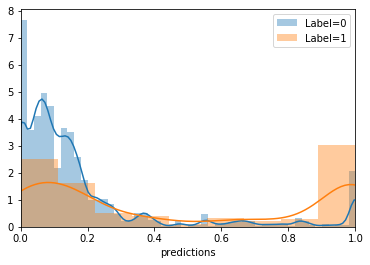

In [0]:
plot_predictions_by_label(predictions, fractions={0: 1, 1: 1}, prediction='delay_prob', outcome='label')

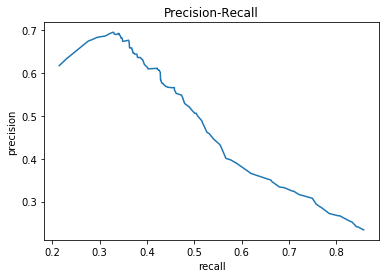

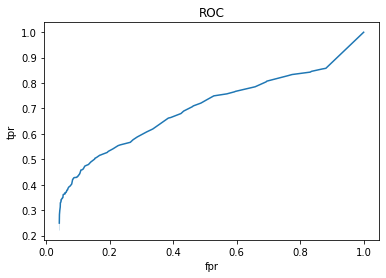

In [0]:
confusions = confusion_by_thresh(predictions, prediction='delay_prob', outcome='label')
plot_pr_curve(confusions)
plot_roc_curve(confusions)

## 2. TrainVal Tuning on Full Dataset - v1 Features
### Stage Training, Validation, Test datasets
balance and shuffle dataset for future model training so this does not have to be done each time

In [0]:
numerical_cols = ['origin_wind_speed', 'origin_wind_speed_minus_1', 'origin_wind_speed_minus_2', 'origin_diff_to_max_wind',
                  'origin_visibility', 'origin_visibility_minus_1', 'origin_visibility_minus_2',
                  'origin_ceiling', 'origin_ceiling_minus_1', 'origin_ceiling_minus_2',
                  'origin_snow_depth', 'origin_snow_depth_minus_1', 'origin_snow_depth_minus_2',
                  'origin_precip_period', 'origin_precip_depth', 'origin_max_precip_period', 'origin_max_precip_depth',
                  'origin_pressure', 'origin_pressure_minus_1', 'origin_pressure_minus_2', 
                  'origin_temperature', 'origin_dew_temperature', 'origin_elevation', 
                  
                  'dest_snow_depth', 'dest_snow_depth_minus_1', 'dest_snow_depth_minus_2',
                  'dest_precip_period', 'dest_precip_depth', 'dest_max_precip_period', 'dest_max_precip_depth',
                  'dest_pressure', 'dest_pressure_minus_1', 'dest_pressure_minus_2', 
                  'dest_wind_speed', 
                  
                  'tail_num_arrival_to_next_departure_delta', 'distance_group', 'local_hour']
onehot_cols = ['origin_region', 'dest_region', 'op_unique_carrier', 'quarter', 'month', 'day_of_week',
               'origin_snow_condition', 'origin_visibility_variability',]
hash_cols = []
output_col = 'label' # 'DEP_DEL15 needs to be renamed to label for evaluation methods'

In [0]:
# balance and shuffle dataset for future model training so this does not have to be done each time
full_dataset = spark.read.option("header", "true").parquet(team_folder + "/joinedFeaturesFullClusteredFinal.parquet")
full_dataset = full_dataset.withColumnRenamed('DEP_DEL15', output_col)

print("Splitting data into Train, Val, Test")
train, valid, test = select_and_split_data(full_dataset, numerical_cols, onehot_cols, hash_cols, output='label', splits=[0.9, 0.05, 0.05], seed=0, verbose=True) # verbose will print out the split sizes requiring extra count computation, remove to optimize performance

print("Balancing classes in training data")
balanced_training = balance_classes(train, output_col='label', seed=2020)
data_w_balanced_training = balanced_training.union(valid).union(test)

print("Shuffle/Repartition") # repartition evenly to shuffle and ensure job tasks are well distributed
p_count = data_w_balanced_training.rdd.getNumPartitions()
print(f"parition_count: {p_count}")
data_w_balanced_training = data_w_balanced_training.repartition(p_count)

data_w_balanced_training.write \
    .mode(write_mode) \
    .parquet(team_folder + "/joinedFeaturesFullClusteredwBalancedTraining.parquet")

Splitting data into Train, Val, Test
total data: 29876708
train size: 26857538
validation size: 1490744
test size: 1528426
Balancing classes in training data
Shuffle/Repartition
parition_count: 400

In [0]:
data_w_balanced_training_ckpt = spark.read.option("header", "true").parquet(team_folder + "/joinedFeaturesFullClusteredwBalancedTraining.parquet")

### GBT

In [0]:
model_type = GBTClassifier
feature_transformation_pipeline = tree_feature_transformation_pipeline

model = model_type(featuresCol= 'features', labelCol=output_col)

feature_pipe = feature_transformation_pipeline(numerical_cols, onehot_cols, hash_cols, output=output_col)

full_pipe = Pipeline(stages = [feature_pipe, model])

paramGrid = ParamGridBuilder()\
    .addGrid(model.maxDepth, [10]) \
    .addGrid(model.maxIter, [25])\
    .addGrid(model.minInfoGain, [0.0,])\
    .build()

tvs_gbt = CustomTrainValidationSplit(estimator=model,
                                     featureTransformation=feature_pipe,
                                   estimatorParamMaps=paramGrid,
                                   evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                                   collectSubModels=True, save_path=team_folder+"/temp_tvs_gbt_round1",
                                   parallelism=1)

In [0]:
tvs_gbt_model = tvs_gbt.fit(data_w_balanced_training_ckpt)

********************
{'maxDepth': 10, 'maxIter': 25, 'minInfoGain': 0.0}
0.8093877905611151
saving checkpoint to dbfs:/mnt/mids-w261/team17/temp_tvs_gbt_round1_j
Best Model: {Param(parent='GBTClassifier_654864c990a8', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10, Param(parent='GBTClassifier_654864c990a8', name='maxIter', doc='max number of iterations (>= 0).'): 25, Param(parent='GBTClassifier_654864c990a8', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0} Detailed Score 0.8093877905611151

In [0]:
# ********************
# {'maxDepth': 10, 'maxIter': 10, 'minInfoGain': 0.01}
# 0.7574299730040511
# ********************
# {'maxDepth': 10, 'maxIter': 10, 'minInfoGain': 0.0}
# 0.7953201168347355
# ********************
# {'maxDepth': 10, 'maxIter': 25, 'minInfoGain': 0.01}
# 0.7584489500683562
# ********************
# {'maxDepth': 10, 'maxIter': 25, 'minInfoGain': 0.0}
# 0.8093887479604349
# ********************
# {'maxDepth': 10, 'maxIter': 100, 'minInfoGain': 0.01}
# 0.7584582831071476
# ********************
# {'maxDepth': 10, 'maxIter': 100, 'minInfoGain': 0.0}
# 0.8116531451740089

In [0]:
tvs_gbt_model.bestModel.save(team_folder+"/best_gbt_round1")
tvs_gbt_model = PipelineModel.load(team_folder+"/best_gbt_round1")

In [0]:
_, valid, _ = split_data_by_column(data_w_balanced_training_ckpt)

print("calculating predictions")
predictions = tvs_gbt_model.transform(valid.withColumnRenamed('DEP_DEL15', 'label').cache())
predictions = format_predictions(predictions, output_col='label')

#calculate classification metrics
metrics = BinaryClassificationMetrics(predictions.select(["delay_prob", "label"]).rdd)
print("PR AUC: {}".format(metrics.areaUnderPR))
print("ROC AUC: {}".format(metrics.areaUnderROC))

calc_metrics_at_thresh(predictions, prediction='delay_prob', outcome='label', thresh=0.5, verbose=True)

calculating predictions
classification
PR AUC: 0.6436723011863736
ROC AUC: 0.8093887479604349
ConfusionMatrix(TP=105476, FP=19374, TN=1189200, FN=176694)
predicting frequent class would yield 0.8107 accuaracy
ConfusionMatrix(TP=105476, FP=19374, TN=1189200, FN=176694)
accuracy: 0.8685
precision: 0.8448
recall: 0.3738
f1: 0.5183
Out[29]: {'confusion_matrix': ConfusionMatrix(TP=105476, FP=19374, TN=1189200, FN=176694),
 'accuracy': 0.8684764117782798,
 'precision': 0.844821786143372,
 'recall': 0.3738030265442818,
 'f1': 0.5182841138027616}

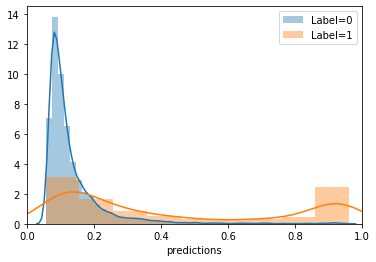

In [0]:
plot_predictions_by_label(predictions, fractions={0: 0.005, 1: 0.01}, prediction='delay_prob', outcome='label')

In [0]:
gbt_r1_confusions = confusion_by_thresh(predictions, prediction='delay_prob', outcome='label')
# plot_pr_curve(gbt_r1_confusions)
# plot_roc_curve(gbt_r1_confusions)

In [0]:
confusions_to_save = gbt_r1_confusions
confusions_to_save['confusion'] = confusions_to_save['confusion'].apply(list)
spark.createDataFrame(confusions_to_save).write.mode("overwrite").parquet(team_folder + "/confusion_matrices/gbt_round1_confusions")

In [0]:
gbt_feature_importance = ExtractFeatureImp(tvs_gbt_model.stages[-1].featureImportances, tvs_gbt_model.stages[0].transform(train), "features", numerical_cols)
gbt_feature_importance[['feature_name', 'vals', 'score']].head(20)

Out[39]:

feature_name 
 vals 
 score 
 
 
 
 
 34 
 tail_num_arrival_to_next_departure_delta 
 NaN 
 0.536461 
 
 
 39 
 op_unique_carrier_indexed 
 [WN, DL, AA, OO, UA, EV, B6, MQ, NK, AS, YX, O... 
 0.074495 
 
 
 36 
 local_hour 
 NaN 
 0.060625 
 
 
 41 
 month_indexed 
 [7, 8, 6, 5, 3, 4, 10, 9, 11, 12, 1, 2] 
 0.035433 
 
 
 22 
 origin_elevation 
 NaN 
 0.034952 
 
 
 37 
 origin_region_indexed 
 [4, 2, 5, 0, 3, 1] 
 0.025566 
 
 
 35 
 distance_group 
 NaN 
 0.025278 
 
 
 38 
 dest_region_indexed 
 [2, 4, 5, 0, 3, 1] 
 0.023874 
 
 
 7 
 origin_ceiling 
 NaN 
 0.021704 
 
 
 21 
 origin_dew_temperature 
 NaN 
 0.020475 
 
 
 20 
 origin_temperature 
 NaN 
 0.017915 
 
 
 42 
 day_of_week_indexed 
 [5, 1, 4, 3, 2, 7, 6] 
 0.015485 
 
 
 33 
 dest_wind_speed 
 NaN 
 0.013852 
 
 
 4 
 origin_visibility 
 NaN 
 0.012900 
 
 
 29 
 dest_max_precip_depth 
 NaN 
 0.012500 
 
 
 17 
 origin_pressure 
 NaN 
 0.009908 
 
 
 0 
 origin_wind_speed 
 NaN 
 0.009313 
 
 
 27 
 dest_precip_depth 
 NaN 
 0.008959 
 
 
 30 
 dest_pressure 
 NaN 
 0.006469 
 
 
 16 
 origin_max_precip_depth 
 NaN 
 0.005698

Best parameters given this set of features optimized on AUC ROC are  
`{'maxDepth': 10, 'maxIter': 100, 'minInfoGain': 0.0}` with `AUC = 0.81165`  
These parameters offer marginal benefits over a model with quarter of the size. Due to resource constraints, we will utilize the latter as approximate hyperparameters to explore on after a further round of feature engineering.  
`{'maxDepth': 10, 'maxIter': 25, 'minInfoGain': 0.0}` with `AUC = 0.80938`  

Additionally due to the sequential nature of the tree building process, we will explore RandomForests considering any training time restrictions. Since in RF all trees can be parallelized and calculated independently.

### Random Forest

In [0]:
model_type = RandomForestClassifier
feature_transformation_pipeline = tree_feature_transformation_pipeline

model = model_type(featuresCol= 'features', labelCol=output_col)

feature_pipe = feature_transformation_pipeline(numerical_cols, onehot_cols, hash_cols, output=output_col)

paramGrid = ParamGridBuilder()\
    .addGrid(model.maxDepth, [10]) \
    .addGrid(model.subsamplingRate, [0.5]) \
    .addGrid(model.numTrees, [50]) \
    .build()

tvs_rf = CustomTrainValidationSplit(estimator=model,
                                     featureTransformation=feature_pipe,
                                   estimatorParamMaps=paramGrid,
                                   evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                                   collectSubModels=True, save_path=team_folder+"/temp_tvs_rf_round1",
                                   parallelism=1)

In [0]:
tvs_rf_model = tvs_rf.fit(data_w_balanced_training_ckpt)

********************
{'maxDepth': 10, 'subsamplingRate': 0.5, 'numTrees': 50}
0.7737556625114181
saving checkpoint to dbfs:/mnt/mids-w261/team17/temp_tvs_rf_round1_0
Best Model: {Param(parent='RandomForestClassifier_defed06cefe4', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10, Param(parent='RandomForestClassifier_defed06cefe4', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 0.5, Param(parent='RandomForestClassifier_defed06cefe4', name='numTrees', doc='Number of trees to train (>= 1).'): 50} Detailed Score 0.7737556625114181

In [0]:
# """Example Train/Validation Output"""
# ********************
# 'maxDepth': 10, 'subsamplingRate': 0.5, 'numTrees': 10}
# 0.763896347783367
# ********************
# {'maxDepth': 10, 'subsamplingRate': 0.5, 'numTrees': 25}
# 0.770535299112134
# ********************
# {'maxDepth': 10, 'subsamplingRate': 0.5, 'numTrees': 50}
# 0.776179195686442
# ********************
# {'maxDepth': 10, 'subsamplingRate': 0.5, 'numTrees': 100}
# 0.7745720157022932


In [0]:
tvs_rf_model.bestModel.write().overwrite().save(team_folder+"/best_rf_round1")
tvs_rf_model = PipelineModel.load(team_folder+"/best_rf_round1")

In [0]:
train, valid, _ = split_data_by_column(data_w_balanced_training_ckpt)

print("calculating predictions")
predictions = tvs_rf_model.transform(valid)
predictions = format_predictions(predictions, output_col='label')

#calculate classification metrics
metrics = BinaryClassificationMetrics(predictions.select(["delay_prob", "label"]).rdd)
print("PR AUC: {}".format(metrics.areaUnderPR))
print("ROC AUC: {}".format(metrics.areaUnderROC))

calc_metrics_at_thresh(predictions, prediction='delay_prob', outcome='label', thresh=0.5, verbose=True)

calculating predictions
classification
PR AUC: 0.5977935907097822
ROC AUC: 0.7737557265568906
ConfusionMatrix(TP=87099, FP=8691, TN=1199883, FN=195071)
predicting frequent class would yield 0.8107 accuaracy
ConfusionMatrix(TP=87099, FP=8691, TN=1199883, FN=195071)
accuracy: 0.8633
precision: 0.9093
recall: 0.3087
f1: 0.4609
Out[38]: {'confusion_matrix': ConfusionMatrix(TP=87099, FP=8691, TN=1199883, FN=195071),
 'accuracy': 0.8633152305157693,
 'precision': 0.9092702787347322,
 'recall': 0.3086756210794911,
 'f1': 0.46089004127420885}

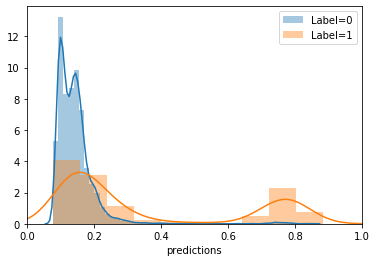

In [0]:
plot_predictions_by_label(predictions, fractions={0: 0.005, 1: 0.01}, prediction='delay_prob', outcome='label')

In [0]:
rf_r1_confusions = confusion_by_thresh(predictions, prediction='delay_prob', outcome='label')
# plot_pr_curve([rf_r1_confusions], labels=['RF rd 1'])
# plot_roc_curve([rf_r1_confusions], labels=['RF rd 1'])

In [0]:
confusions_to_save = rf_r1_confusions
confusions_to_save['confusion'] = confusions_to_save['confusion'].apply(list)
spark.createDataFrame(confusions_to_save).write.mode("overwrite").parquet(team_folder + "/confusion_matrices/rf_round1_confusions")

In [0]:
rf_feature_importance = ExtractFeatureImp(tvs_rf_model.stages[-1].featureImportances, tvs_rf_model.stages[0].transform(train), "features", numerical_cols)
display(rf_feature_importance[['feature_name', 'vals', 'score']])

feature_name vals score tail_num_arrival_to_next_departure_delta null 0.8359321332748433 local_hour null 0.07078002144997639 origin_precip_depth null 0.013078788432111781 origin_max_precip_depth null 0.009592582526960282 month_indexed List(7, 8, 6, 5, 3, 4, 10, 9, 11, 12, 1, 2) 0.008969793025741336 op_unique_carrier_indexed List(WN, DL, AA, OO, UA, EV, B6, MQ, NK, AS, YX, OH, F9, 9E, YV, VX, G4, US) 0.006061052609462225 origin_dew_temperature null 0.0057910550776927566 dest_precip_depth null 0.005603304869151958 origin_temperature null 0.005495348404173058 origin_wind_speed null 0.00514589208749969 dest_max_precip_depth null 0.003251658545784381 dest_wind_speed null 0.0030194397974159693 origin_visibility null 0.0029006211743772374 origin_ceiling null 0.00280254723807147 distance_group null 0.0026369270787451873 origin_pressure_minus_2 null 0.0022034098405771026 origin_pressure_minus_1 null 0.0017549697082416811 origin_elevation null 0.0017262028459337224 dest_pressure null 0.001531131505296076 origin_pressure null 0.0015243595571813942 dest_pressure_minus_2 null 0.0013914602099795632 dest_region_indexed List(2, 4, 5, 0, 3, 1) 0.001380661183849727 dest_pressure_minus_1 null 0.0011983266317615539 origin_max_precip_period null 0.0011661357279341125 dest_max_precip_period null 6.797612637603663E-4 day_of_week_indexed List(5, 1, 4, 3, 2, 7, 6) 6.680431617464012E-4 origin_region_indexed List(4, 2, 5, 0, 3, 1) 6.252616187275897E-4 origin_visibility_minus_2 null 5.052985503856313E-4 origin_ceiling_minus_2 null 4.918799064704205E-4 quarter_indexed List(3, 2, 4, 1) 4.494216083455678E-4 origin_visibility_minus_1 null 4.1081203708967707E-4 origin_diff_to_max_wind null 2.5227983999839723E-4 origin_ceiling_minus_1 null 2.053403372406635E-4 origin_wind_speed_minus_1 null 1.4276833549305135E-4 origin_wind_speed_minus_2 null 1.0434319375421601E-4 origin_snow_depth null 8.69338393232079E-5 origin_snow_depth_minus_2 null 6.870365405371472E-5 dest_snow_depth_minus_2 null 6.568232287345239E-5 origin_precip_period null 6.481234938313342E-5 origin_snow_condition_indexed List(-1, 9, 3) 6.209462096427297E-5 origin_snow_depth_minus_1 null 5.889936034681473E-5 dest_snow_depth_minus_1 null 5.776775413228033E-5 dest_snow_depth null 5.3593231907243903E-5 dest_precip_period null 4.922847265820284E-6 origin_visibility_variability_indexed List(N, V) 3.5573639762119698E-6

## 3. TrainVal Tuning on Full Dataset - v2 Features
Added additional feature engineering especially on airport side as we saw highest importance on operational related features like `'tail_num_arrival_to_next_departure_delta'`: the estimated delta between when the tail number landed from last flight and the current scheduled departure.  

New features include:
 - `intra_region`: indicator whether flight origin and dest is within same clustered region
 - pagerank/graph features for origin and dest
   - `pagerank`
   - `inDegree`
   - `outDegree`
 - `scheduled_busyness_normed`: Number of scheduled flights in the hour normalized within each key (Airport, local hour)
 - rolling averages for delays up to two hours ago by OP_UNIQUE_CARRIER and ORIGIN
   - `rolling_sum_delay_intraday_x`: total number of delays on day up to two hours before flight
   - `rolling_avg_delay_intraday_x`: proportioned delayed on day up to two hours before flight
   - `rolling_sum_delay_24hr_x`: total number of delays between 26 and 2 hours before flight
   - `rolling_avg_delay_24hr_x`: proportioned delayed between 26 and 2 hours before flight
 - `is_holiday`: is national holiday
 - `near_holiday`: is within two days of national holiday
### Stage Training, Validation, Test datasets
balance and shuffle dataset for future model training so this does not have to be done each time

In [0]:
numerical_cols = ['origin_wind_speed', 'origin_wind_direction',
                  'origin_wind_speed_minus_1', 'origin_wind_speed_minus_2', 'origin_diff_to_max_wind',
                  'origin_visibility', 'origin_visibility_minus_1', 'origin_visibility_minus_2',
                  'origin_ceiling', 'origin_ceiling_minus_1', 'origin_ceiling_minus_2',
                  'origin_snow_depth', 'origin_snow_depth_minus_1', 'origin_snow_depth_minus_2',
                  'origin_precip_period', 'origin_precip_depth', 'origin_max_precip_period', 'origin_max_precip_depth',
                  'origin_pressure', 'origin_pressure_minus_1', 'origin_pressure_minus_2', 
                  'origin_temperature', 'origin_dew_temperature', 'origin_elevation', 
                  
                  'dest_snow_depth', 'dest_snow_depth_minus_1', 'dest_snow_depth_minus_2',
                  'dest_precip_period', 'dest_precip_depth', 'dest_max_precip_period', 'dest_max_precip_depth',
                  'dest_pressure', 'dest_pressure_minus_1', 'dest_pressure_minus_2', 
                  'dest_wind_speed', 
                  
                  'tail_num_arrival_to_next_departure_delta', 'distance_group', 'local_hour',
                  
                  'rolling_sum_delay_intraday_carrier', 'rolling_sum_delay_intraday_origin',
                  'rolling_sum_delay_24hr_carrier', 'rolling_sum_delay_24hr_origin',
                  'rolling_avg_delay_intraday_carrier', 'rolling_avg_delay_intraday_origin',
                  'rolling_avg_delay_24hr_carrier', 'rolling_avg_delay_24hr_origin',
                  'scheduled_busyness_normed', 
                  
                  'origin_pagerank', 'origin_outdegree', 'dest_pagerank', 'dest_indegree'
                 ]
onehot_cols = ['origin_region', 'dest_region', 'op_unique_carrier', 'quarter', 'month', 'day_of_week',
               'origin_snow_condition', 'origin_visibility_variability',  
               'is_holiday', 'is_near_holiday', 'intra_region', 'tail_num_arrive_less_than_two_hours_indicator']
hash_cols = []
output_col = 'label' # 'DEP_DEL15 needs to be renamed to label for evaluation methods'

In [0]:
# balance and shuffle dataset for future model training so this does not have to be done each time
full_dataset = spark.read.option("header", "true").parquet(team_folder + "/joinedFeaturesFullClusteredFinal.parquet")
full_dataset = full_dataset.withColumnRenamed('DEP_DEL15', output_col)

print("Splitting data into Train, Val, Test")
train, valid, test = select_and_split_data(full_dataset, numerical_cols, onehot_cols, hash_cols, output='label', splits=[0.9, 0.05, 0.05], seed=0, verbose=True) # verbose will print out the split sizes requiring extra count computation, remove to optimize performance

print("Balancing classes in training data")
balanced_training = balance_classes(train, output_col='label', seed=2020)
data_w_balanced_training = balanced_training.union(valid).union(test)

print("Shuffle/Repartition") # repartition evenly to shuffle and ensure job tasks are well distributed
p_count = data_w_balanced_training.rdd.getNumPartitions()
print(f"parition_count: {p_count}")
data_w_balanced_training = data_w_balanced_training.repartition(p_count)

data_w_balanced_training.write \
    .mode(write_mode) \
    .parquet(team_folder + "/FeatureswBalancedTrainingFinal.parquet")

Splitting data into Train, Val, Test
total data: 29876708
train size: 26857538
validation size: 1490744
test size: 1528426
Balancing classes in training data
Shuffle/Repartition
parition_count: 400

In [0]:
final_data_balanced_ckpt = spark.read.option("header", "true").parquet(team_folder + "/FeatureswBalancedTrainingFinal.parquet")

### GBT

In [0]:
model_type = GBTClassifier
feature_transformation_pipeline = tree_feature_transformation_pipeline

model = model_type(featuresCol= 'features', labelCol=output_col, **{'maxIter': 25, 'maxDepth': 10})

feature_pipe = feature_transformation_pipeline(numerical_cols, onehot_cols, hash_cols, output=output_col)

tvs_gbt2 = Pipeline(stages = [feature_pipe, model])

train, valid, _ = split_data_by_column(final_data_balanced_ckpt, "data_group")

In [0]:
tvs_gbt_model2 = tvs_gbt2.fit(train)

In [0]:
# checkpoint model
tvs_gbt_model2.write().overwrite().save(team_folder+"/best_gbt_round2")
tvs_gbt_model2 = PipelineModel.load(team_folder+"/best_gbt_round2")

In [0]:
predictions = format_predictions(tvs_gbt_model2.transform(valid), output_col=output_col)
metrics = evaluate_and_get_metrics(predictions, verbose=False)
pprint.pprint(metrics)

classification
ConfusionMatrix(TP=114274, FP=24228, TN=1184346, FN=167896)
{'PR_AUC': 0.6634729602624851,
 'ROC_AUC': 0.8237761877349882,
 'accuracy': 0.8711220705902556,
 'confusion_matrix': ConfusionMatrix(TP=114274, FP=24228, TN=1184346, FN=167896),
 'f1': 0.5432926365434353,
 'precision': 0.8250711181065977,
 'recall': 0.40498281178013257}

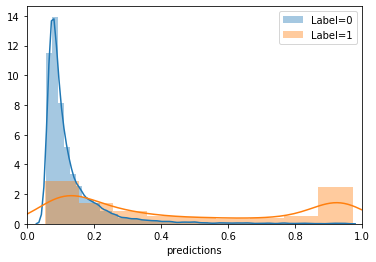

In [0]:
plot_predictions_by_label(predictions, fractions={0: 0.005, 1: 0.01}, prediction='delay_prob', outcome='label')

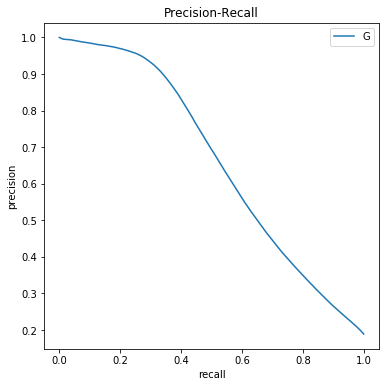

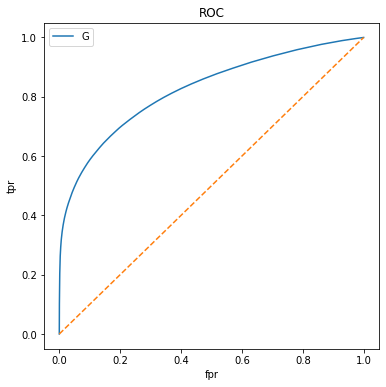

In [0]:
gbt_confusions = confusion_by_thresh(predictions, prediction='delay_prob', outcome='label')
predictions.unpersist()
plot_pr_curve([gbt_confusions], labels="GBT rd 2")
plot_roc_curve([gbt_confusions], labels="GBT rd 2")

In [0]:
confusions_to_save = gbt_confusions
confusions_to_save['confusion'] = confusions_to_save['confusion'].apply(list)
spark.createDataFrame(confusions_to_save).write.mode("overwrite").parquet(team_folder + "/confusion_matrices/gbt_round2_confusions")

In [0]:
model_stage = tvs_gbt_model2 if isinstance(tvs_rf_model2, PipelineModel) else tvs_rf_model2.bestModel
gbt_feature_importance2 = ExtractFeatureImp(model_stage.stages[-1].featureImportances, model_stage.stages[0].transform(train), "features", numerical_cols)
display(gbt_feature_importance2[['feature_name', 'vals', 'score']])

feature_name vals score tail_num_arrival_to_next_departure_delta null 0.49541568147764214 rolling_avg_delay_intraday_carrier null 0.051604299277619954 op_unique_carrier_indexed List(WN, DL, AA, OO, UA, EV, B6, MQ, NK, AS, YX, OH, F9, 9E, YV, VX, G4, US) 0.048696759473681434 rolling_avg_delay_intraday_origin null 0.04605837528205452 dest_pagerank null 0.030686827680222288 local_hour null 0.030230062010254438 rolling_avg_delay_24hr_origin null 0.027576199187585325 dest_indegree null 0.022327447602670185 distance_group null 0.021683735191365294 dest_region_indexed List(2, 4, 5, 0, 3, 1) 0.01820338278443866 rolling_sum_delay_24hr_origin null 0.016226803389021854 origin_dew_temperature null 0.014945036479472403 origin_ceiling null 0.014778732340485653 origin_visibility null 0.012035900376080585 origin_region_indexed List(4, 2, 5, 0, 3, 1) 0.011395941993183438 month_indexed List(7, 8, 6, 5, 3, 4, 10, 9, 11, 12, 1, 2) 0.011332341325683231 day_of_week_indexed List(5, 1, 4, 3, 2, 7, 6) 0.009743908996153633 origin_pagerank null 0.00843750722512383 dest_max_precip_depth null 0.008289135907494886 rolling_avg_delay_24hr_carrier null 0.007942472964459631 origin_temperature null 0.007363775318929718 origin_precip_depth null 0.007292393965098781 dest_precip_depth null 0.0072447412143270265 rolling_sum_delay_intraday_origin null 0.006910024421274946 rolling_sum_delay_intraday_carrier null 0.006795569070101535 origin_outdegree null 0.006728079633001051 dest_wind_speed null 0.0061301465642030996 origin_elevation null 0.005982513826393273 tail_num_arrive_less_than_two_hours_indicator_indexed List(1, 0) 0.005820866020951277 dest_pressure null 0.004344875595690161 origin_pressure_minus_1 null 0.0032488433658357917 origin_wind_speed null 0.0032358107590518947 origin_max_precip_depth null 0.00272787300243522 origin_pressure null 0.002543170781153834 dest_pressure_minus_2 null 0.0017233794842825573 scheduled_busyness_normed null 0.0016522479213685725 origin_pressure_minus_2 null 0.0016258801362292797 rolling_sum_delay_24hr_carrier null 0.0014085351327875837 dest_pressure_minus_1 null 0.001326026463867214 origin_wind_speed_minus_1 null 0.0010054044377041072 origin_ceiling_minus_2 null 7.9752980664911E-4 origin_ceiling_minus_1 null 7.758264929119982E-4 dest_snow_depth null 6.783441093549546E-4 origin_wind_speed_minus_2 null 6.149334220240936E-4 origin_wind_direction null 5.837113802745655E-4 origin_visibility_minus_1 null 4.886013866141635E-4 quarter_indexed List(3, 2, 4, 1) 4.270617219637504E-4 intra_region_indexed List(0, 1) 4.1854968442079515E-4 origin_visibility_minus_2 null 3.953140324154994E-4 dest_snow_depth_minus_1 null 3.880070160732023E-4 dest_snow_depth_minus_2 null 3.4701865780304445E-4 dest_max_precip_period null 3.2228561022345896E-4 is_near_holiday_indexed List(0, 1) 1.5481915416661147E-4 origin_diff_to_max_wind null 1.4740349514601563E-4 is_holiday_indexed List(0, 1) 1.443680369545215E-4 origin_snow_depth_minus_1 null 1.3692298345220735E-4 origin_max_precip_period null 1.194907896701494E-4 origin_precip_period null 9.714402856163012E-5 origin_snow_depth_minus_2 null 8.68000023162165E-5 origin_snow_condition_indexed List(-1, 9, 3) 5.8883666469174416E-5 origin_snow_depth null 4.929023157206993E-5 dest_precip_period null 3.3345990547634375E-5 origin_visibility_variability_indexed List(N, V) 1.3640221034526663E-5

### Random Forest

In [0]:
model_type = RandomForestClassifier
feature_transformation_pipeline = tree_feature_transformation_pipeline

model = model_type(featuresCol= 'features', labelCol=output_col, **{'numTrees': 50, 'subsamplingRate': 0.5, 'maxDepth': 10})

feature_pipe = feature_transformation_pipeline(numerical_cols, onehot_cols, hash_cols, output=output_col)

tvs_rf2 = Pipeline(stages = [feature_pipe, model])

train, valid, _ = split_data_by_column(final_data_balanced_ckpt, "data_group")

In [0]:
tvs_rf_model2 = tvs_rf2.fit(train)

In [0]:
# checkpoint model
tvs_rf_model2.write().overwrite().save(team_folder+"/best_rf_round2")
tvs_rf_model2 = PipelineModel.load(team_folder+"/best_rf_round2")

In [0]:
train, valid, _ = split_data_by_column(final_data_balanced_ckpt, "data_group")
predictions = format_predictions(tvs_rf_model2.transform(valid), output_col=output_col).cache()
metrics = evaluate_and_get_metrics(predictions, verbose=False)
pprint.pprint(metrics)

classification
ConfusionMatrix(TP=93591, FP=11614, TN=1196960, FN=188579)
{'PR_AUC': 0.6201059591846614,
 'ROC_AUC': 0.791340815678876,
 'accuracy': 0.8657093370826916,
 'confusion_matrix': ConfusionMatrix(TP=93591, FP=11614, TN=1196960, FN=188579),
 'f1': 0.48320619554695066,
 'precision': 0.8896060073190438,
 'recall': 0.33168302796186694}

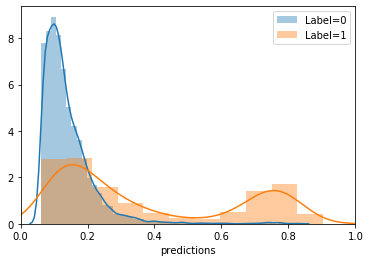

In [0]:
plot_predictions_by_label(predictions, fractions={0: 0.005, 1: 0.01}, prediction='delay_prob', outcome='label')

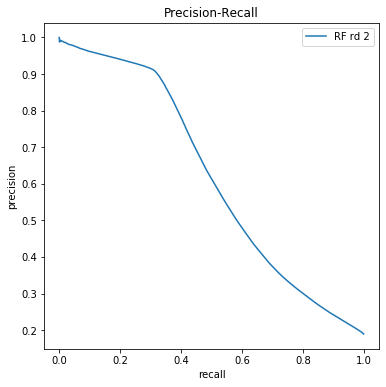

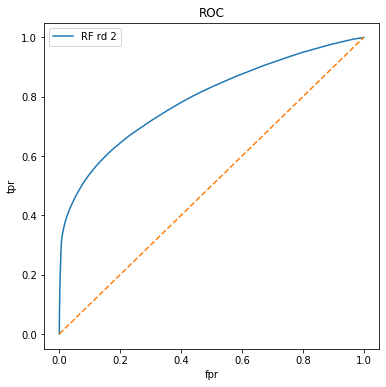

In [0]:
rf_confusions = confusion_by_thresh(predictions, prediction='delay_prob', outcome='label')
predictions.unpersist()
plot_pr_curve([rf_confusions], labels=["RF rd 2"])
plot_roc_curve([rf_confusions], labels=["RF rd 2"])

In [0]:
confusions_to_save = rf_confusions
confusions_to_save['confusion'] = confusions_to_save['confusion'].apply(list)
spark.createDataFrame(confusions_to_save).write.mode("overwrite").parquet(team_folder + "/confusion_matrices/rf_round2_confusions")

In [0]:
model_stage = tvs_rf_model2 if isinstance(tvs_rf_model2, PipelineModel) else tvs_rf_model2.bestModel
rf_feature_importance2 = ExtractFeatureImp(model_stage.stages[-1].featureImportances, model_stage.stages[0].transform(train), "features", numerical_cols)
display(rf_feature_importance2[['feature_name', 'vals', 'score']])

feature_name vals score tail_num_arrival_to_next_departure_delta null 0.6598476145319052 rolling_avg_delay_intraday_origin null 0.06903741665163607 rolling_avg_delay_intraday_carrier null 0.0681960729141958 rolling_sum_delay_intraday_carrier null 0.05176384411822589 rolling_sum_delay_intraday_origin null 0.030151911331618427 rolling_avg_delay_24hr_carrier null 0.028799719554408753 rolling_avg_delay_24hr_origin null 0.016252896654345223 local_hour null 0.016125937983602526 origin_precip_depth null 0.007390891147083114 rolling_sum_delay_24hr_carrier null 0.007279714220552678 rolling_sum_delay_24hr_origin null 0.006337668862808758 origin_max_precip_depth null 0.0060276775161084255 tail_num_arrive_less_than_two_hours_indicator_indexed List(1, 0) 0.004733031421942412 dest_precip_depth null 0.002896638508854207 origin_pagerank null 0.002709773496534404 op_unique_carrier_indexed List(WN, DL, AA, OO, UA, EV, B6, MQ, NK, AS, YX, OH, F9, 9E, YV, VX, G4, US) 0.002522338152093793 origin_outdegree null 0.002232272895356992 origin_ceiling null 0.0022270160658705153 origin_visibility null 0.001748754378757431 origin_dew_temperature null 0.0016539280616910802 dest_max_precip_depth null 0.0013279907864232612 origin_elevation null 0.0011997822053599523 dest_pagerank null 0.0010661043046493188 origin_temperature null 9.361742893396321E-4 dest_indegree null 8.370857350805193E-4 origin_region_indexed List(4, 2, 5, 0, 3, 1) 7.653552089176275E-4 distance_group null 7.42291636266054E-4 origin_visibility_minus_2 null 6.364799541284384E-4 month_indexed List(7, 8, 6, 5, 3, 4, 10, 9, 11, 12, 1, 2) 5.539712967900269E-4 origin_max_precip_period null 4.635642242405966E-4 dest_region_indexed List(2, 4, 5, 0, 3, 1) 4.5950081439864737E-4 origin_pressure null 3.515184637755733E-4 dest_pressure_minus_1 null 2.761350808185633E-4 scheduled_busyness_normed null 2.1938312701971595E-4 intra_region_indexed List(0, 1) 2.1384959788322847E-4 dest_pressure_minus_2 null 2.062936658058249E-4 dest_max_precip_period null 2.027592627284839E-4 origin_wind_speed null 1.9674917009552864E-4 origin_pressure_minus_2 null 1.8998549819567738E-4 origin_visibility_minus_1 null 1.8181876841559216E-4 dest_wind_speed null 1.6454663304626727E-4 origin_pressure_minus_1 null 1.31095429699245E-4 quarter_indexed List(3, 2, 4, 1) 1.1305278881520929E-4 origin_ceiling_minus_2 null 1.0817405181676511E-4 origin_wind_speed_minus_1 null 6.234748649316055E-5 day_of_week_indexed List(5, 1, 4, 3, 2, 7, 6) 5.903311388747704E-5 dest_pressure null 5.093568036807856E-5 origin_ceiling_minus_1 null 4.9175475673439015E-5 origin_snow_depth null 4.2558789332861945E-5 origin_wind_speed_minus_2 null 3.3894699649919575E-5 origin_snow_condition_indexed List(-1, 9, 3) 3.3239057651751745E-5 origin_snow_depth_minus_2 null 3.2544401594213564E-5 origin_diff_to_max_wind null 3.15458555941678E-5 origin_wind_direction null 2.5230923290261652E-5 dest_snow_depth_minus_2 null 2.4608491509264162E-5 dest_snow_depth null 2.286525668181037E-5 origin_snow_depth_minus_1 null 2.24991118658927E-5 dest_snow_depth_minus_1 null 1.435202861184364E-5 origin_precip_period null 7.435306793487905E-6 is_near_holiday_indexed List(0, 1) 3.955813449271926E-6 dest_precip_period null 2.3692519557814876E-6 is_holiday_indexed List(0, 1) 1.738560122498247E-6 origin_visibility_variability_indexed List(N, V) 8.9023417300967E-7

### Logistic Regression Variations

#### Feature Selection by Top 20-30 from GBT
Plot distributions and correlations to remove colinearities and transform to linear space

E.g.  
Transforming `rolling_avg_delay_intraday_carrier` into linear space via log transformation, most often the value is 0 prior to log transform.   
<img src="https://dbc-c4580dc0-018b.cloud.databricks.com/files//plots/a40fc3c6-c11b-4d9d-943a-9f74f6fee57a.png">
  
Distribution of tail_number_delay_propogation, estimated as of two hours before departure (estimated arrival based on scheduled flight time and previous known delay in minutes before departure) (positive = arrival before next departure, cutoff at 2 hrs), most often the plane is estimated to be at the origin airport prior to 2 hours before scheduled departure.  
<img src="https://dbc-c4580dc0-018b.cloud.databricks.com/files//plots/0ca95e84-370b-4973-b208-d0abd3ce1f22.png">  
  
Correlation plot of top30 features from GBT model show some colinearities in the data. To address this problem that would add unnecessary variance, we will keep the former and remove the latter of the following pairs:  
 - (`dest_pagerank`, `dest_indegree`)
 - (`origin_pagerank`, `origin_outdegree`)
 - (`dest_precip_depth`, `dest_max_precip_depth`)
 - (`tail_num_arrival_to_next_departure_delta`, `tail_num_arrive_less_than_two_hours_indicator`)
 - (`rolling_avg_X`, `rolling_sum_X`)   
<img src="https://dbc-c4580dc0-018b.cloud.databricks.com/files//plots/ba1ba5b2-8066-4c3c-9ce7-2237ebfd484b.png">

In [0]:
top_30 = ['tail_num_arrival_to_next_departure_delta',
'rolling_avg_delay_intraday_carrier',
'op_unique_carrier',
'rolling_avg_delay_intraday_origin',
'dest_pagerank',
'local_hour',
'rolling_avg_delay_24hr_origin',
'dest_indegree',
'distance_group',
'dest_region',
'rolling_sum_delay_24hr_origin',
'origin_dew_temperature',
'origin_ceiling',
'origin_visibility',
'origin_region',
'month_indexed',
'day_of_week',
'origin_pagerank',
'dest_max_precip_depth',
'rolling_avg_delay_24hr_carrier',
'origin_temperature',
'origin_precip_depth',
'dest_precip_depth',
'rolling_sum_delay_intraday_origin',
'rolling_sum_delay_intraday_carrier',
'origin_outdegree',
'dest_wind_speed',
'origin_elevation',
'tail_num_arrive_less_than_two_hours_indicator']

In [0]:
logistic_numerical_cols = ['tail_num_arrival_to_next_departure_delta',
 'rolling_avg_delay_intraday_carrier',
 'rolling_avg_delay_intraday_origin',
 'dest_pagerank',
 'local_hour',
 'rolling_avg_delay_24hr_origin',
 'distance_group',
 'origin_dew_temperature',
 'origin_ceiling',
 'origin_visibility',
 'origin_pagerank',
 'rolling_avg_delay_24hr_carrier',
 'origin_temperature',
 'origin_precip_depth',
 'dest_precip_depth',
 'dest_wind_speed',
 'origin_elevation',
]

logistic_onehot_cols = [ 'op_unique_carrier', 'origin_region', 'dest_region', 'month', 'day_of_week']
logistic_hash_cols = []
output_col = 'label'

In [0]:
## Transform features to linear space
def add_and_log(c, add=0):
    return f.log(f.col(c) + add)

logistic_data = final_data_balanced_ckpt
for name, add in [(n, 0.01) for n in numerical_cols if n.startswith("rolling")] + [('dest_precip_depth', 2)]:
    logistic_data = logistic_data.withColumn(name, add_and_log(name, add))
logistic_data = logistic_data.cache()

In [0]:
model_type = LogisticRegression
feature_transformation_pipeline = linear_feature_transformation_pipeline
train, valid, _ = split_data_by_column(logistic_data, "data_group")

model = model_type(featuresCol= 'features', labelCol=output_col, maxIter=100, regParam=0.0)

feature_pipe = feature_transformation_pipeline(logistic_numerical_cols, logistic_onehot_cols, logistic_hash_cols, output=output_col, interact=True)

# 'the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'
# paramGrid = ParamGridBuilder()\
#     .addGrid(model.maxIter, [50, 100])\
#     .addGrid(model.regParam, [0.001, 0.01])\
#     .addGrid(model.elasticNetParam, [0, 0.5])\
#     .build()
paramGrid = [{model.maxIter: 100}]# [{model.maxIter: 50}, {model.maxIter: 100}] + paramGrid

tvs_logistic = CustomTrainValidationSplit(estimator=model,
                                     featureTransformation=feature_pipe,
                                   estimatorParamMaps=paramGrid,
                                   evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                                   collectSubModels=True, save_path=team_folder+"/temp_tvs_logistic_round2",
                                   parallelism=1)

logistic1 = tvs_logistic.fit(logistic_data)

Without interaction, as expected, the features arent fully able to capture flight delays well given the assumptions of linearity and feature independence. Upon introducing interaction terms performance jumps from around 0.63 to 0.71 auc; however, this is still far below the tree models explored previously. With 100 iterations and no regularization outperforming shorter runs with and without regularization, we can conclude that this logistic regression model is underfitting still even after iteraction terms.

In [0]:
# ********************
# {'maxIter': 50, 'regParam': 0.001, 'elasticNetParam': 0.0}
# 0.7089022681376317
# saving checkpoint to dbfs:/mnt/mids-w261/team17/temp_tvs_logistic_round2_0
# ********************
# {'maxIter': 50, 'regParam': 0.001, 'elasticNetParam': 0.5}
# 0.7056921352408916
# saving checkpoint to dbfs:/mnt/mids-w261/team17/temp_tvs_logistic_round2_1
# ********************
# {'maxIter': 50, 'regParam': 0.01, 'elasticNetParam': 0.0}
# 0.70426809486719
# saving checkpoint to dbfs:/mnt/mids-w261/team17/temp_tvs_logistic_round2_2

# ********************
# {'maxIter': 100}
# 0.712726592458503
# saving checkpoint to dbfs:/mnt/mids-w261/team17/temp_tvs_logistic_round2_0
# ********************
# {'maxIter': 100, 'regParam': 0.001, 'elasticNetParam': 0.0}
# 0.7110930423602727
# saving checkpoint to dbfs:/mnt/mids-w261/team17/temp_tvs_logistic_round2_1
# ********************
# {'maxIter': 100, 'regParam': 0.001, 'elasticNetParam': 0.5}
# 0.7088035299752414
# saving checkpoint to dbfs:/mnt/mids-w261/team17/temp_tvs_logistic_round2_2

In [0]:
# checkpoint model
logistic1.write().overwrite().save(team_folder + "/logistic_interaction_round2")

In [0]:
predictions = format_predictions(logistic1.transform(valid), output_col=output_col).cache()
metrics = evaluate_and_get_metrics(predictions, verbose=False)
pprint.pprint(metrics)

classification
ConfusionMatrix(TP=17522, FP=7053, TN=1201521, FN=264648)
{'PR_AUC': 0.4094213578474716,
 'ROC_AUC': 0.7127263499926838,
 'accuracy': 0.8177413425779343,
 'confusion_matrix': ConfusionMatrix(TP=17522, FP=7053, TN=1201521, FN=264648),
 'f1': 0.11424473096545991,
 'precision': 0.713001017293998,
 'recall': 0.062097317220115536}

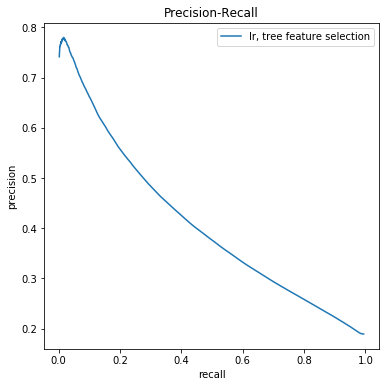

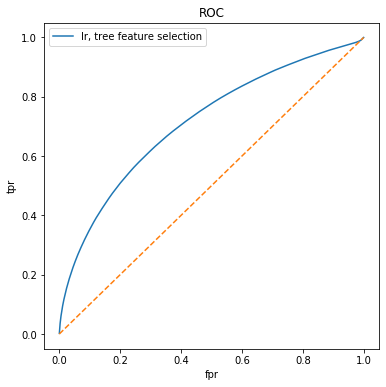

In [0]:
lr1_confusions = confusion_by_thresh(predictions, prediction='delay_prob', outcome='label')
predictions.unpersist()
plot_pr_curve([lr1_confusions], labels=["lr, tree feature selection"])
plot_roc_curve([lr1_confusions], labels=["lr, tree feature selection"])

In [0]:
confusions_to_save = lr1_confusions
confusions_to_save['confusion'] = confusions_to_save['confusion'].apply(list)
spark.createDataFrame(confusions_to_save).write.mode("overwrite").parquet(team_folder + "/confusion_matrices/lr_treebased_selection_round2_confusions")

#### PCA Dimension Reduction
We attempted to compare against another form of dimension reduction, PCA. However, on all features and cross term interactions this proved too computationally expensive in this cluster environement. Get principal components alone during one took over two hours to fit.

In [0]:
feature_transformation_pipeline = linear_feature_transformation_pipeline
feature_pipe = feature_transformation_pipeline(numerical_cols, onehot_cols, hash_cols, output=output_col, interact=True)
feature_pipe_w_pca = Pipeline(stages=[feature_pipe, PCA(k=100, inputCol="features", outputCol="pcaFeatures")])
# train, valid, _ = split_data_by_column(logistic_data, "data_group")
# train = train.cache()
# feature_pipe_w_pca = feature_pipe_w_pca.fit(train)

In [0]:
# feature_pipe_w_pca.stages[-1].explainedVariance
# DenseVector([0.0667, 0.0634, 0.0628, 0.0439, 0.0401, 0.039, 0.0366, 0.036, 0.0343, 0.0306, 0.0285, 0.0278, 0.0274, 0.0269, 0.0266, 0.0263, 0.026, 0.0258, 0.0234, 0.0226, 0.0209, 0.0191, 0.019, 0.0163, 0.0161, 0.0156, 0.0153, 0.0152, 0.0149, 0.0146, 0.0132, 0.0126, 0.0112, 0.0082, 0.0078, 0.0062, 0.0049, 0.0047, 0.0044, 0.0043, 0.0037, 0.0037, 0.0035, 0.0033, 0.0031, 0.003, 0.0028, 0.0026, 0.0024, 0.0023, 0.002, 0.0015, 0.0013, 0.0011, 0.0011, 0.001, 0.0006, 0.0004, 0.0003, 0.0002, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [0]:
# model_type = LogisticRegression
# feature_pipe = Pipeline(stages=[linear_feature_transformation_pipeline(numerical_cols, onehot_cols, hash_cols, output=output_col, interact=True),
#                                                    PCA(k=33, inputCol="features", outputCol="pcaFeatures")])
# train, valid, _ = split_data_by_column(logistic_data, "data_group")

# model = model_type(featuresCol= 'features', labelCol=output_col, maxIter=100, regParam=0.0)

# # 'the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'
# paramGrid = ParamGridBuilder()\
#     .addGrid(model.maxIter, [100])\
#     .addGrid(model.regParam, [0.001, 0.01])\
#     .addGrid(model.elasticNetParam, [0, 0.5])\
#     .build()
# paramGrid = [{model.maxIter: 100}] # + paramGrid

# tvs_logistic_pca = CustomTrainValidationSplit(estimator=model,
#                                      featureTransformation=feature_pipe,
#                                    estimatorParamMaps=paramGrid,
#                                    evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
#                                    collectSubModels=True, save_path=team_folder+"/temp_tvs_logistic_round2",
#                                    parallelism=1)

# logistic2_pca = tvs_logistic_pca.fit(logistic_data)
# logistic2_pca.write().overwrite().save(team_folder + "/logistic_interaction_pca_round2")

## Comparison

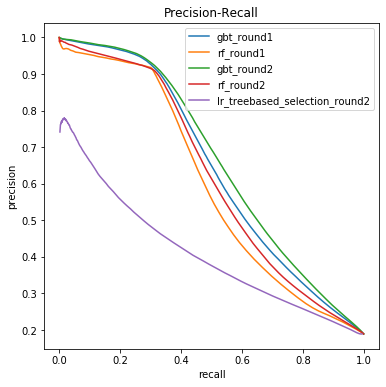

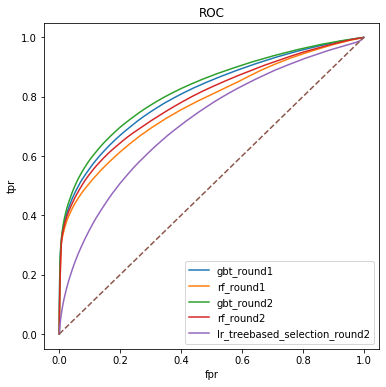

In [0]:
models = ['gbt_round1', 'rf_round1', 'gbt_round2', 'rf_round2', 'lr_treebased_selection_round2']
confusion_data = [spark.read.option("header", "true").parquet(team_folder + f"/confusion_matrices/{m}_confusions").toPandas() for m in models]
for c in confusion_data:
    c['confusion'] = c['confusion'].apply(lambda x: ConfusionMatrix(*x))
plot_pr_curve(confusion_data, labels=models)
plot_roc_curve(confusion_data, labels=models)

The GBT model trained on all engineered features after the second round of improvement performed the best. The second round model was trained on the same parameters as the partially tuned version in round 1. Ideally, another round of parameter tuning would take place after a significant addition of features; however due to resource contraints of shared cluster, we did not. The addition of new airline carrier/airport features did produce notable increase in AUC performance regardless, ending with 0.824 AUC on the validation dataset. We confirm that this result holds for the unseen test data as well in the full E2E pipeline below.

# End-to-End

In [0]:
def full_pipeline(weather, airlines, pagerank_data=None, 
                  feature_transformation_pipeline=tree_feature_transformation_pipeline, model=GBTClassifier(maxIter=25, maxDepth=100), 
                  checkpoint_path=None, write_mode="ignore", plot=True):
    """
    full pipeline from separate dataframes to final model and validation/test metrics
    if checkpoint path set, will write dataset checkpoints with set write mode to the path specified
    
    *does contain references to other methods within this notebook
    """
    # ref ln 21
    features = create_all_features(weather, airlines, pagerank_data=pagerank_data, checkpoint_path=checkpoint_path, write_mode=write_mode)
    features = features.cache()
    # ref ln 202
    pipeline_model, validation_metrics, test_metrics = train_model_and_evaluate(features_data=features, 
                                                                                model=model, 
                                                                                feature_transformation_pipeline=feature_transformation_pipeline,
                                                                                checkpoint_path=checkpoint_path,
                                                                                plot=plot)
    features.unpersist()
    return pipeline_model, validation_metrics, test_metrics


def create_all_features(weather, airlines, pagerank_data=None, checkpoint_path=None, write_mode="ignore"):
    print("creating airline features")
    airline_features = get_airline_features(airlines, pagerank_data=pagerank_data, checkpoint_path=checkpoint_path, write_mode=write_mode)
    print("creating weather features")
    weather_features = get_weather_features(weather, checkpoint_path=checkpoint_path, write_mode=write_mode)
    print("joining")
    joined = join_weather_and_airlines(weather_features, airline_features, checkpoint_path=checkpoint_path, write_mode=write_mode).cache()
    print("cluster airports by location")
    joined_features_w_airport_clusters = cluster_airports_w_checkpoint(joined, checkpoint_path=checkpoint_path, write_mode=write_mode)
    return joined_features_w_airport_clusters


def get_weather_features(weather, checkpoint_path=None, write_mode="ignore"):
    # Weather Features
    # parse csv formatted strings with human readable structs
    # if value is missing or invalid, get closest previous valid value
    weather_parsed = parse_weather_columns(weather, base_columns)
    # create features for most weather observations + t-1 and t-2 observations
    # create a new timestamp for joining to airlines that is shifted two hours up from the observation time, ensuring that we only know data up to t-2hrs
    weather_features = create_weather_features(weather_parsed, where_clause="")

    if checkpoint_path:
        weather_features \
            .write \
            .mode(write_mode) \
            .parquet(checkpoint_path + "/weatherFeatures.parquet")
        weather_features = spark.read.option("header", "true").parquet(checkpoint_path + "/weatherFeatures.parquet")
    return weather_features


def get_airline_features(airlines, pagerank_data=None, checkpoint_path=None, write_mode="ignore"):
    # Airline Features
    interesting_columns_airlines = [
        'FL_DATE', 'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'DEST',
        'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE_GROUP',
        'DEP_DELAY', 'DEP_DEL15', 
        'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

    # Format to timestamps
    airlines_time_formatted = select_columns_and_format_time(airlines, 
                                                             interesting_columns_airlines, 
                                                             filters=[])
    # Adjust local time to utc, with broadcast join on airport to timezone data
    airlines_with_tz = adjust_flight_times_to_utc(airlines_time_formatted, 
                                                  tz_data="dbfs:/FileStore/tables/timezones-1.csv")
    # Identify federal holidays and days +-2 around the holidays
    airlines_with_tz_holidays = add_holidays(airlines_with_tz, holiday_data="dbfs:/FileStore/tables/group17_holidays.csv")
    # Calculate the delta between the expected arrival of previous flight with scheduled departure time
    # Only propogate delays if it would have been known two hours prior to the current departure
    airlines_with_propogating_delay = get_last_tail_num_flight_delay(airlines_with_tz_holidays)
    # Broadcast join airlines with airport pagerank scores and vertex degrees
    # Calculate the pagerank data if path is not provided
    if not pagerank_data:
        print("calculating pagerank")
        pagerank_data = get_pagerank_data(airlines, checkpoint_path)
    print("joining pagerank")
    airlines_with_pagerank = join_pagerank(airlines_with_propogating_delay, 
                                           pagerank_data=pagerank_data)

    if checkpoint_path:
        airlines_with_pagerank \
            .write \
            .mode(write_mode) \
            .parquet(checkpoint_path + "/airlineFeatures.parquet")
        airlines_with_pagerank = spark.read.option("header", "true").parquet(checkpoint_path + "/airlineFeatures.parquet")

    airlineFeatureswAggregates = rolling_delays(airlines_with_pagerank)
    airlineFeatureswAggregates = norm_origin_busyness_by_hour(airlineFeatureswAggregates)

    if checkpoint_path:
        airlineFeatureswAggregates \
            .write \
            .mode(write_mode) \
            .parquet(checkpoint_path + "/airlineFeatureswAggregates.parquet")
        airlineFeatureswAggregates = spark \
            .read \
            .option("header", "true") \
            .parquet(checkpoint_path + "/airlineFeatureswAggregates.parquet")
    return airlineFeatureswAggregates

def get_pagerank_data(airlines, checkpoint_path):
    # create graph
    edges = airlines \
      .select(f.col("origin").alias("src"), 
              f.col("dest").alias("dst"),
              f.lit(1).alias("weight"))

    vertices = spark.createDataFrame(data=[(arpt.airport, arpt.airport, 1.0/len(full_airport_set)) for arpt in full_airport_set],
                                     schema=["id", "airport", "weight"])
    g = GraphFrame(vertices, edges).cache()
    PageRankResults = g.pageRank(resetProbability=0.15, maxIter=20).cache()

    outDegrees = g.edges \
        .groupBy(f.col("src").alias("id")) \
        .agg(f.countDistinct(f.col("dst")).alias("outDegree"))
    inDegrees = g.edges \
        .groupBy(f.col("dst").alias("id")) \
        .agg(f.countDistinct(f.col("src")).alias("inDegree"))
    degrees = inDegrees.alias("in") \
        .join(outDegrees.alias("out"), inDegrees.id == outDegrees.id) \
        .select("in.id","in.inDegree", "out.outDegree")

    PageRankResultsWDegree = PageRankResults.vertices.alias("pr") \
        .join(degrees, PageRankResults.vertices.id == degrees.id) \
        .select("pr.id", "pr.pagerank", "inDegree", "outDegree")

    PageRankResultsWDegree.write \
        .mode("overwrite") \
        .parquet(checkpoint_path + "/airportPageRankWDegree.parquet")
    g.unpersist()
    return checkpoint_path + "/airportPageRankWDegree.parquet"


def join_weather_and_airlines(weather_features, airline_features, checkpoint_path=None, write_mode="ignore"):
    # can use either dataframe api or express in sql syntax, in this case we use the latter
    airline_features.createOrReplaceTempView("airlineFeaturesFullTeam17")
    weather_features.createOrReplaceTempView("weatherFeaturesFullTeam17")
    weather_feature_names = [f"o.{c} as origin_{c}" for c in weather_features.columns]
    weather_feature_names.extend([f"d.{c} as dest_{c}" for c in weather_features.columns])

    joined = spark.sql("""
      SELECT a.*, {weather_columns}
      FROM airlineFeaturesFullTeam17 a
      JOIN weatherFeaturesFullTeam17 o
        ON ('K'||a.origin) = o.call_sign
        AND a.scheduled_flight_hour_UTC = o.join_datetime
      JOIN weatherFeaturesFullTeam17 d
        ON ('K'||a.dest) = d.call_sign
        AND a.scheduled_flight_hour_UTC = d.join_datetime;
    """.format(weather_columns=", ".join(weather_feature_names))).cache()

    if checkpoint_path:
        joined \
            .write \
            .mode(write_mode) \
            .parquet(checkpoint_path + "/joinedFeatures.parquet")
        joined = spark \
            .read \
            .option("header", "true") \
            .parquet(checkpoint_path + "/joinedFeatures.parquet")
    return joined


def cluster_airports_w_checkpoint(joined_features, checkpoint_path=None, write_mode="ignore"):
    # implemented `cluster_airports(data)` in Cluster Airlines by Lat Lon section
    joined_features_w_airport_clusters = cluster_airports(joined_features)
    if checkpoint_path:
        joined_features_w_airport_clusters \
            .write \
            .mode(write_mode) \
            .parquet(checkpoint_path + "/joinedFeaturesClustered.parquet")
        joined_features_w_airport_clusters = spark \
            .read \
            .option("header", "true") \
            .parquet(checkpoint_path + "/joinedFeaturesClustered.parquet")
    return joined_features_w_airport_clusters


def split_data_and_balance_training(full_dataset, numerical_cols, onehot_cols, hash_cols, output_col, num_partitions=None, checkpoint_path=None, write_mode="ignore"):
    full_dataset = full_dataset.withColumnRenamed('DEP_DEL15', output_col)

    print("Splitting data into Train, Val, Test")
    train, valid, test = select_and_split_data(full_dataset, numerical_cols, onehot_cols, hash_cols, output=output_col, splits=[0.9, 0.05, 0.05], seed=0, verbose=True) # verbose will print out the split sizes requiring extra count computation, remove to optimize performance

    print("Balancing classes in training data")
    balanced_training = balance_classes(train, output_col='label', seed=2020)
    data_w_balanced_training = balanced_training.union(valid).union(test)

    print("Shuffle/Repartition") # repartition evenly to shuffle and ensure job tasks are well distributed
    p_count = num_partitions if num_partitions else data_w_balanced_training.rdd.getNumPartitions()
    print(f"parition_count: {p_count}")
    data_w_balanced_training = data_w_balanced_training.repartition(p_count)

    if checkpoint_path:
        data_w_balanced_training.write \
            .mode(write_mode) \
            .parquet(checkpoint_path + "/FeatureswBalancedTraining.parquet")
        spark.read \
            .option("header", "true") \
            .parquet(checkpoint_path + "/FeatureswBalancedTraining.parquet")
    return data_w_balanced_training


def train_model_and_evaluate(features_data, feature_transformation_pipeline=tree_feature_transformation_pipeline, model=GBTClassifier(maxIter=25, maxDepth=100),
                             plot=True, checkpoint_path=None, write_mode="ignore"):
    numerical_cols = ['origin_wind_speed', 'origin_wind_direction',
                  'origin_wind_speed_minus_1', 'origin_wind_speed_minus_2', 'origin_diff_to_max_wind',
                  'origin_visibility', 'origin_visibility_minus_1', 'origin_visibility_minus_2',
                  'origin_ceiling', 'origin_ceiling_minus_1', 'origin_ceiling_minus_2',
                  'origin_snow_depth', 'origin_snow_depth_minus_1', 'origin_snow_depth_minus_2',
                  'origin_precip_period', 'origin_precip_depth', 'origin_max_precip_period', 'origin_max_precip_depth',
                  'origin_pressure', 'origin_pressure_minus_1', 'origin_pressure_minus_2', 
                  'origin_temperature', 'origin_dew_temperature', 'origin_elevation', 
                  
                  'dest_snow_depth', 'dest_snow_depth_minus_1', 'dest_snow_depth_minus_2',
                  'dest_precip_period', 'dest_precip_depth', 'dest_max_precip_period', 'dest_max_precip_depth',
                  'dest_pressure', 'dest_pressure_minus_1', 'dest_pressure_minus_2', 
                  'dest_wind_speed', 
                  
                  'tail_num_arrival_to_next_departure_delta', 'distance_group', 'local_hour',
                  
                  'rolling_sum_delay_intraday_carrier', 'rolling_sum_delay_intraday_origin',
                  'rolling_sum_delay_24hr_carrier', 'rolling_sum_delay_24hr_origin',
                  'rolling_avg_delay_intraday_carrier', 'rolling_avg_delay_intraday_origin',
                  'rolling_avg_delay_24hr_carrier', 'rolling_avg_delay_24hr_origin',
                  'scheduled_busyness_normed', 
                  
                  'origin_pagerank', 'origin_outdegree', 'dest_pagerank', 'dest_indegree'
                 ]
    # for tree methods, these categorical cols just get indexed
    onehot_cols = ['origin_region', 'dest_region', 'op_unique_carrier', 'quarter', 'month', 'day_of_week',
                   'origin_snow_condition', 'origin_visibility_variability',  
                   'is_holiday', 'is_near_holiday', 'intra_region', 'tail_num_arrive_less_than_two_hours_indicator']
    hash_cols = []
    output_col = 'label' # 'DEP_DEL15 needs to be renamed to label for evaluation methods'

    # get final dataset before training
    print("balancing training data")
    final_data_balanced_ckpt = split_data_and_balance_training(features_data, numerical_cols, onehot_cols, hash_cols, output_col, checkpoint_path=checkpoint_path, write_mode=write_mode)
    final_data_balanced_ckpt = final_data_balanced_ckpt.cache()

    feature_pipe = feature_transformation_pipeline(numerical_cols, onehot_cols, hash_cols, output=output_col)

    # pipeline model containing necessary imputation and feature transformation before model
    pipeline_model = Pipeline(stages = [feature_pipe, model])

    train, valid, test = split_data_by_column(final_data_balanced_ckpt, "data_group")
    print("training model")
    pipeline_model = pipeline_model.fit(train)
    if checkpoint_path:
        model_path = checkpoint_path + "/model"
        print("saving model to {}".format(model_path))
        pipeline_model.write().overwrite().save(model_path)
    print("getting predictions")
    predictions = format_predictions(pipeline_model.transform(valid), output_col=output_col).cache()
    validation_metrics = evaluate_and_get_metrics(predictions, output_col, verbose=False)
    valid_confusions = confusion_by_thresh(predictions, prediction='delay_prob', outcome='label')
    predictions.unpersist()
    print("**validation_metrics**")
    pprint.pprint(validation_metrics)

    print("getting predictions")
    predictions = format_predictions(pipeline_model.transform(test), output_col=output_col).cache()
    test_metrics = evaluate_and_get_metrics(predictions, output_col, verbose=False)
    test_confusions = confusion_by_thresh(predictions, prediction='delay_prob', outcome='label')
    predictions.unpersist()
    print("**test_metrics**")
    pprint.pprint(test_metrics)
    if plot:
        plot_pr_curve([valid_confusions, test_confusions], labels=["validation", "test"])
        plot_roc_curve([valid_confusions, test_confusions], labels=["validation", "test"])
        try:
            gbt_feature_importance2 = ExtractFeatureImp(pipeline_model.stages[-1].featureImportances, pipeline_model.stages[0].transform(train), "features", numerical_cols)
            display(gbt_feature_importance2[['feature_name', 'vals', 'score']])
        except:
            print("no feature important associated with this model type")
    return pipeline_model, validation_metrics, test_metrics

In [0]:
# dbutils.fs.mkdirs(team_folder + '/ckpt')

creating airline features
joining pagerank
creating weather features
joining
cluster airports by location
balancing training data
Splitting data into Train, Val, Test
total data: 29876708
train size: 26852166
validation size: 1472143
test size: 1552399
Balancing classes in training data
Shuffle/Repartition
parition_count: 400
training model
saving model to dbfs:/mnt/mids-w261/team17/ckpt/model
getting predictions
classification
calculating metrics @ 0.5 threshold
ConfusionMatrix(TP=105854, FP=21596, TN=1178766, FN=165927)
**validation_metrics**
{'PR_AUC': 0.6594281468492185,
 'ROC_AUC': 0.8225881479994881,
 'accuracy': 0.8726190322543395,
 'confusion_matrix': ConfusionMatrix(TP=105854, FP=21596, TN=1178766, FN=165927),
 'f1': 0.5302894815282382,
 'precision': 0.8305531581012162,
 'recall': 0.3894827085042737}
getting predictions
classification
calculating metrics @ 0.5 threshold
ConfusionMatrix(TP=119784, FP=23662, TN=1230967, FN=177986)
**test_metrics**
{'PR_AUC': 0.6750847421714786,
 'ROC_AUC': 0.827854141294537,
 'accuracy': 0.8701055592022412,
 'confusion_matrix': ConfusionMatrix(TP=119784, FP=23662, TN=1230967, FN=177986),
 'f1': 0.5429721496953873,
 'precision': 0.835045940632712,
 'recall': 0.40227020855022333}

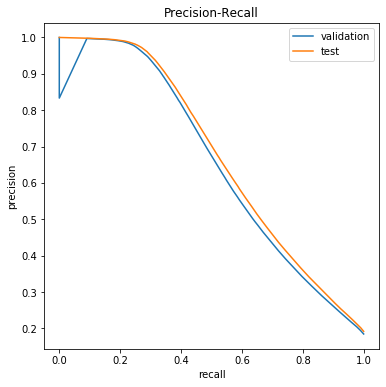

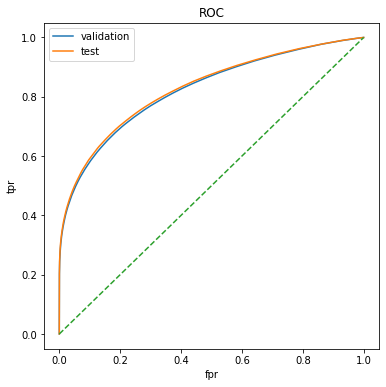

feature_name vals score tail_num_arrival_to_next_departure_delta null 0.5113557773316474 rolling_avg_delay_intraday_carrier null 0.05317764232979663 op_unique_carrier_indexed List(WN, DL, AA, OO, UA, EV, B6, MQ, NK, AS, YX, OH, F9, 9E, YV, VX, G4, US) 0.045636603530037276 rolling_avg_delay_intraday_origin null 0.04410318229975925 dest_pagerank null 0.031123522049635834 local_hour null 0.03021833047230618 rolling_avg_delay_24hr_origin null 0.023477371352533135 dest_indegree null 0.020719746427246343 dest_region_indexed List(4, 1, 3, 2, 5, 0) 0.01876927513611327 distance_group null 0.017726485515910672 origin_ceiling null 0.015583778070560583 rolling_sum_delay_24hr_origin null 0.015515085006942791 origin_dew_temperature null 0.01450014869770981 origin_visibility null 0.0114091102799527 origin_region_indexed List(4, 1, 3, 2, 5, 0) 0.011029613823363897 month_indexed List(7, 8, 6, 5, 3, 4, 10, 9, 11, 12, 1, 2) 0.010479359982439094 origin_pagerank null 0.010366388808473619 day_of_week_indexed List(5, 4, 1, 3, 2, 7, 6) 0.009666984130977418 dest_precip_depth null 0.008174230457091718 rolling_sum_delay_intraday_carrier null 0.00813500914519531 rolling_avg_delay_24hr_carrier null 0.007629816938484731 dest_max_precip_depth null 0.007322426490929764 origin_temperature null 0.0068604605790440025 rolling_sum_delay_intraday_origin null 0.006837485502736425 origin_precip_depth null 0.006804954686855283 tail_num_arrive_less_than_two_hours_indicator_indexed List(1, 0) 0.0066099913755377935 dest_wind_speed null 0.006229972677110265 origin_elevation null 0.00556559945001442 origin_outdegree null 0.005300878849905291 dest_pressure null 0.003619845918999207 origin_wind_speed null 0.0036071640229967464 origin_pressure_minus_1 null 0.003200616973464892 origin_pressure null 0.0024876975166923504 origin_max_precip_depth null 0.002199956738042038 scheduled_busyness_normed null 0.0015411618993937753 dest_pressure_minus_2 null 0.0015311707890212124 rolling_sum_delay_24hr_carrier null 0.001517328445644463 origin_pressure_minus_2 null 0.0011775009553571982 dest_pressure_minus_1 null 9.434495385925803E-4 origin_wind_speed_minus_1 null 9.275577937040519E-4 origin_ceiling_minus_2 null 8.544565528894627E-4 dest_snow_depth null 7.673102441027196E-4 origin_wind_speed_minus_2 null 7.206751358313867E-4 origin_ceiling_minus_1 null 5.506258302579352E-4 origin_diff_to_max_wind null 4.961624950752389E-4 origin_visibility_minus_1 null 4.738868956248599E-4 origin_wind_direction null 4.4877178314836575E-4 origin_visibility_minus_2 null 4.0270315906511695E-4 intra_region_indexed List(0, 1) 3.573975979021554E-4 dest_snow_depth_minus_2 null 2.739025485634822E-4 dest_max_precip_period null 2.6465385816316596E-4 quarter_indexed List(3, 2, 4, 1) 2.1863296115909707E-4 origin_snow_depth_minus_1 null 2.0318006080170266E-4 dest_snow_depth_minus_1 null 1.930804238272279E-4 is_holiday_indexed List(0, 1) 1.6559248274512436E-4 origin_snow_depth_minus_2 null 1.5021506814095022E-4 is_near_holiday_indexed List(0, 1) 1.3878388845541803E-4 origin_snow_depth null 7.025404619371332E-5 origin_max_precip_period null 5.8498798324134746E-5 origin_precip_period null 4.276898180102529E-5 dest_precip_period null 3.682521824091939E-5 origin_snow_condition_indexed List(-1, 9, 3) 1.5139081610732187E-5 origin_visibility_variability_indexed List(N, V) 1.380089785700331E-5

In [0]:
model = GBTClassifier(maxIter=25, maxDepth=10)
weather = spark.read.option("header", "true")\
    .parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/weather_data/weather201*a.parquet")
airlines = spark.read.option("header", "true")\
    .parquet(f"dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/*.parquet")


# starting with just weather and airline data --> model with test scores
# can provide the pagerank data precalculated with a file path
# with minimal cluster traffic takes ~20-30 min writing new checkpoints and calculating pagerank
# when cluster resources are taken for other tasks, takes up to several hours for the same process
# checkpoints with write_mode="ignore" will pick up from latest completed step in case of a hardware reset/failure
# feature generation will move on, but model will always retrain to account for any parameter changes
model, val_metrics, test_metrics = full_pipeline(
    weather, airlines, pagerank_data=team_folder+"/ckpt/airportPageRankWDegree.parquet", 
    feature_transformation_pipeline=tree_feature_transformation_pipeline, model=model,
    checkpoint_path=team_folder+"/ckpt", write_mode="ignore")

In [0]:
test_metrics

Out[41]: {'confusion_matrix': ConfusionMatrix(TP=119997, FP=24255, TN=1230374, FN=177773),
 'accuracy': 0.8698607767719511,
 'precision': 0.8318567506862989,
 'recall': 0.402985525741344,
 'f1': 0.542945826225844,
 'ROC_AUC': 0.8275148967955668,
 'PR_AUC': 0.6744361740424321}

We confirmed that the performance metrics of the model are the same on the test data as those on the validation data that was used for tuning with ROC AUC values of 0.823 validation and 0.828 for test.

# Conclusion
As seen directly above in the full end-to-end pipeline, the model performs equally well on test data as it did on the validation set that has been used throughout this project for model selection. In the model selection process we considered several model algorithms and feature sets in an iterative process. Round 1 of modeling included primarily weather features alongside airline/airport metadata.
  
While we were primarily optimizing for ROC AUC as stated prior in accordance with our use case, the GBT model which included all the airport and airline features was the best performer on both ROC AUC and precision recall.  
  
| Model    | Description                                   | ROC AUC | Precision-Recall | F1@0.5 | Precision@0.5 | Recall@0.5 | Accuracy@0.5 |
|----------|-----------------------------------------------|---------|------------------|--------|---------------|------------|--------------|
| GBT rd 1 | GBT on   initial features                     | 0.8094  | 0.6437           | 0.5183 | 0.8448        | 0.3738     | 0.8685       |
| GBT rd 2 | GBT including added airport/airline features  |**0.8238**|**0.6635**       |**0.5433**| 0.8251      | **0.405**  | **0.8711**   |
| RF rd 1  | RF on   initial features                      | 0.7738  | 0.5978           | 0.4609 | **0.9093**    | 0.3087     | 0.8633       |
| RF rd 2  | RF   including added airport/airline features | 0.7913  | 0.6201           | 0.4832 | 0.8896        | 0.3317     | 0.8657       |
| LR       | Tree   based feature selection + interaction  | 0.7127  | 0.4094           | 0.1142 | 0.713         | 0.0621     | 0.8177       |

<img src=https://dbc-c4580dc0-018b.cloud.databricks.com/files//plots/5df1cd62-e14b-4206-9aad-e4ff12004313.png>
<img src=https://dbc-c4580dc0-018b.cloud.databricks.com/files//plots/55b5aad3-5c2c-4fc0-889a-152bbe072ce6.png>

In the case of predicting flight delays, the most predictive features for correctly identifying potentially delayed flights are operator based including:
 - Aircraft arriving too close to next departure time
 - Systematic delays in the carrier and/or origin airport
 - Dest PageRank (i.e. volume of flights in and out of the destination)
 - Hour of day (potentially due to staffing schedules)
  
Additionally, tree-based algorithms compared to linear models work better for this task for the following reasons:
 - Not all feature values cannot be transformed into approx normal distribution
 - Features not independent
 - Interaction features not needed due to recursive splitting
   
These learnings came through a closed loop model development process in which feature engineering and model tuning was a slight back and forth process as further features were developed from learnings about the lack of predictive power in weather compared to airport/carrier features.  

The feature creation part of the pipeline generally avoided any performance concerns by explicitly broadcasting small joins when possible such as the timezone adjustments, clustering assignments, and pagerank scores. Additionally, to evaluate the model, we implemented a Confusion Matrix named tuple that could be mapped to for each (prediction, label, threshold) and reduced with an element wise sum to calculate the overall metrics. This method avoided any possibility of memory issues that may be possible from collecting trying to collect all predictions and labels to calculate metrics locally.  

An additional scalability improvement that we made to the model development process was to customize the standard TrainValidationSplit class available in pyspark. Initially to incorporate our custom data splitting method based on (date, region) keys, we further customized this class in order to take in the feature transformation pipeline steps and model steps separately. By doing this, we could fit and transform the model features in training and validation respectively and cache the results before passing these new vectors to the model training and validation steps. In the process of model tuning, there may be various parameter values for which a model is trained and evaluated in succession. In this case; however, the feature transformation pipeline including indexing and/or onehot/hash encoding, imputing missing values, and normalizing all only have to be done once as the different model parameters are tested against the same train and validation data. By caching this step, we avoid repeating this feature transformation fit and transform step for every set of model parameters.  

Ultimately, we landed on using a gradient boosted tree classifier with a depth of 10 and 25 iterations (100 trees showed marginally better performance but resource constraints made this made this tradeoff to reduce size somewhat necessary). The model outperformed random forests and logistic regressions all tuned for ROC AUC. This metric was chosen from the perspective of an operational business use case. In this case, one cares much more about identifying the positive, delay of 15 min or greater, much more than the negative class, normal operation as scheduled. By correctly identifying delayed flights two hours ahead of the scheduled departure, one could attempt to dedicate some resources towards mitigating that potential delay and/or to mitigating the delay from propagating on to future flights, which may include actions like sending more staff to expedite deplaning, cabin cleaning, loading, etc. These actions are potentially cost saving and increase customer satisfaction when the plane would infact be delayed; however, if the false positive rate is too high, this would lead to unnecessary overhead costs associated with deviating from normal operations. These two factors lead naturally to choosing ROC AUC as our ultimate evaluation metrics.  

Each run of the full model training pipeline from raw dataset to trained model takes about 20-30 min on the current cluster configuration with low traffic and a data volume of about 30mil flights (couple hours when cluster experiencing load). Regarding training time, the model created would likely only have to be trained once a day or even every several days in batch as it does not consider any pattern of sequences that are particularly associated with needing to be realtime. That said, our model does consider some rolling historical values, such as what proportion of flights for the carrier and origin have been delayed in the last few hours \[t-5, t-2\) and the last 24 hours \[t-26, t-2\). These types of features would require at least an hourly aggregation pipeline that calculates these metrics to be used during inference for each of the flights that are upcoming. Lastly, the most intensive feature that would need to be maintained is the expected arrival of the previous flight for each plane. This would potentially be an object store that keeps the latest status and schedule of each plane (5000+ planes during peak times, [https://www.faa.gov/air_traffic/by_the_numbers/]) that is updated via a message queue of status updates coming from each airport/plane.

# Discussion (Course Concepts)

## Map Reduce Paradigm + Pairs Representation
As mentioned previously in the conclusion section above, we aimed to ensure that, whenever needed, the code was scalable to any dataset size with primarily only horizontal scaling needed to address any large increases in datasize. We went about doing this on a few occasions including the evaluation code to generate ROC AUC and PR curves without needing to collect all predictions and labels into memory. In order to do this, we utilized a pair representation, yielding (threshold, (prediction, label)) for a range of thresholds at small intervals between 0 and 1 via a flatmap. These pairs were then mapped to (threshold, confusion) pairs (e.g. (0.5, [1,0,0,0]), representing a TP prediction). Then the confusion matrices are added element-wise during a reduceByKey step to produce the full confusion matrix at all the thresholds in the range. This method of calculating the confusion matrices enusures that regardless of how many data points there are, only T values will ever be collected into memory where T is the number of thresholds provided. 

## Broadcasting, Caching, and Lazy Evaluation
Broadcasting, caching, and lazy evaluation were all utilized at various portions of this project including joining small supplementary datasets including IATA -> timezones and federal holidays. These supplementary datasets easily fit in memory and were broadcast joined to prevent any unnecessary need for a sortMergeJoin. This same technique was used to join cluster regions and pageRank values that were calculated back to the main dataset by the origin and dest airport codes. These datasets will always be the O(n) where n is the number of unique airports. This number is relatively small for the set of domestic flights < 400 and would not expect this number to grow rapidly to the point of not easily fitting in memory.

Caching and lazy evaluation was taken advantage of whenever the data was split to do multiple tasks. For example, in the main end-to-end pipeline. The dataset is split off several times including generating edges and vertices for PageRank and clustering each airport by (lat, lon). These processes were done after caching the step prior to ensure that when trying to rejoin these datasets back in, the full pipeline is not rerun up to that point and instead can pick up on the most recent step. Additionally, caching was utilized to prevent the need to refit the feature transformation step (including imputing, normalization, and categorical feature encoding) each time a new set of model parameters were tested in a train validation split. This can be done since the necessary computations for the feature transformation is deterministic with respect to the training data used.

In order to ensure that progress is not completely reset in the case of a cluster restart or other hardware failure, the end-to-end checkpoints the data into a specifiable dbfs path at the end of major stages. This combined with lazy evaluation and write_mode set to ignore allows the pipeline to skip through steps that were previously calculated since the computation is lazy. Once the pipeline hits a point without the checkpoint available, it will then be required only to read from the previous parquet checkpoint and do the intermediate computations.

## OLS assumptions
As seen in the above model result comparisons, the linear based logistic regression did not preform as well as tree-based methods at identifying potential delays. Logistic regression, like its linear regression counterpart have some strong assumptions of linear transformations, feature independence, and approximate normal distributions that make this algorithm not the most appropriate for the problem at hand. As discussed by the Bureau of Transportation Statistics, reasons for cancellation are often not exclusive and independent of one another, for instance bad weather contributes to previously late aircrafts and traffic control delays as other flights get off schedule. Next the features are often non-normal. Some are able to be made approximately normal using log transformations for variables with positive skew; however, many of the variables are not able to be transformed into an approx normal distribution. For example, the sky ceiling observation is often the max value 22000 while the rest of the observations are typically much lower, closer to 10000 when there is a ceiling to be observed. Features that are clipped like this cannot be distributed normally. While still trained and evaluated to observe the performance difference and potential to be useful if training and inference time is of utmost priority, the considerations listed above made logistic regression a secondary choice as its assumptions do not fit the problem space.